In [1]:
import pennylane as qml
import scipy as sc
import numpy as np
from scipy.sparse import csr_matrix
from pennylane_qiskit import load_pauli_op
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import scipy as sc
from pennylane_qiskit import load_pauli_op
from qiskit.quantum_info import Operator, SparsePauliOp


from scipy.linalg import expm
import math




In [151]:
import qiskit

In [2]:
def get_hamiltonian_pl(nq, J):
    coeffs = []
    ops = []
    for i in range(nq - 1):
        coeffs.append(J)
        ops.append(qml.PauliZ(i) @ qml.PauliZ(i + 1))
    coeffs.append(J)
    ops.append(qml.PauliZ(nq - 1) @ qml.PauliZ(0))
    for i in range(nq):
        coeffs.append(J)
        ops.append(qml.PauliX(i))
    return qml.Hamiltonian(coeffs, ops)

matrix_a = qml.matrix(get_hamiltonian_pl(4, 1))


In [7]:
get_hamiltonian_pl(4, 1)

(
    1 * (Z(0) @ Z(1))
  + 1 * (Z(1) @ Z(2))
  + 1 * (Z(2) @ Z(3))
  + 1 * (Z(3) @ Z(0))
  + 1 * X(0)
  + 1 * X(1)
  + 1 * X(2)
  + 1 * X(3)
)

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import scipy.linalg
from qiskit import QuantumCircuit, transpile
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import PauliEvolutionGate
#from qiskit.primitives import Estimator
from qiskit_ibm_runtime import QiskitRuntimeService, EstimatorV2 as Estimator
from qiskit.quantum_info import Operator, SparsePauliOp, Statevector
from qiskit.synthesis import LieTrotter, SuzukiTrotter, MatrixExponential
from qiskit_aer import AerSimulator
#from qiskit_aer.primitives import EstimatorV2, SamplerV2
from qiskit_aer.noise import NoiseModel, depolarizing_error
from qiskit_algorithms import TimeEvolutionProblem, TrotterQRTE
import pennylane as qml

def get_hamiltonian(nq, J):
    op_list = [("ZZ", [i, i + 1], J) for i in range(nq - 1)]
    op_list.append(("ZZ", [nq - 1, 0], J))
    op_list += [("X", [i], J) for i in range(nq)]
    return SparsePauliOp.from_sparse_list(op_list, num_qubits=nq).simplify()

matrix_b = get_hamiltonian(4, 1).to_matrix()

In [12]:
get_hamiltonian(4, 1)

SparsePauliOp(['IIZZ', 'IZZI', 'ZZII', 'ZIIZ', 'IIIX', 'IIXI', 'IXII', 'XIII'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j])

In [13]:
np.allclose(matrix_a, matrix_b)

True

In [8]:
def build_H_cosine(H_system):
    """
    Given a PennyLane Hamiltonian H_system acting on wires [0..n-1],
    return Y(0) ⊗ H_system acting on [0..n].
    """

    new_coeffs = []
    new_ops = []

    # 构造 wire_map，例如系统有 4 个 qubit: {0:1, 1:2, 2:3, 3:4}
    max_wire = max([int(w) for op in H_system.ops for w in op.wires])
    wire_map = {w: w + 1 for w in range(max_wire + 1)}

    for c, op in zip(H_system.coeffs, H_system.ops):
        # shift wires by +1
        shifted_op = op.map_wires(wire_map)

        # attach Y on new ancilla 0
        full_op = qml.PauliY(0) @ shifted_op

        new_coeffs.append(c)
        new_ops.append(full_op)

    return qml.Hamiltonian(new_coeffs, new_ops)

matrix_a_cos_trotter = qml.matrix(qml.TrotterProduct(build_H_cosine(get_hamiltonian_pl(4, 1)), time=-1, n=10, order=2))


In [9]:
matrix_a_cos_scipy = scipy.linalg.expm(-1j *1* qml.matrix(build_H_cosine(get_hamiltonian_pl(4, 1))))

In [10]:
np.allclose(matrix_a_cos_trotter, matrix_a_cos_scipy)

False

In [11]:
print(np.linalg.norm(matrix_a_cos_trotter-matrix_a_cos_scipy))

0.04502198926309181


In [12]:
matrix_b_cosine = SparsePauliOp(["Y"]) ^ get_hamiltonian(4, 1)
print('matrix_b_cosine', matrix_b_cosine)

matrix_b_cosine SparsePauliOp(['YIIZZ', 'YIZZI', 'YZZII', 'YZIIZ', 'YIIIX', 'YIIXI', 'YIXII', 'YXIII'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j])


In [13]:
matrix_b_cos_scipy = scipy.linalg.expm(-1j * 1 * matrix_b_cosine.to_matrix())

In [14]:
matrix_a_cosine = build_H_cosine(get_hamiltonian_pl(4, 1))
print('matrix_a_cosine', matrix_a_cosine)

matrix_a_cosine 1 * (Y(0) @ Z(1) @ Z(2)) + 1 * (Y(0) @ Z(2) @ Z(3)) + 1 * (Y(0) @ Z(3) @ Z(4)) + 1 * (Y(0) @ Z(4) @ Z(1)) + 1 * (Y(0) @ X(1)) + 1 * (Y(0) @ X(2)) + 1 * (Y(0) @ X(3)) + 1 * (Y(0) @ X(4))


In [15]:
matrix_b_cosine

SparsePauliOp(['YIIZZ', 'YIZZI', 'YZZII', 'YZIIZ', 'YIIIX', 'YIIXI', 'YIXII', 'YXIII'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j])

In [16]:
np.allclose(qml.matrix(matrix_a_cosine), matrix_b_cosine.to_matrix())

True

In [17]:
np.linalg.eigh(matrix_a)[0]

array([-5.22625186e+00, -4.82842712e+00, -2.16478440e+00, -2.00000000e+00,
       -2.00000000e+00, -8.28427125e-01, -8.65402876e-17, -6.95180626e-17,
        3.08155502e-16,  5.76486708e-16,  8.28427125e-01,  2.00000000e+00,
        2.00000000e+00,  2.16478440e+00,  4.82842712e+00,  5.22625186e+00])

In [18]:
matrix_a_cosine

(
    1 * (Y(0) @ Z(1) @ Z(2))
  + 1 * (Y(0) @ Z(2) @ Z(3))
  + 1 * (Y(0) @ Z(3) @ Z(4))
  + 1 * (Y(0) @ Z(4) @ Z(1))
  + 1 * (Y(0) @ X(1))
  + 1 * (Y(0) @ X(2))
  + 1 * (Y(0) @ X(3))
  + 1 * (Y(0) @ X(4))
)

In [19]:
# Example sparse matrix
sparse_matrix = csr_matrix(qml.matrix(matrix_a_cosine))

# Create the sparse Hamiltonian
H_sparse = qml.SparseHamiltonian(sparse_matrix, wires=range(5))

In [99]:
nqubits = 4
J = 1
hamiltonian = get_hamiltonian(nqubits, J)
H_array = hamiltonian.to_matrix()
eval, _ = np.linalg.eigh(H_array)
    # print(eval)
emin = eval[0]
emax = eval[-1]
H_array = (H_array - emin * np.eye(2**nqubits)) / (emax - emin)  ## scale H
H = SparsePauliOp.from_operator(Operator(H_array))
print('H is', H)

H is SparsePauliOp(['IIII', 'IIIX', 'IIXI', 'IIZZ', 'IXII', 'IZZI', 'XIII', 'ZIIZ', 'ZZII'],
              coeffs=[0.5       +0.j, 0.09567086+0.j, 0.09567086+0.j, 0.09567086+0.j,
 0.09567086+0.j, 0.09567086+0.j, 0.09567086+0.j, 0.09567086+0.j,
 0.09567086+0.j])


In [103]:
print('hamiltonian is ', hamiltonian)
print('temp_a', load_pauli_op(hamiltonian))
np.allclose(hamiltonian.to_matrix(), qml.matrix(load_pauli_op(hamiltonian)))

hamiltonian is  SparsePauliOp(['IIZZ', 'IZZI', 'ZZII', 'ZIIZ', 'IIIX', 'IIXI', 'IXII', 'XIII'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j])
temp_a Z(0) @ Z(1) + Z(1) @ Z(2) + Z(2) @ Z(3) + Z(0) @ Z(3) + X(0) + X(1) + X(2) + X(3)


True

In [104]:
H_cosine = SparsePauliOp(["Y"]) ^ H
#H_cosine = H^ SparsePauliOp(["Y"])
print('H_cosine', H_cosine)
temp_a = load_pauli_op(H_cosine)
print('temp_a', temp_a)
print(np.allclose(H_cosine.to_matrix(), qml.matrix(load_pauli_op(H_cosine))))

H_cosine SparsePauliOp(['YIIII', 'YIIIX', 'YIIXI', 'YIIZZ', 'YIXII', 'YIZZI', 'YXIII', 'YZIIZ', 'YZZII'],
              coeffs=[0.5       +0.j, 0.09567086+0.j, 0.09567086+0.j, 0.09567086+0.j,
 0.09567086+0.j, 0.09567086+0.j, 0.09567086+0.j, 0.09567086+0.j,
 0.09567086+0.j])
temp_a (0.5+0j) * Y(4) + (0.09567085809127247+0j) * (X(0) @ Y(4)) + (0.09567085809127247+0j) * (X(1) @ Y(4)) + (0.09567085809127249+0j) * (Z(0) @ Z(1) @ Y(4)) + (0.09567085809127247+0j) * (X(2) @ Y(4)) + (0.09567085809127249+0j) * (Z(1) @ Z(2) @ Y(4)) + (0.09567085809127247+0j) * (X(3) @ Y(4)) + (0.09567085809127249+0j) * (Z(0) @ Z(3) @ Y(4)) + (0.09567085809127249+0j) * (Z(2) @ Z(3) @ Y(4))
True


In [102]:
H_cosine = H^ SparsePauliOp(["Y"])
print('H_cosine', H_cosine)
temp_a = load_pauli_op(H_cosine)
print('temp_a', temp_a)
print(np.allclose(H_cosine.to_matrix(), qml.matrix(load_pauli_op(H_cosine))))

H_cosine SparsePauliOp(['IIIIY', 'IIIXY', 'IIXIY', 'IIZZY', 'IXIIY', 'IZZIY', 'XIIIY', 'ZIIZY', 'ZZIIY'],
              coeffs=[0.5       +0.j, 0.09567086+0.j, 0.09567086+0.j, 0.09567086+0.j,
 0.09567086+0.j, 0.09567086+0.j, 0.09567086+0.j, 0.09567086+0.j,
 0.09567086+0.j])
temp_a (0.5+0j) * Y(0) + (0.09567085809127247+0j) * (Y(0) @ X(1)) + (0.09567085809127247+0j) * (Y(0) @ X(2)) + (0.09567085809127249+0j) * (Y(0) @ Z(1) @ Z(2)) + (0.09567085809127247+0j) * (Y(0) @ X(3)) + (0.09567085809127249+0j) * (Y(0) @ Z(2) @ Z(3)) + (0.09567085809127247+0j) * (Y(0) @ X(4)) + (0.09567085809127249+0j) * (Y(0) @ Z(1) @ Z(4)) + (0.09567085809127249+0j) * (Y(0) @ Z(3) @ Z(4))
False


In [91]:
temp_a = load_pauli_op(H_cosine)
temp_a

(
    (0.5+0j) * Y(4)
  + (0.09567085809127247+0j) * (X(0) @ Y(4))
  + (0.09567085809127247+0j) * (X(1) @ Y(4))
  + (0.09567085809127249+0j) * (Z(0) @ Z(1) @ Y(4))
  + (0.09567085809127247+0j) * (X(2) @ Y(4))
  + (0.09567085809127249+0j) * (Z(1) @ Z(2) @ Y(4))
  + (0.09567085809127247+0j) * (X(3) @ Y(4))
  + (0.09567085809127249+0j) * (Z(0) @ Z(3) @ Y(4))
  + (0.09567085809127249+0j) * (Z(2) @ Z(3) @ Y(4))
)

In [92]:
temp_aa = qml.matrix(temp_a)

In [93]:
np.allclose(temp_aa, H_cosine.to_matrix())

True

In [50]:
qml.TrotterProduct(temp_a, time=-1, n=10, order=2)

TrotterProduct(np.complex128(0.5+0j), np.complex128(0.09567085809127247+0j), np.complex128(0.09567085809127247+0j), np.complex128(0.09567085809127249+0j), np.complex128(0.09567085809127247+0j), np.complex128(0.09567085809127249+0j), np.complex128(0.09567085809127247+0j), np.complex128(0.09567085809127249+0j), np.complex128(0.09567085809127249+0j), -1, wires=[0, 1, 2, 3, 4])

In [51]:
qml.expval(temp_a)

expval((0.5+0j) * Y(0) + (0.09567085809127247+0j) * (Y(0) @ X(1)) + (0.09567085809127247+0j) * (Y(0) @ X(2)) + (0.09567085809127249+0j) * (Y(0) @ Z(1) @ Z(2)) + (0.09567085809127247+0j) * (Y(0) @ X(3)) + (0.09567085809127249+0j) * (Y(0) @ Z(2) @ Z(3)) + (0.09567085809127247+0j) * (Y(0) @ X(4)) + (0.09567085809127249+0j) * (Y(0) @ Z(1) @ Z(4)) + (0.09567085809127249+0j) * (Y(0) @ Z(3) @ Z(4)))

In [58]:
dev = qml.device("default.qubit", wires=5)
state = 1/np.sqrt(2**4) * np.ones(2**4)
@qml.qnode(dev, interface="numpy")
def cosine_step(state):
    qml.StatePrep(state, wires=range(1, nqubits + 1))
    qml.TrotterProduct(matrix_a_cosine, time=-1, n=10, order=2)
    return qml.state()

cosine_step(state)

array([ 0.35890875+0.j, -0.0085314 +0.j, -0.0085314 +0.j, -0.01040908+0.j,
       -0.0085314 +0.j, -0.01037165+0.j, -0.01040908+0.j, -0.0085314 +0.j,
       -0.0085314 +0.j, -0.01040908+0.j, -0.01037165+0.j, -0.0085314 +0.j,
       -0.01040908+0.j, -0.0085314 +0.j, -0.0085314 +0.j,  0.35890875+0.j,
       -0.56306974+0.j, -0.0887455 +0.j, -0.0887455 +0.j,  0.10491774+0.j,
       -0.0887455 +0.j, -0.00174773+0.j,  0.10491774+0.j, -0.0887455 +0.j,
       -0.0887455 +0.j,  0.10491774+0.j, -0.00174773+0.j, -0.0887455 +0.j,
        0.10491774+0.j, -0.0887455 +0.j, -0.0887455 +0.j, -0.56306974+0.j])

In [72]:
dev = qml.device("default.qubit", wires=5)
state = 1/np.sqrt(2**4) * np.ones(2**4)
H = get_hamiltonian_pl(4,1)
H_array = qml.matrix(H)
eval, _ = np.linalg.eigh(H_array)
emin = eval[0]
emax = eval[-1]
H_array = (H_array - emin * np.eye(2**nqubits)) / (emax - emin)
H = SparsePauliOp.from_operator(Operator(H_array))
#print(np.linalg.eigh(H_array)[0])
H = load_pauli_op(H)
@qml.qnode(dev, interface="numpy")
def cosine_step(state):
    qml.StatePrep(state, wires=range(1, nqubits + 1))
    qml.TrotterProduct(temp_a, time=-1, n=10, order=2)
    return qml.expval(H)

cosine_step(state)

np.float64(0.8708955942254213)

In [108]:
dev = qml.device("default.qubit", wires=5)
state = 1/np.sqrt(2**4) * np.ones(2**4)
H = get_hamiltonian_pl(4,1)
H_array = qml.matrix(H)
eval, _ = np.linalg.eigh(H_array)
emin = eval[0]
emax = eval[-1]
H_array = (H_array - emin * np.eye(2**nqubits)) / (emax - emin)
H = SparsePauliOp.from_operator(Operator(H_array))
print('H by qiskit', H)

H by qiskit SparsePauliOp(['IIII', 'IIIX', 'IIXI', 'IIZZ', 'IXII', 'IZZI', 'XIII', 'ZIIZ', 'ZZII'],
              coeffs=[0.5       +0.j, 0.09567086+0.j, 0.09567086+0.j, 0.09567086+0.j,
 0.09567086+0.j, 0.09567086+0.j, 0.09567086+0.j, 0.09567086+0.j,
 0.09567086+0.j])


In [106]:
temp_a

(
    (0.5+0j) * Y(4)
  + (0.09567085809127247+0j) * (X(0) @ Y(4))
  + (0.09567085809127247+0j) * (X(1) @ Y(4))
  + (0.09567085809127249+0j) * (Z(0) @ Z(1) @ Y(4))
  + (0.09567085809127247+0j) * (X(2) @ Y(4))
  + (0.09567085809127249+0j) * (Z(1) @ Z(2) @ Y(4))
  + (0.09567085809127247+0j) * (X(3) @ Y(4))
  + (0.09567085809127249+0j) * (Z(0) @ Z(3) @ Y(4))
  + (0.09567085809127249+0j) * (Z(2) @ Z(3) @ Y(4))
)

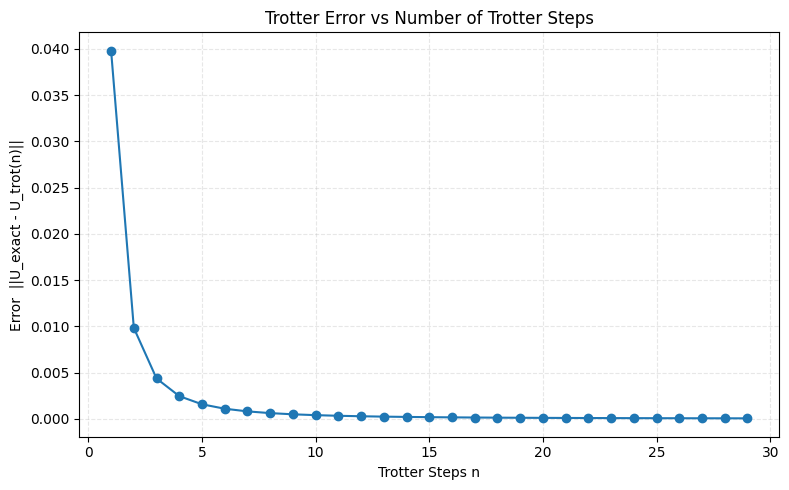

In [14]:
dev = qml.device("default.qubit", wires=5)
state = 1/np.sqrt(2**4) * np.ones(2**4)
H = get_hamiltonian_pl(4,1)
H_array = qml.matrix(H)
eval, _ = np.linalg.eigh(H_array)
emin = eval[0]
emax = eval[-1]
H_array = (H_array - emin * np.eye(2**nqubits)) / (emax - emin)
H = SparsePauliOp.from_operator(Operator(H_array))
H_cos = load_pauli_op(SparsePauliOp(["Y"])^H)

def trotter_matrix(H_cos, t, n_steps):
    op = qml.TrotterProduct(H_cos, -t, n=n_steps, order=2)
    return qml.matrix(op)

# ====== 精确矩阵（scipy） ======
def exact_matrix(H_cos, t):
    H_mat = qml.matrix(H_cos)
    return sc.linalg.expm(-1j * H_mat * t)

# ====== 误差曲线 ======
def plot_trotter_error(H_cos):
    ts = np.linspace(0, np.pi/2, 40)

    exact_vals = []
    trotter_vals = []
    errors = []

    for t in ts:
        U_exact = exact_matrix(H_cos, t)
        U_trot = trotter_matrix(H_cos, t)

        # 这里选 Frobenius norm
        err = np.linalg.norm(U_exact - U_trot)

        exact_vals.append(np.linalg.norm(U_exact))
        trotter_vals.append(np.linalg.norm(U_trot))
        errors.append(err)

    plt.figure(figsize=(8, 5))
    plt.plot(ts, errors, label="||U_exact - U_trot||", color="red")
    plt.xlabel("t")
    plt.ylabel("Error")
    plt.title("TrotterProduct Approximation Error")
    plt.grid(linestyle="--", alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()


def plot_error_vs_trotter_steps(H_cos, t):

    trotter_steps = np.arange(1, 30)   # n = 1 ... 29
    errors = []

    U_exact = exact_matrix(H_cos, t)

    for n in trotter_steps:
        U_trot = trotter_matrix(H_cos, t, n)
        err = np.linalg.norm(U_exact - U_trot)
        errors.append(err)

    plt.figure(figsize=(8,5))
    plt.plot(trotter_steps, errors, '-o')
    plt.xlabel("Trotter Steps n")
    plt.ylabel("Error  ||U_exact - U_trot(n)||")
    plt.title("Trotter Error vs Number of Trotter Steps")
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()

t = np.pi/2
plot_error_vs_trotter_steps(H_cos, t)

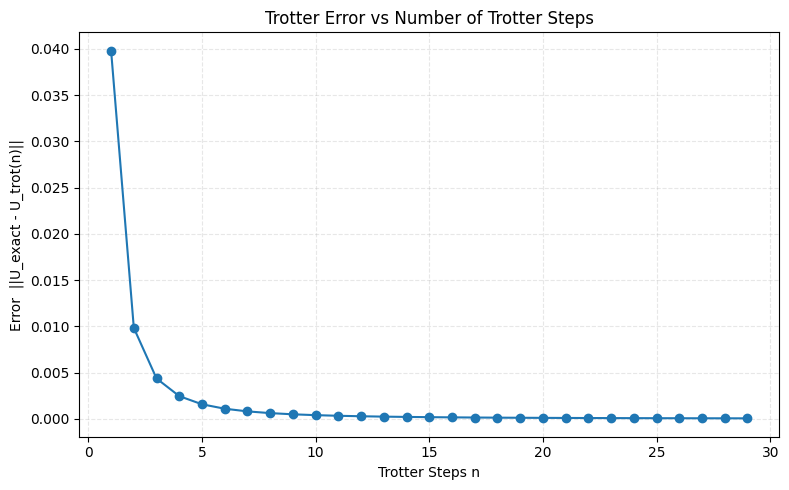

In [15]:
dev = qml.device("default.qubit", wires=5)
state = 1/np.sqrt(2**4) * np.ones(2**4)
H = get_hamiltonian_pl(4,1)
H_array = qml.matrix(H)
eval, _ = np.linalg.eigh(H_array)
emin = eval[0]
emax = eval[-1]
H_array = (H_array - emin * np.eye(2**nqubits)) / (emax - emin)
H = SparsePauliOp.from_operator(Operator(H_array))

def trotter_matrix(H_cos, t, n_steps):
    op = qml.TrotterProduct(H_cos, -t, n=n_steps, order=2)
    return qml.matrix(op)

# ====== 精确矩阵（scipy） ======
def exact_matrix(H_cos, t):
    H_mat = qml.matrix(H_cos)
    return sc.linalg.expm(-1j * H_mat * t)

#H_cos = load_pauli_op(SparsePauliOp(["Y"])^H)
H_cos = load_pauli_op(H^SparsePauliOp(["Y"]))
# ====== 误差曲线 ======
def plot_error_vs_trotter_steps(H_cos, t):

    trotter_steps = np.arange(1, 30)   # n = 1 ... 29
    errors = []

    U_exact = exact_matrix(H_cos, t)

    for n in trotter_steps:
        U_trot = trotter_matrix(H_cos, t, n)
        err = np.linalg.norm(U_exact - U_trot)
        errors.append(err)

    plt.figure(figsize=(8,5))
    plt.plot(trotter_steps, errors, '-o')
    plt.xlabel("Trotter Steps n")
    plt.ylabel("Error  ||U_exact - U_trot(n)||")
    plt.title("Trotter Error vs Number of Trotter Steps")
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()

t = np.pi/2
plot_error_vs_trotter_steps(H_cos, t)

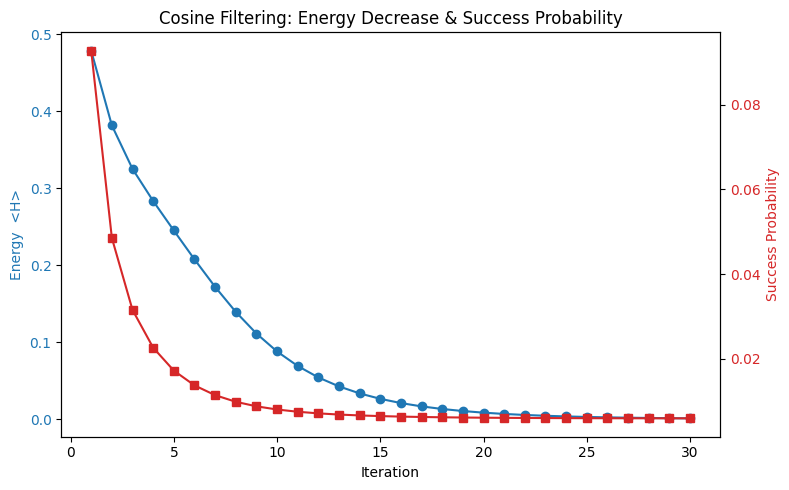

In [17]:
# ---------------------------------------------------------
# Device (noiseless)
# ---------------------------------------------------------
def select_dev(error_rate, nqubits):
    # If need noise, we can add qml.DepolarizingChannel etc.
    if error_rate == 0:
        return qml.device("default.qubit", wires=nqubits + 1)
    else:
        # simple noise model
        return qml.device("default.mixed", wires=nqubits + 1)


# ---------------------------------------------------------
# Cosine filtering loop
# ---------------------------------------------------------
def cosine_filtering_pl(H, H_cos, time, nqubits, error_rate,
                        step, threshold):

    dev = select_dev(error_rate, nqubits)

    # Pennylane QNode to apply filtering
    @qml.qnode(dev, interface="numpy")
    def cosine_step(state):
        qml.StatePrep(state, wires=range(1, nqubits + 1))

        qml.TrotterProduct(H_cos, -time, n=10, order=2)

        return qml.state()

    # For computing ⟨H⟩
    @qml.qnode(dev, interface="numpy")
    def energy_eval(state):
        qml.StatePrep(state, wires=range(nqubits))
        return qml.expval(H)

    # initial state
    #state = 1/np.sqrt(2**nqubits) * np.ones(2**nqubits)
    state = np.zeros(2**nqubits)
    state[0] = 1.0

    expectation_list = []
    probability_list = []

    for i in range(step):

        # 1. evolve
        full_state = cosine_step(state)

        # 2. post-select ancilla = 0
        # full_state shape = (2^(nqubits+1), )
        reshaped = full_state.reshape((2, 2**nqubits))
        post_state = reshaped[0, :]
        #post_state = full_state[:2**nqubits]
        prob = np.linalg.norm(post_state)**2

        if prob < 1e-12:
            raise ValueError("Post-selection probability=0")

        post_state = post_state / np.sqrt(prob)

        # 3. compute energy
        expectation = energy_eval(post_state)

        if expectation <= threshold:
            break

        # 4. accumulate probability
        if i == 0:
            probability_list.append(prob)
        else:
            probability_list.append(probability_list[-1] * prob)

        expectation_list.append(expectation)
        state = post_state

    return np.array(expectation_list), np.array(probability_list)

def plot_cosine_filter(expectations, probabilities):
    """
    expectations: numpy array of <H> per iteration
    probabilities: cumulative success probability per iteration
    """

    steps = np.arange(1, len(expectations) + 1)

    fig, ax1 = plt.subplots(figsize=(8, 5))

    # -------------------------
    # 绘制能量下降曲线（左轴）
    # -------------------------
    color1 = "tab:blue"
    ax1.set_xlabel("Iteration")
    ax1.set_ylabel("Energy  <H>", color=color1)
    ax1.plot(steps, expectations, "-o", color=color1, label="Energy")
    ax1.tick_params(axis="y", labelcolor=color1)
    #ax1.grid(True, linestyle="--", alpha=0.3)

    # -------------------------
    # 绘制成功概率曲线（右轴）
    # -------------------------
    ax2 = ax1.twinx()
    color2 = "tab:red"
    ax2.set_ylabel("Success Probability", color=color2)
    ax2.plot(steps, probabilities, "-s", color=color2, label="Probability")
    ax2.tick_params(axis="y", labelcolor=color2)

    # -------------------------
    # 标题
    # -------------------------
    plt.title("Cosine Filtering: Energy Decrease & Success Probability")

    plt.tight_layout()
    plt.show()

H = SparsePauliOp.from_operator(Operator(H_array))
H_op = load_pauli_op(H)
#H_cos = load_pauli_op(SparsePauliOp(["Y"])^H)
H_cos = load_pauli_op(H^SparsePauliOp(["Y"]))
time = np.pi/2
nqubits = 4
error_rate = 0
step = 30
threshold = 1e-4

expectation_list, probability_list = cosine_filtering_pl(
        H_op, H_cos, time, nqubits, error_rate, step, threshold
    )
plot_cosine_filter(expectation_list, probability_list)


In [20]:
test_a = qml.matrix(get_hamiltonian_pl(4,1))
vals, vecs = np.linalg.eigh(test_a)
gs = vecs[:, np.argmin(vals)]
test_b = np.zeros(2**4)
test_b[0] = 1
np.abs(np.vdot(gs, test_b))**2

np.float64(0.005873803214612145)

In [21]:
test_c = 1/np.sqrt(2**4) * np.ones(2**4)
np.abs(np.dot(test_c, gs))

np.float64(0.10838637566236958)

In [131]:
def ansatz_vqe(nqubits, depth, params):
    circuit = QuantumCircuit(nqubits + 1)
    t = 0
    for i in range(nqubits):
        circuit.h(i)
    for idepth in range(depth):
        for i in range(nqubits):
            if i < (nqubits - 1):
                j = i + 1
            else:
                j = 0
            circuit.rzz(params[t], i, j)
            t += 1
        circuit.barrier()
        for i in range(nqubits):
            if i < (nqubits - 1):
                j = i + 1
            else:
                j = 0
            circuit.rx(params[t], i)
            t += 1
        circuit.ry(params[t], nqubits)
        t += 1
    return circuit

nqubits = 4
depth = 3
num_params = depth * (2*nqubits + 1)
params = np.random.random(num_params)
circuit = ansatz_vqe(nqubits, depth, params)
circuit.draw()

┌───┐                                                      ░ »
q_0: ┤ H ├─■───────────────────────────────────────■────────────░─»
     ├───┤ │ZZ(0.40568)                            │            ░ »
q_1: ┤ H ├─■─────────────■─────────────────────────┼────────────░─»
     ├───┤               │ZZ(0.885)                │            ░ »
q_2: ┤ H ├───────────────■───────────■─────────────┼────────────░─»
     ├───┤                           │ZZ(0.67471)  │ZZ(0.9914)  ░ »
q_3: ┤ H ├───────────────────────────■─────────────■────────────░─»
     └───┘                                                      ░ »
q_4: ───────────────────────────────────────────────────────────░─»
                                                                ░ »
«     ┌─────────────┐                                                        »
«q_0: ┤ Rx(0.43907) ├─■────────────────────────────────────────■─────────────»
«     └┬────────────┤ │ZZ(0.60633)                             │             »
«q_1: ─┤ Rx(0.9693) ├─■─────────────■──────────────────────────┼─────────────»
«     ┌┴────────────┤               │ZZ(0.4986)                │             »
«q_2: ┤ Rx(0.74697) ├───────────────■────────────■─────────────┼─────────────»
«     ├─────────────┤                            │ZZ(0.72787)  │ZZ(0.038326) »
«q_3: ┤ Rx(0.28921) ├────────────────────────────■─────────────■─────────────»
«     ├─────────────┤                                                        »
«q_4: ┤ Ry(0.24826) ├────────────────────────────────────────────────────────»
«     └─────────────┘                                                        »
«      ░ ┌─────────────┐                                                       »
«q_0: ─░─┤ Rx(0.94954) ├──■────────────────────────────────────────■───────────»
«      ░ ├─────────────┤  │ZZ(0.99114)                             │           »
«q_1: ─░─┤ Rx(0.76925) ├──■─────────────■──────────────────────────┼───────────»
«      ░ ├─────────────┴┐               │ZZ(0.6684)                │           »
«q_2: ─░─┤ Rx(0.023324) ├───────────────■────────────■─────────────┼───────────»
«      ░ └┬────────────┬┘                            │ZZ(0.67815)  │ZZ(0.9486) »
«q_3: ─░──┤ Rx(0.2037) ├─────────────────────────────■─────────────■───────────»
«      ░ ┌┴────────────┤                                                       »
«q_4: ─░─┤ Ry(0.29982) ├───────────────────────────────────────────────────────»
«      ░ └─────────────┘                                                       »
«      ░ ┌─────────────┐
«q_0: ─░─┤ Rx(0.36037) ├
«      ░ ├─────────────┤
«q_1: ─░─┤ Rx(0.91034) ├
«      ░ ├─────────────┤
«q_2: ─░─┤ Rx(0.72199) ├
«      ░ ├─────────────┤
«q_3: ─░─┤ Rx(0.51946) ├
«      ░ ├─────────────┤
«q_4: ─░─┤ Ry(0.13245) ├
«      ░ └─────────────┘

(<Figure size 1900x600 with 1 Axes>, <Axes: >)

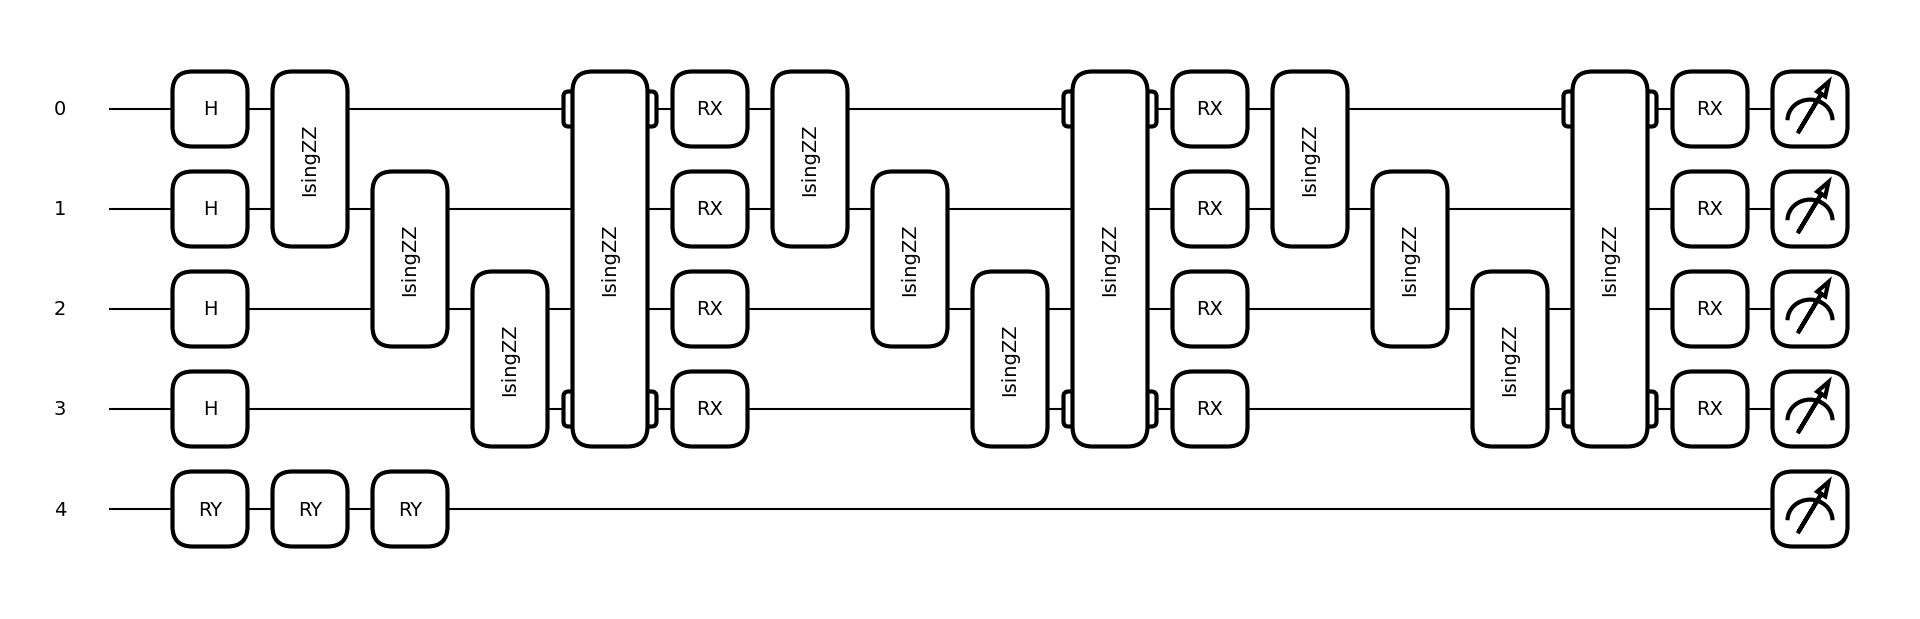

In [130]:
def ansatz_vqe(params, nqubits, depth):
    """PennyLane version of the given Qiskit ansatz_vqe."""
    t = 0

    # Apply H on system qubits
    for i in range(nqubits):
        qml.Hadamard(wires=i)

    # Layers
    for _ in range(depth):

        # --- RZZ ring ---
        for i in range(nqubits):
            j = i + 1 if i < (nqubits - 1) else 0
            qml.IsingZZ(params[t], wires=[i, j])
            t += 1

        # (barrier ignored)

        # --- RX ring ---
        for i in range(nqubits):
            j = i + 1 if i < (nqubits - 1) else 0
            qml.RX(params[t], wires=i)
            t += 1

        # --- RY on ancilla ---
        qml.RY(params[t], wires=nqubits)   # ancilla is last wire
        t += 1

nqubits = 4
depth = 3
num_params = depth * (2*nqubits + 1)
params = np.random.random(num_params)

dev = qml.device("default.qubit", wires=nqubits + 1)

@qml.qnode(dev)
def circuit(params):
    ansatz_vqe(params, nqubits, depth)
    return qml.state()

qml.draw_mpl(circuit)(params)

In [ ]:
H = SparsePauliOp.from_operator(Operator(H_array))
H_op = load_pauli_op(H)
@qml.qnode(dev, interface="numpy")
def run_circuit():
    state = np.zeros(2**nqubits)

    qml.StatePrep(state, wires=range(nqubits+1))

In [5]:






# =====================================================
# 1. TFIM Hamiltonian + 辅助函数
# =====================================================
def get_hamiltonian_pl(nq, J):
    coeffs = []
    ops = []
    for i in range(nq - 1):
        coeffs.append(J)
        ops.append(qml.PauliZ(i) @ qml.PauliZ(i + 1))
    coeffs.append(J)
    ops.append(qml.PauliZ(nq - 1) @ qml.PauliZ(0))
    for i in range(nq):
        coeffs.append(J)
        ops.append(qml.PauliX(i))
    return qml.Hamiltonian(coeffs, ops)


def kron_n(op_list):
    r = np.array([[1]])
    for op in op_list:
        r = np.kron(r, op)
    return r

def tfim_model(n):
    Z = np.array([[1,0],[0,-1]]); X = np.array([[0,1],[1,0]]); I = np.eye(2)
    H = np.zeros((2**n, 2**n), dtype=np.complex128)
    for i in range(n):
        Zi = [I]*n; Zi[i]=Z; Zi[(i+1)%n]=Z; H -= kron_n(Zi)
        Xi = [I]*n; Xi[i]=X; H -= kron_n(Xi)
    return H

def shift_and_normalize_H(H):
    vals = np.linalg.eigvalsh(H)
    lmin, lmax = vals.min(), vals.max()
    Hn = (H - lmin*np.eye(len(H))) / (lmax - lmin) * (np.pi/2)
    l0 = np.min(np.linalg.eigvalsh(Hn))
    return Hn - l0*np.eye(len(Hn))

def get_ground_state(H):
    vals, vecs = np.linalg.eigh(H)
    return vecs[:, np.argmin(vals)]

def select_dev(error_rate, nqubits):
    # If need noise, we can add qml.DepolarizingChannel etc.
    if error_rate == 0:
        return qml.device("default.qubit", wires=nqubits + 1)
    else:
        # simple noise model
        return qml.device("default.mixed", wires=nqubits + 1)

# =====================================================
# 2. LCU 构造
# =====================================================
def cosine_filtering_pl(H, H_cos, time, nqubits, error_rate,
                        step, threshold):

    dev = select_dev(error_rate, nqubits)

    # Pennylane QNode to apply filtering
    @qml.qnode(dev, interface="numpy")
    def cosine_step(state):
        qml.StatePrep(state, wires=range(1, nqubits + 1))

        qml.TrotterProduct(H_cos, -time, n=10, order=2)

        return qml.state()

    # For computing ⟨H⟩
    @qml.qnode(dev, interface="numpy")
    def energy_eval(state):
        qml.StatePrep(state, wires=range(nqubits))
        return qml.expval(H)

    # initial state
    state = 1/np.sqrt(2**nqubits) * np.ones(2**nqubits)
    #state[0] = 1.0

    expectation_list = []
    probability_list = []

    for i in range(step):

        # 1. evolve
        full_state = cosine_step(state)

        # 2. post-select ancilla = 0
        # full_state shape = (2^(nqubits+1), )
        reshaped = full_state.reshape((2, 2**nqubits))
        post_state = reshaped[0, :]
        #post_state = full_state[:2**nqubits]
        prob = np.linalg.norm(post_state)**2

        if prob < 1e-12:
            raise ValueError("Post-selection probability=0")

        post_state = post_state / np.sqrt(prob)

        # 3. compute energy
        expectation = energy_eval(post_state)

        if expectation <= threshold:
            break

        # 4. accumulate probability
        if i == 0:
            probability_list.append(prob)
        else:
            probability_list.append(probability_list[-1] * prob)

        expectation_list.append(expectation)
        state = post_state

    return np.array(expectation_list), np.array(probability_list)

# =====================================================
# 3. 定义 U = LCUPrepare，O = Oracle
# =====================================================
error_rate = 0
nqubits = 4
state = np.zeros(2**nqubits)
state[0] = 1
dev = select_dev(error_rate, nqubits)
@qml.prod
def cosine_step(nqubits, H_cos, time, state):
    qml.StatePrep(state, wires=range(1, nqubits + 1))
    qml.TrotterProduct(H_cos, -time, n=10, order=2)
    #return qml.state()

# @qml.prod
# def prepare_init(n):
#     for i in range(n):
#         qml.Hadamard(wires=i)

@qml.prod
def Oracle_op(anc_wires):
    """蓝色块：A → FlipSign(anc=0) → A†"""
    #LCUPrepare_op(weights, U_ops, anc_wires, sys_wires)
    qml.FlipSign(n=0, wires=anc_wires)
    #qml.adjoint(LCUPrepare_op)(weights, U_ops, anc_wires, sys_wires)


# =====================================================
# 4. 主过程：Amplitude Amplification
# =====================================================

dev = select_dev(error_rate, nqubits)
@qml.qnode(dev)
def circuit(iters):
        # for i in range(n):
        #     qml.Hadamard(wires=i)
    cosine_step(nqubits, H_cos, iters, state)
    qml.AmplitudeAmplification(
            U = cosine_step(nqubits, H_cos, iters, state),
            #U = prepare_init(n),
            O = Oracle_op(0),
            iters = iters,
            fixed_point=False,
            #work_wire=len(all_wires)+1,
        )
    return qml.state()

qml.draw_mpl(circuit)(1)

NameError: name 'H_cos' is not defined

In [15]:
#H = 1/np.sqrt(2) * np.array([[1, 1], [1, -1]])
def shift_and_normalize_H(H):
    eigvals = np.linalg.eigvalsh(H)
    λ_min, λ_max = np.min(eigvals), np.max(eigvals)
    H_norm = (H - λ_min * np.eye(len(H))) / (λ_max - λ_min) * np.pi /2
    λ0 = np.min(np.linalg.eigvalsh(H_norm))
    H_shifted = H_norm - λ0 * np.eye(len(H))
    return H_shifted

def shift_and_normalize_H1(H):
    eigvals = np.linalg.eigvalsh(H)
    λ_min, λ_max = np.min(eigvals), np.max(eigvals)
    H_norm = (H - λ_min * np.eye(len(H))) / (λ_max - λ_min) * np.pi
    λ0 = np.min(np.linalg.eigvalsh(H_norm))
    H_shifted = H_norm - λ0 * np.eye(len(H))
    return H_shifted

def kron_n(op_list):
    result = np.array([[1]])
    for op in op_list:
        result = np.kron(result, op)
    return result

# TFIM Hamiltonian
def tfim_model(n):
    dim = 2 ** n
    H = np.zeros((dim, dim), dtype=np.complex128)
    Z = np.array([[1, 0], [0, -1]])
    X = np.array([[0, 1], [1, 0]])
    I = np.eye(2)
    for i in range(n):
        Zi = [I] * n
        Zi[i] = Z
        Zi[(i + 1) % n] = Z
        H -= kron_n(Zi)
        Xi = [I] * n
        Xi[i] = X
        H -= kron_n(Xi)
    return H


def generate_random_state_with_overlap(gs, overlap):

    gs = gs / np.linalg.norm(gs)

    dim = len(gs)

    v = np.random.randn(dim) + 1j * np.random.randn(dim)

    proj = np.vdot(gs, v) * gs
    v_perp = v - proj

    if np.linalg.norm(v_perp) < 1e-12:
        return generate_random_state_with_overlap(gs, overlap)

    v_perp = v_perp / np.linalg.norm(v_perp)

    psi = np.sqrt(overlap) * gs + np.sqrt(1 - overlap) * v_perp
    psi = psi / np.linalg.norm(psi)

    return psi

#state_tem = generate_random_state_with_overlap(groundstate_1, 0.25)


# 归一化并 shift
n = 4
H = tfim_model(n)
#H = qml.matrix(get_hamiltonian_pl(4, 1))
H_1 = shift_and_normalize_H(H)
H_2 = shift_and_normalize_H1(H)
# psi_0 = np.ones(2**4) /np.sqrt(2**4)
# psi_0[-1] = 1
#
# psi_0 = np.zeros(2**4)
# psi_0[0]=1

vals, vecs = np.linalg.eigh(H)
gs = vecs[:, np.argmin(vals)]


#psi_0 = generate_random_state_with_overlap(gs, 0.005873)

dim = len(gs)
psi_0 = np.random.randn(dim) + 1j * np.random.randn(dim)
psi_0 /= np.linalg.norm(psi_0)
print('overlap init and gs', np.abs(np.vdot(psi_0, gs))**2)

U = expm(1j * H_1)
U_dag = expm(-1j * H_1)
cosH = 0.5 * (U + U_dag)
m = 1
cosine_matrix = np.linalg.matrix_power(cosH, 2*m)
dirichlet_matrix = 1/(2*m+1) * sum(expm(-1j * H_2 * i) for i in range(-m, m + 1))
#print(np.linalg.norm(cosine_matrix) - np.linalg.norm(dirichlet_matrix))
state_1 = cosine_matrix@(psi_0)
state_1 = state_1 / np.linalg.norm(state_1)
state_2 = dirichlet_matrix@(psi_0)
state_2 = state_2 / np.linalg.norm(state_2)
fidelity_1 = np.abs(np.vdot(state_1, gs))**2
fidelity_2 = np.abs(np.vdot(state_2, gs))**2

print('fid1', fidelity_1)
print('fid2', fidelity_2)

overlap init and gs 0.01743356282841669
fid1 0.06952182164766045
fid2 0.08250911497476554


In [13]:
def compute_fidelities(psi_0):
    """Given psi_0, compute fidelity_1 and fidelity_2."""
    # cosine filter
    state_1 = cosine_matrix @ psi_0
    state_1 /= np.linalg.norm(state_1)
    fid1 = np.abs(np.vdot(state_1, gs))**2

    # dirichlet filter
    state_2 = dirichlet_matrix @ psi_0
    state_2 /= np.linalg.norm(state_2)
    fid2 = np.abs(np.vdot(state_2, gs))**2
    print('fid1', fid1)
    print('fid2', fid2)
    print('overlap init and gs', np.abs(np.vdot(psi_0, gs))**2)
    return

psi_0 = np.zeros(2**4)
psi_0[0]=1
compute_fidelities(psi_0)

fid1 0.38536959115068264
fid2 0.3964575864842589
overlap init and gs 0.33251454443369927


In [6]:
psi_0 = np.random.randn(dim) + 1j * np.random.randn(dim)
psi_0 /= np.linalg.norm(psi_0)
compute_fidelities(psi_0)

fid1 0.09099726583926428
fid2 0.11006462988337366
overlap init and gs 0.03917836887818809


fid1 0.38536959115068264
fid2 0.3964575864842589
overlap init and gs 0.33251454443369927


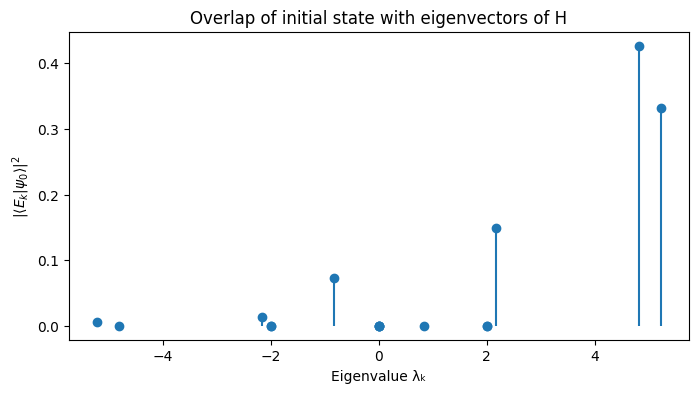

array([5.87380321e-03, 1.61453015e-33, 1.31563137e-02, 2.27757422e-32,
       5.37782246e-33, 7.32233047e-02, 2.35699874e-33, 1.11789806e-32,
       3.60749432e-33, 1.50690859e-32, 3.88567843e-33, 1.08140273e-33,
       5.32460433e-31, 1.48455339e-01, 4.26776695e-01, 3.32514544e-01])

In [14]:
import numpy as np
import matplotlib.pyplot as plt

def plot_overlap(psi_0, H):
    """
    Plot |<E_k | psi_0>|^2 vs eigenvalue λ_k.

    psi_0 : initial state vector
    H     : Hamiltonian matrix
    """

    # eigendecomposition
    eigvals, eigvecs = np.linalg.eigh(H)

    # compute overlaps |<E_k | psi_0>|^2
    overlaps = np.abs(eigvecs.conj().T @ psi_0)**2

    # plot
    plt.figure(figsize=(8,4))
    plt.stem(eigvals, overlaps, basefmt=" ")
    plt.xlabel("Eigenvalue λₖ")
    plt.ylabel(r"$|\langle E_k | \psi_0\rangle|^2$")
    plt.title("Overlap of initial state with eigenvectors of H")
    plt.show()

    return overlaps
def plot_overlap1(psi_0, H):
    """
    Plot |<E_k | psi_0>|^2 vs eigenvector index k.

    psi_0 : initial state vector
    H     : Hamiltonian matrix
    """

    # eigendecomposition
    eigvals, eigvecs = np.linalg.eigh(H)

    # compute overlaps |<E_k | psi_0>|^2
    overlaps = np.abs(eigvecs.conj().T @ psi_0)**2

    # plot
    plt.figure(figsize=(8,4))
    plt.stem(range(len(overlaps)), overlaps, basefmt=" ")
    plt.xlabel("Eigenvector index k")
    plt.ylabel(r"$|\langle E_k | \psi_0\rangle|^2$")
    plt.title("Overlap of initial state with eigenvectors of H")
    #plt.grid(alpha=0.3)
    plt.show()

    return overlaps

H = qml.matrix(get_hamiltonian_pl(4,1))
psi_0 = np.zeros(2**4)
psi_0[0]=1
compute_fidelities(psi_0)
plot_overlap(psi_0, H)

fid1 0.38536959115068264
fid2 0.3964575864842589
overlap init and gs 0.33251454443369927


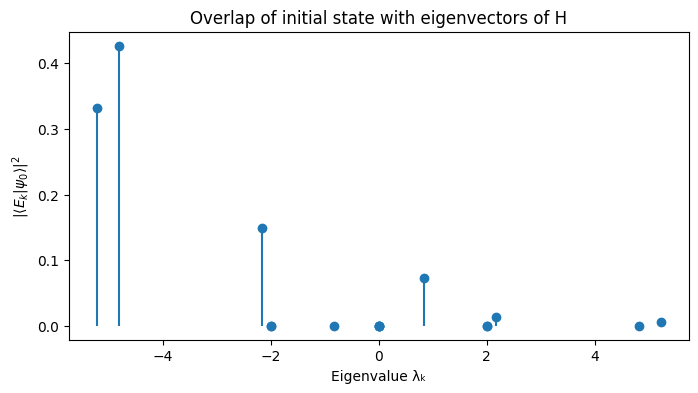

array([3.32514544e-01, 4.26776695e-01, 1.48455339e-01, 1.35791751e-32,
       1.12526293e-30, 1.21760636e-32, 2.22150052e-33, 4.32504799e-34,
       1.62844437e-32, 2.04112584e-32, 7.32233047e-02, 9.77891341e-33,
       1.02778034e-32, 1.31563137e-02, 1.76145339e-33, 5.87380321e-03])

In [16]:
H = tfim_model(4)
psi_0 = np.zeros(2**4)
psi_0[0]=1
compute_fidelities(psi_0)
plot_overlap(psi_0, H)

fid1 0.7756065932124117
fid2 0.8033731316016808
overlap init and gs 0.6650290888674134


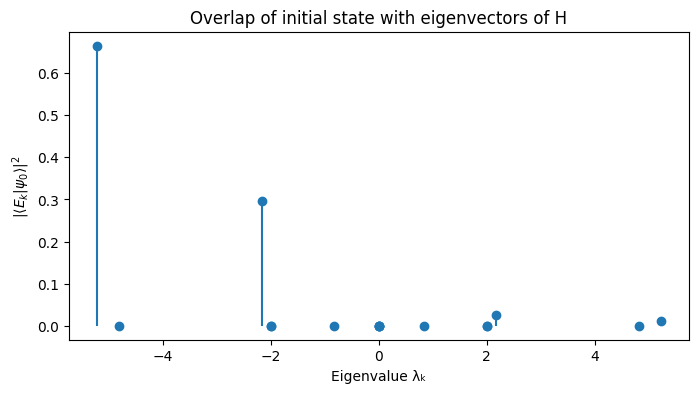

array([6.65029089e-01, 6.79537418e-29, 2.96910677e-01, 7.70371978e-32,
       2.41588652e-30, 9.43705673e-33, 1.23259516e-32, 4.81482486e-35,
       0.00000000e+00, 1.73333695e-33, 1.73333695e-33, 1.06359481e-31,
       3.77482269e-32, 2.63126273e-02, 2.03426350e-33, 1.17476064e-02])

In [17]:
H = tfim_model(4)
psi_0 = np.ones(2**4) /np.sqrt(2**4)
#psi_0[0]=1
compute_fidelities(psi_0)
plot_overlap(psi_0, H)

fid1 0.16993578720728184
fid2 0.2020933708520396
overlap init and gs 0.07083316146198161


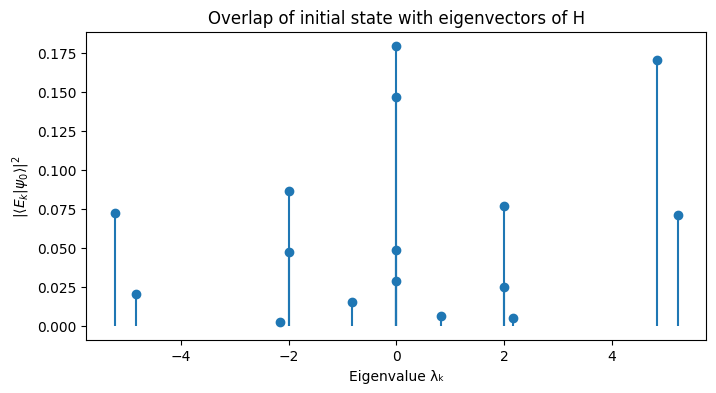

array([0.07200018, 0.02044243, 0.00259199, 0.08614198, 0.04733084,
       0.01493059, 0.14665653, 0.17938947, 0.02855596, 0.04827141,
       0.00635841, 0.07646498, 0.02503679, 0.00476435, 0.17023094,
       0.07083316])

In [10]:
psi_0 = np.random.randn(dim) + 1j * np.random.randn(dim)
psi_0 /= np.linalg.norm(psi_0)
compute_fidelities(psi_0)
plot_overlap(psi_0, H)

fid1 0.12093702927452778
fid2 0.05111543836342253
overlap init and gs 0.005873803214612145


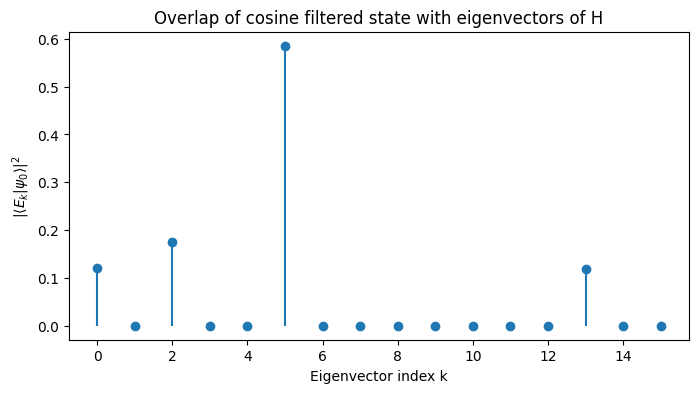

array([1.20937029e-01, 2.64442370e-32, 1.74599451e-01, 2.93873588e-31,
       8.59476330e-32, 5.85547938e-01, 5.82593808e-33, 1.13256718e-31,
       7.82709966e-33, 4.62704669e-32, 2.44146892e-32, 1.08333559e-34,
       4.53026871e-31, 1.18803594e-01, 1.11987859e-04, 9.11085234e-32])

In [11]:
import numpy as np
import matplotlib.pyplot as plt

def plot_overlap(psi_0, H):
    """
    Plot |<E_k | psi_0>|^2 vs eigenvector index k.

    psi_0 : initial state vector
    H     : Hamiltonian matrix
    """

    # eigendecomposition
    eigvals, eigvecs = np.linalg.eigh(H)
    state_1 = cosine_matrix @ psi_0
    state_1 /= np.linalg.norm(state_1)

    # compute overlaps |<E_k | psi_0>|^2
    overlaps = np.abs(eigvecs.conj().T @ state_1)**2

    # plot
    plt.figure(figsize=(8,4))
    plt.stem(range(len(overlaps)), overlaps, basefmt=" ")
    plt.xlabel("Eigenvector index k")
    plt.ylabel(r"$|\langle E_k | \psi_0\rangle|^2$")
    plt.title("Overlap of cosine filtered state with eigenvectors of H")
    #plt.grid(alpha=0.3)
    plt.show()

    return overlaps

H = qml.matrix(get_hamiltonian_pl(4,1))
psi_0 = np.zeros(2**4)
psi_0[0]=1
compute_fidelities(psi_0)
plot_overlap(psi_0, H)

fid1 0.12093702927452778
fid2 0.05111543836342253
overlap init and gs 0.005873803214612145


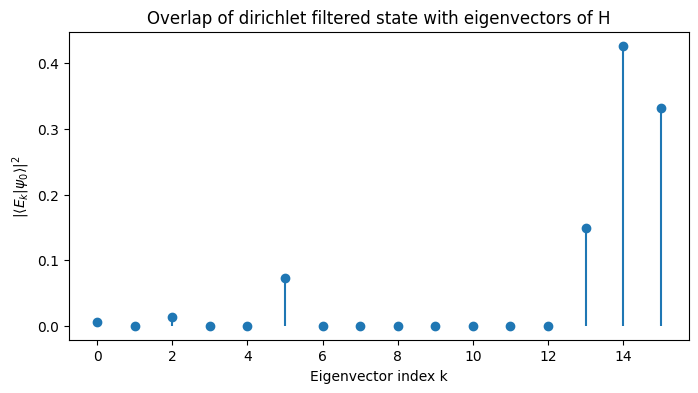

array([5.87380321e-03, 1.61453015e-33, 1.31563137e-02, 2.27757422e-32,
       5.37782246e-33, 7.32233047e-02, 2.35699874e-33, 1.11789806e-32,
       3.60749432e-33, 1.50690859e-32, 3.88567843e-33, 1.08140273e-33,
       5.32460433e-31, 1.48455339e-01, 4.26776695e-01, 3.32514544e-01])

In [284]:
import numpy as np
import matplotlib.pyplot as plt

def plot_overlap(psi_0, H):
    """
    Plot |<E_k | psi_0>|^2 vs eigenvector index k.

    psi_0 : initial state vector
    H     : Hamiltonian matrix
    """

    # eigendecomposition
    eigvals, eigvecs = np.linalg.eigh(H)
    state_1 = cosine_matrix @ psi_0
    state_1 /= np.linalg.norm(state_1)
    state_2 = dirichlet_matrix @ psi_0
    state_2 /= np.linalg.norm(state_2)

    # compute overlaps |<E_k | psi_0>|^2
    overlaps = np.abs(eigvecs.conj().T @ psi_0)**2

    # plot
    plt.figure(figsize=(8,4))
    plt.stem(range(len(overlaps)), overlaps, basefmt=" ")
    plt.xlabel("Eigenvector index k")
    plt.ylabel(r"$|\langle E_k | \psi_0\rangle|^2$")
    plt.title("Overlap of dirichlet filtered state with eigenvectors of H")
    #plt.grid(alpha=0.3)
    plt.show()

    return overlaps

H = qml.matrix(get_hamiltonian_pl(4,1))
psi_0 = np.zeros(2**4)
psi_0[0]=1
compute_fidelities(psi_0)
plot_overlap(psi_0, H)

In [317]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm

def plot_filtered_overlaps(psi_0, H, m=1):
    """
    Given psi_0 and Hamiltonian H,
    compute cosine-filtered and dirichlet-filtered states,
    then plot overlaps with every eigenvector of H.

    x-axis = eigenvalues (not index)
    """

    # -------------------------
    # 1. Eigendecomposition of H
    # -------------------------
    eigvals, eigvecs = np.linalg.eigh(H)

    # -------------------------
    # 2. Build shifted-normalized Hamiltonians
    # -------------------------
    H_1 = shift_and_normalize_H(H)
    H_2 = shift_and_normalize_H1(H)

    # -------------------------
    # 3. Construct the filters
    # -------------------------
    U = expm(1j * H_1)
    U_dag = expm(-1j * H_1)
    cosH = 0.5 * (U + U_dag)
    cosine_matrix = np.linalg.matrix_power(cosH, 2*m)

    dirichlet_matrix = 1/(2*m+1) * sum(
        expm(-1j * H_2 * i) for i in range(-m, m+1)
    )

    # -------------------------
    # 4. Apply filters to psi_0
    # -------------------------
    psi_cos = cosine_matrix @ psi_0
    psi_cos /= np.linalg.norm(psi_cos)

    psi_dir = dirichlet_matrix @ psi_0
    psi_dir /= np.linalg.norm(psi_dir)

    # -------------------------
    # 5. Compute all overlaps
    # -------------------------
    overlaps_init = np.abs(eigvecs.conj().T @ psi_0)**2
    overlaps_cos  = np.abs(eigvecs.conj().T @ psi_cos)**2
    overlaps_dir  = np.abs(eigvecs.conj().T @ psi_dir)**2

    # -------------------------
    # 6. Plot (x-axis = eigenvalues)
    # -------------------------
    plt.figure(figsize=(12,5))

    plt.stem(eigvals, overlaps_init, linefmt='gray', markerfmt='o', basefmt=" ",
             label='initial |ψ₀⟩')

    plt.stem(eigvals, overlaps_cos,  linefmt='blue', markerfmt='D', basefmt=" ",
             label='cosine filtered')

    plt.stem(eigvals, overlaps_dir,  linefmt='red', markerfmt='s', basefmt=" ",
             label='dirichlet filtered')

    plt.xlabel("Eigenvalue λₖ")
    plt.ylabel(r"$|\langle E_k | \psi\rangle|^2$")
    plt.title("Overlap with Eigenstates (x-axis = eigenvalues)")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

    return #overlaps_init, overlaps_cos, overlaps_dir

def plot_filtered_overlaps1(psi_0, H, m=1):
    """
    Given psi_0 and Hamiltonian H,
    compute cosine-filtered and dirichlet-filtered states,
    then plot overlaps with every eigenvector of H.

    psi_0 : initial state vector
    H     : Hamiltonian matrix
    m     : filter parameter
    """

    # -------------------------
    # 1. Eigendecomposition of H
    # -------------------------
    eigvals, eigvecs = np.linalg.eigh(H)

    # -------------------------
    # 2. Build shifted-normalized Hamiltonians
    # -------------------------
    H_1 = shift_and_normalize_H(H)
    H_2 = shift_and_normalize_H1(H)

    # -------------------------
    # 3. Construct the filters
    # -------------------------
    U = expm(1j * H_1)
    U_dag = expm(-1j * H_1)
    cosH = 0.5 * (U + U_dag)
    cosine_matrix = np.linalg.matrix_power(cosH, 2*m)

    dirichlet_matrix = 1/(2*m+1) * sum(
        expm(-1j * H_2 * i) for i in range(-m, m+1)
    )

    # -------------------------
    # 4. Apply filters to psi_0
    # -------------------------
    # cosine filtered
    psi_cos = cosine_matrix @ psi_0
    psi_cos /= np.linalg.norm(psi_cos)

    # dirichlet filtered
    psi_dir = dirichlet_matrix @ psi_0
    psi_dir /= np.linalg.norm(psi_dir)

    # -------------------------
    # 5. Compute all overlaps
    # -------------------------
    overlaps_init = np.abs(eigvecs.conj().T @ psi_0)**2
    overlaps_cos  = np.abs(eigvecs.conj().T @ psi_cos)**2
    overlaps_dir  = np.abs(eigvecs.conj().T @ psi_dir)**2

    # -------------------------
    # 6. Plot
    # -------------------------
    k = range(len(overlaps_init))
    plt.figure(figsize=(12,5))

    plt.stem(k, overlaps_init, linefmt='gray', markerfmt='o', basefmt=" ",
             label='initial |ψ₀⟩')
    plt.stem(k, overlaps_cos,  linefmt='blue', markerfmt='D', basefmt=" ",
             label='cosine filtered')
    plt.stem(k, overlaps_dir,  linefmt='red', markerfmt='s', basefmt=" ",
             label='dirichlet filtered')

    plt.xlabel("Eigenvector index k")
    plt.ylabel(r"$|\langle E_k | \psi\rangle|^2$")
    plt.title("Overlap of Initial / Cosine-filtered / Dirichlet-filtered States with Eigenvectors of H")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

    return #overlaps_init, overlaps_cos, overlaps_dir


def top_two_excited_state_vector(H):
    """
    给定厄米矩阵 H，返回：
    - v1: 最高能级本征态（最大本征值）
    - v2: 次高能级本征态
    - psi: 由 v1 和 v2 等幅叠加得到的归一化态 (v1 + v2)/sqrt(2)

    H: (d, d) Hermitian matrix
    """
    # 本征分解（eigvals 升序排列）
    eigvals, eigvecs = np.linalg.eigh(H)

    # 最高和次高能级对应的索引（升序 ⇒ 最后两个就是最高的）
    idx_max = np.argsort(eigvals)  # 其实 np.linalg.eigh 已经是升序，但这样更稳
    i0 = idx_max[0]
    i1 = idx_max[-1]   # 最大本征值
    i2 = idx_max[-2]   # 次大本征值

    v0 = eigvecs[:, i0]
    v1 = eigvecs[:, i1]
    v2 = eigvecs[:, i2]

    # 等幅叠加并归一化（v1, v2 本来正交归一，直接除 sqrt(2) 就行）
    psi = (v0 + v1 + v2) / np.sqrt(3)

    return v1, v2, psi

def top_two_excited_state_vector_skewed(H, weight0=0.05):
    """
    生成一个态，使得基态 v0 权重较小（weight0），
    剩余部分平均分给最高两个激发态 v1, v2。
    """

    eigvals, eigvecs = np.linalg.eigh(H)
    idx = np.argsort(eigvals)

    i0 = idx[0]      # ground state
    i1 = idx[-1]     # highest excited
    i2 = idx[-2]     # second highest

    v0 = eigvecs[:, i0]
    v1 = eigvecs[:, i1]
    v2 = eigvecs[:, i2]

    # weights
    a0 = np.sqrt(weight0)
    a1 = np.sqrt((1 - weight0) / 2)
    a2 = np.sqrt((1 - weight0) / 2)

    psi = a0*v0 + a1*v1 + a2*v2
    psi /= np.linalg.norm(psi)

    return v0, v1, v2, psi


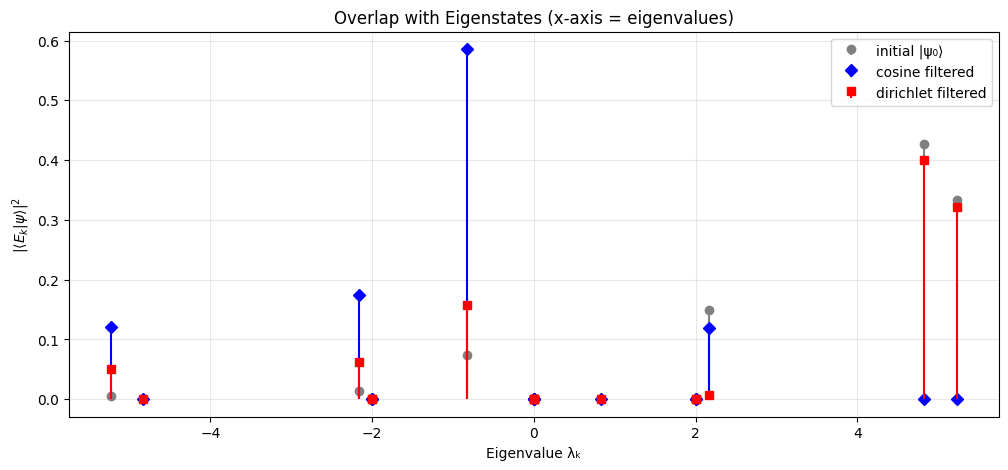

In [318]:
H = qml.matrix(get_hamiltonian_pl(4, 1))

psi_0 = np.zeros(16)
psi_0[0] = 1

plot_filtered_overlaps(psi_0, H, m=1)


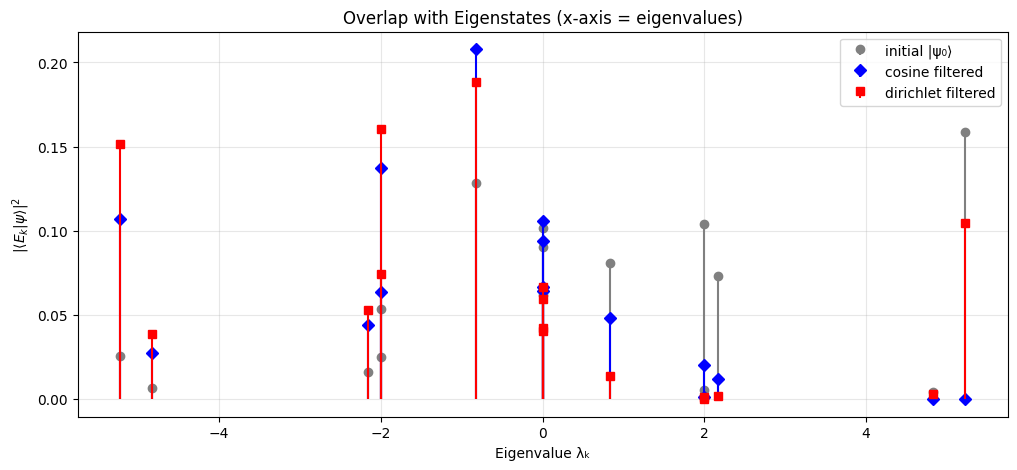

In [319]:
psi_0 = np.random.randn(16) + 1j*np.random.randn(16)
psi_0 /= np.linalg.norm(psi_0)

plot_filtered_overlaps(psi_0, H, m=1)


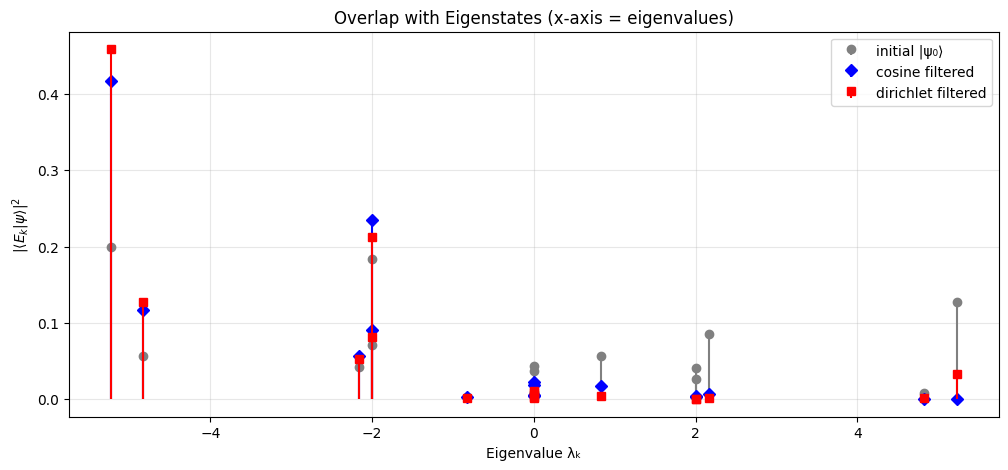

In [320]:
psi_0 = generate_random_state_with_overlap(gs, 0.2)
plot_filtered_overlaps(psi_0, H, m=1)


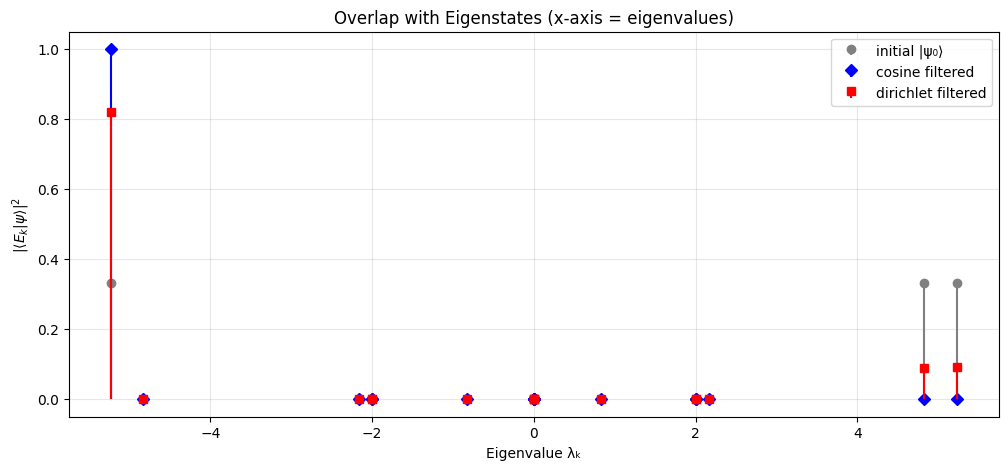

fid1 0.9999872554411069
fid2 0.8202963844848196
overlap init and gs 0.33333333333333315


In [321]:
H = qml.matrix(get_hamiltonian_pl(4, 1))
psi_0 = top_two_excited_state_vector(H)[-1]
plot_filtered_overlaps(psi_0, H, m=1)
compute_fidelities(psi_0)

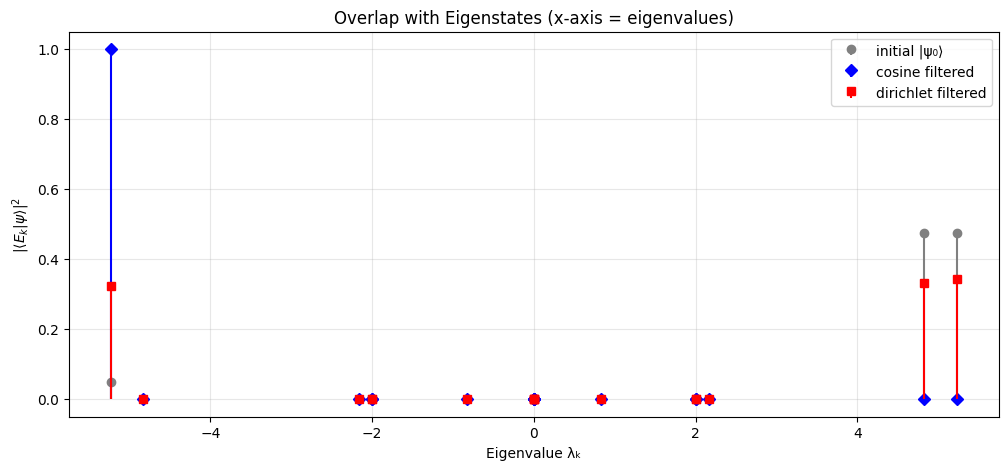

fid1 0.9998789398048195
fid2 0.32455099425228057
overlap init and gs 0.04999999999999998


In [322]:
H = qml.matrix(get_hamiltonian_pl(4, 1))
psi_0 = top_two_excited_state_vector_skewed(H)[-1]
plot_filtered_overlaps(psi_0, H, m=1)
compute_fidelities(psi_0)

## unnormalized case

In [338]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm

def plot_filtered_overlaps(psi_0, H, m=1):
    """
    Given psi_0 and Hamiltonian H,
    compute cosine-filtered and dirichlet-filtered states,
    then plot overlaps with every eigenvector of H.

    x-axis = eigenvalues (not index)
    """

    # -------------------------
    # 1. Eigendecomposition of H
    # -------------------------
    eigvals, eigvecs = np.linalg.eigh(H)

    # -------------------------
    # 2. Build shifted-normalized Hamiltonians
    # -------------------------
    H_1 = shift_and_normalize_H(H)
    H_2 = shift_and_normalize_H1(H)

    # -------------------------
    # 3. Construct the filters
    # -------------------------
    U = expm(1j * H_1)
    U_dag = expm(-1j * H_1)
    cosH = 0.5 * (U + U_dag)
    cosine_matrix = np.linalg.matrix_power(cosH, 2*m)

    dirichlet_matrix = 1/(2*m+1) * sum(
        expm(-1j * H_2 * i) for i in range(-m, m+1)
    )

    # -------------------------
    # 4. Apply filters to psi_0
    # -------------------------
    psi_cos = cosine_matrix @ psi_0
    #psi_cos /= np.linalg.norm(psi_cos)

    psi_dir = dirichlet_matrix @ psi_0
    #psi_dir /= np.linalg.norm(psi_dir)

    # -------------------------
    # 5. Compute all overlaps
    # -------------------------
    overlaps_init = np.abs(eigvecs.conj().T @ psi_0)**2
    overlaps_cos  = np.abs(eigvecs.conj().T @ psi_cos)**2
    overlaps_dir  = np.abs(eigvecs.conj().T @ psi_dir)**2

    # -------------------------
    # 6. Plot (x-axis = eigenvalues)
    # -------------------------
    plt.figure(figsize=(12,5))

    plt.stem(eigvals, overlaps_init, linefmt='gray', markerfmt='o', basefmt=" ",
             label='initial |ψ₀⟩')

    plt.stem(eigvals, overlaps_cos,  linefmt='blue', markerfmt='D', basefmt=" ",
             label='cosine filtered')

    plt.stem(eigvals, overlaps_dir,  linefmt='red', markerfmt='s', basefmt=" ",
             label='dirichlet filtered')

    plt.xlabel("Eigenvalue λₖ")
    plt.ylabel(r"$|\langle E_k | \psi\rangle|^2$")
    plt.title("Overlap with Eigenstates ")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

    return #overlaps_init, overlaps_cos, overlaps_dir

def compute_fidelities(psi_0):
    """Given psi_0, compute fidelity_1 and fidelity_2."""
    # cosine filter
    state_1 = cosine_matrix @ psi_0
    state_1 /= np.linalg.norm(state_1)
    fid1 = np.abs(np.vdot(state_1, gs))**2

    # dirichlet filter
    state_2 = dirichlet_matrix @ psi_0
    state_2 /= np.linalg.norm(state_2)
    fid2 = np.abs(np.vdot(state_2, gs))**2
    print('fid1', fid1)
    print('fid2', fid2)
    print('overlap init and gs', np.abs(np.vdot(psi_0, gs))**2)
    return



def top_two_excited_state_vector(H):
    """
    给定厄米矩阵 H，返回：
    - v1: 最高能级本征态（最大本征值）
    - v2: 次高能级本征态
    - psi: 由 v1 和 v2 等幅叠加得到的归一化态 (v1 + v2)/sqrt(2)

    H: (d, d) Hermitian matrix
    """
    # 本征分解（eigvals 升序排列）
    eigvals, eigvecs = np.linalg.eigh(H)

    # 最高和次高能级对应的索引（升序 ⇒ 最后两个就是最高的）
    idx_max = np.argsort(eigvals)  # 其实 np.linalg.eigh 已经是升序，但这样更稳
    i0 = idx_max[0]
    i1 = idx_max[-1]   # 最大本征值
    i2 = idx_max[-2]   # 次大本征值

    v0 = eigvecs[:, i0]
    v1 = eigvecs[:, i1]
    v2 = eigvecs[:, i2]

    # 等幅叠加并归一化（v1, v2 本来正交归一，直接除 sqrt(2) 就行）
    psi = (v0 + v1 + v2) / np.sqrt(3)

    return v1, v2, psi

def top_two_excited_state_vector_skewed(H, weight0=0.05):
    """
    生成一个态，使得基态 v0 权重较小（weight0），
    剩余部分平均分给最高两个激发态 v1, v2。
    """

    eigvals, eigvecs = np.linalg.eigh(H)
    idx = np.argsort(eigvals)

    i0 = idx[0]      # ground state
    i1 = idx[-1]     # highest excited
    i2 = idx[-2]     # second highest

    v0 = eigvecs[:, i0]
    v1 = eigvecs[:, i1]
    v2 = eigvecs[:, i2]

    # weights
    a0 = np.sqrt(weight0)
    a1 = np.sqrt((1 - weight0) / 2)
    a2 = np.sqrt((1 - weight0) / 2)

    psi = a0*v0 + a1*v1 + a2*v2
    psi /= np.linalg.norm(psi)

    return v0, v1, v2, psi

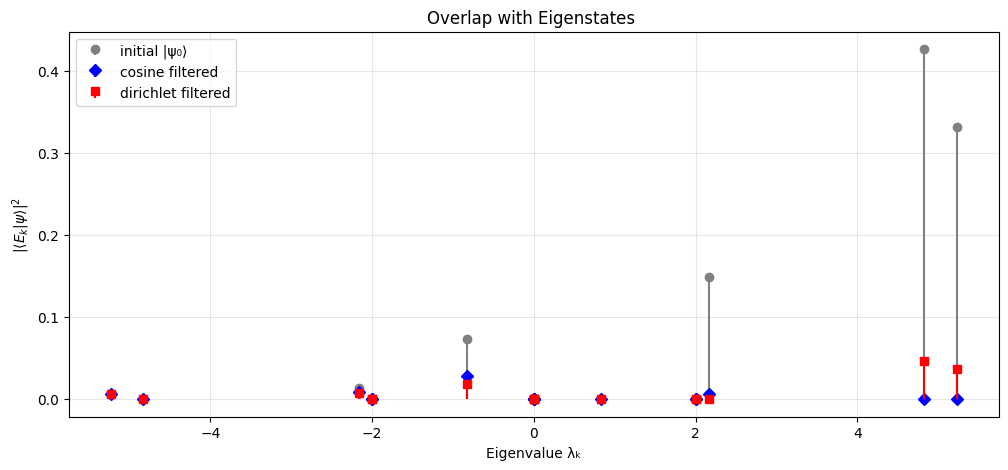

fid1 0.12093702927452778
fid2 0.05111543836342253
overlap init and gs 0.005873803214612145


In [334]:
H = qml.matrix(get_hamiltonian_pl(4, 1))

psi_0 = np.zeros(16)
psi_0[0] = 1

plot_filtered_overlaps(psi_0, H, m=1)
compute_fidelities(psi_0)

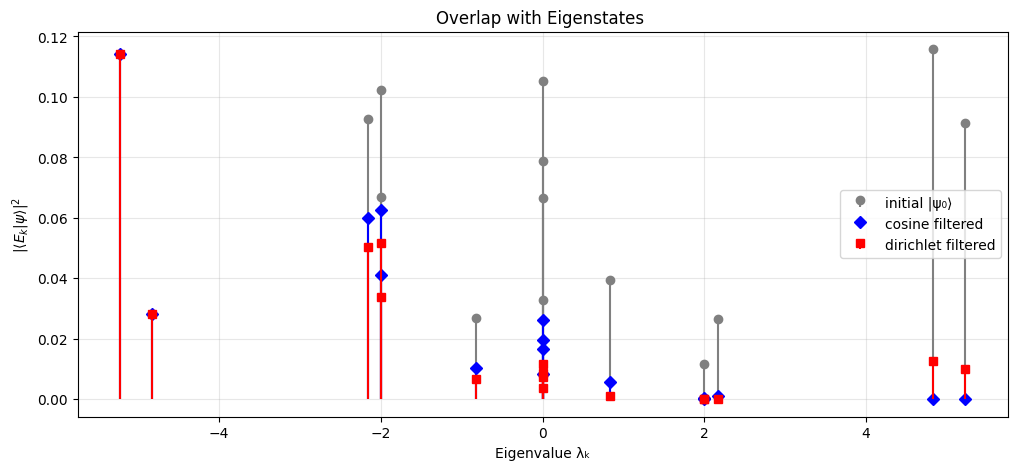

fid1 0.2898634754790301
fid2 0.3360231971964649
overlap init and gs 0.11433525170577902


In [335]:
psi_0 = np.random.randn(16) + 1j*np.random.randn(16)
psi_0 /= np.linalg.norm(psi_0)

plot_filtered_overlaps(psi_0, H, m=1)
compute_fidelities(psi_0)

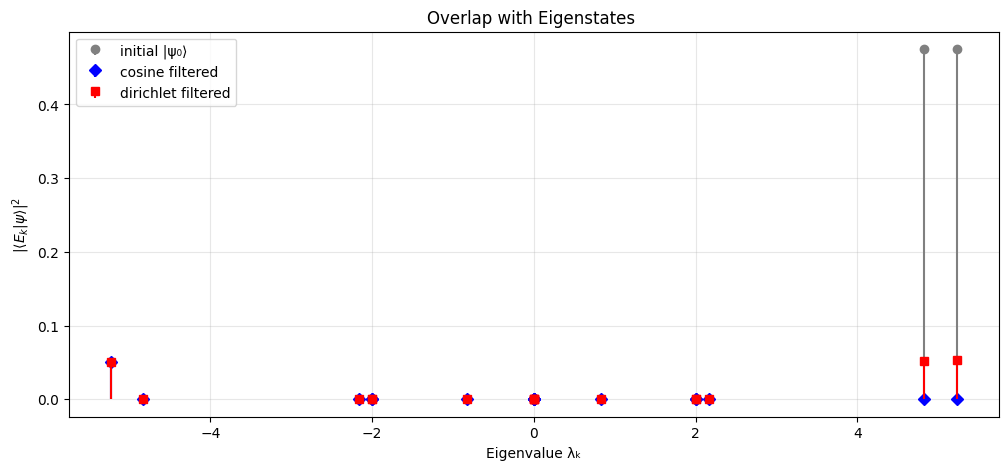

fid1 0.9998789398048195
fid2 0.32455099425228057
overlap init and gs 0.04999999999999998


In [339]:
psi_0 = top_two_excited_state_vector_skewed(H, 0.05)[-1]
plot_filtered_overlaps(psi_0, H, m=1)
compute_fidelities(psi_0)

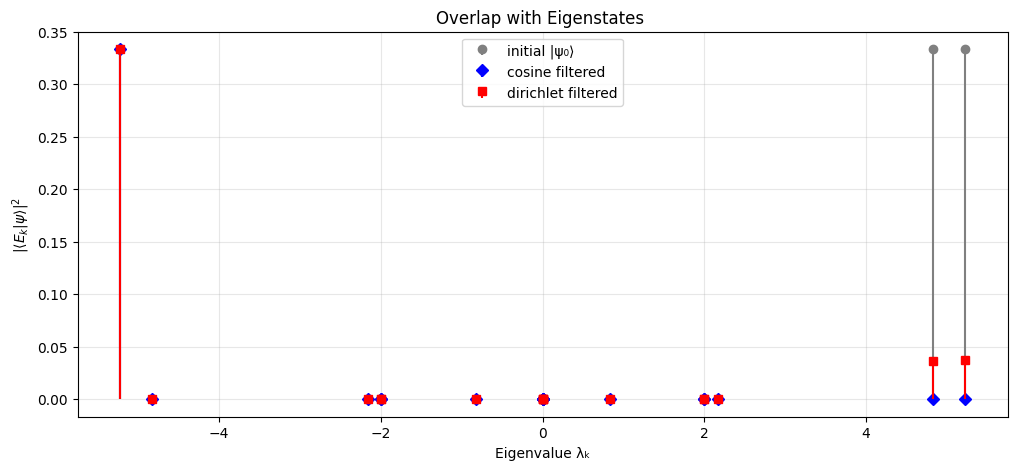

fid1 0.9999872554411064
fid2 0.8202963844848196
overlap init and gs 0.33333333333333315


In [340]:
psi_0 = top_two_excited_state_vector_skewed(H, 1/3)[-1]
plot_filtered_overlaps(psi_0, H, m=1)
compute_fidelities(psi_0)

In [245]:
cosine_matrix.dot(psi_0)

tensor([ 0.03154359+0.j, -0.04595775+0.j, -0.04595775+0.j,
         0.02879335+0.j, -0.04595775+0.j,  0.02098542+0.j,
         0.02879335+0.j, -0.00316849+0.j, -0.04595775+0.j,
         0.02879335+0.j,  0.02098542+0.j, -0.00316849+0.j,
         0.02879335+0.j, -0.00316849+0.j, -0.00316849+0.j,
        -0.00390424+0.j], requires_grad=True)

In [181]:
H_1 = qml.matrix(get_hamiltonian_pl(4, 1))
H_2 = qml.matrix(get_hamiltonian_pl(6, 1))

dev1 = qml.device("default.qubit", wires=4)
dev2 = qml.device("default.qubit", wires=6)

@qml.qnode(dev1)
def initial_state1():
    for i in range(4):
        qml.Hadamard(wires=i)
    return qml.state()

@qml.qnode(dev2)
def initial_state2():
    for i in range(6):
        qml.Hadamard(wires=i)
    return qml.state()

# init_state1 = initial_state1()
# init_state2 = initial_state2()
init_state1 = np.zeros(2**4)
init_state1[0] = 1

init_state2 = np.zeros(2**6)
init_state2[0] = 1


eigvals1, eigvecs1 = np.linalg.eigh(H_1)
groundstate_1 = eigvecs1[:, np.argmin(eigvals1)]
delta_1 = eigvals1[1] - eigvals1[0]
fid1 = np.abs(np.vdot(groundstate_1, init_state1))**2

eigvals2, eigvecs2 = np.linalg.eigh(H_2)
groundstate_2 = eigvecs2[:, np.argmin(eigvals2)]
delta_2 = eigvals2[1] - eigvals2[0]
fid2 = np.abs(np.vdot(groundstate_2, init_state2))**2
print('delta 1', delta_1)
print('delta 2', delta_2)

print('fid 1', fid1)
print('fid 2', fid2)

delta 1 0.39782473475931823
delta 2 0.2633049951747939
fid 1 0.005873803214612145
fid 2 0.00046231599435406917


In [176]:
groundstate_1.shape

(16,)

In [177]:
groundstate_2.shape

(64,)

In [180]:
groundstate_2

array([-0.02150153+0.j,  0.04919338+0.j,  0.04919338+0.j, -0.03905746+0.j,
        0.04919338+0.j, -0.14793771+0.j, -0.03905746+0.j,  0.04647747+0.j,
        0.04919338+0.j, -0.08303217+0.j, -0.14793771+0.j,  0.09429306+0.j,
       -0.03905746+0.j,  0.09429306+0.j,  0.04647747+0.j, -0.03905746+0.j,
        0.04919338+0.j, -0.14793771+0.j, -0.08303217+0.j,  0.09429306+0.j,
       -0.14793771+0.j,  0.51384906+0.j,  0.09429306+0.j, -0.14793771+0.j,
       -0.03905746+0.j,  0.09429306+0.j,  0.09429306+0.j, -0.08303217+0.j,
        0.04647747+0.j, -0.14793771+0.j, -0.03905746+0.j,  0.04919338+0.j,
        0.04919338+0.j, -0.03905746+0.j, -0.14793771+0.j,  0.04647747+0.j,
       -0.08303217+0.j,  0.09429306+0.j,  0.09429306+0.j, -0.03905746+0.j,
       -0.14793771+0.j,  0.09429306+0.j,  0.51384906+0.j, -0.14793771+0.j,
        0.09429306+0.j, -0.08303217+0.j, -0.14793771+0.j,  0.04919338+0.j,
       -0.03905746+0.j,  0.04647747+0.j,  0.09429306+0.j, -0.03905746+0.j,
        0.09429306+0.j, -

In [182]:
import numpy as np

def generate_random_state_with_overlap(gs, overlap):

    gs = gs / np.linalg.norm(gs)

    dim = len(gs)

    v = np.random.randn(dim) + 1j * np.random.randn(dim)

    proj = np.vdot(gs, v) * gs
    v_perp = v - proj

    if np.linalg.norm(v_perp) < 1e-12:
        return generate_random_state_with_overlap(gs, overlap)

    v_perp = v_perp / np.linalg.norm(v_perp)

    psi = np.sqrt(overlap) * gs + np.sqrt(1 - overlap) * v_perp
    psi = psi / np.linalg.norm(psi)

    return psi

state_tem = generate_random_state_with_overlap(groundstate_1, 0.25)
print('fid1', np.abs(np.vdot(groundstate_1, state_tem))**2)

fid1 0.24999999999999978


In [183]:
print(state_tem)

[-0.16856436-0.38054849j  0.27351752+0.01108455j  0.04890826-0.19252533j
 -0.11641605+0.07810491j  0.17784333+0.02892172j -0.08930292-0.18258415j
 -0.14639104+0.0426081j   0.10560326-0.20281096j  0.25675006-0.06933729j
 -0.05610332+0.0695811j  -0.23812877+0.12353855j  0.14898275-0.12768799j
  0.09920957-0.3749704j   0.24042538+0.12762191j  0.14312501-0.12254447j
 -0.28593604-0.11150504j]


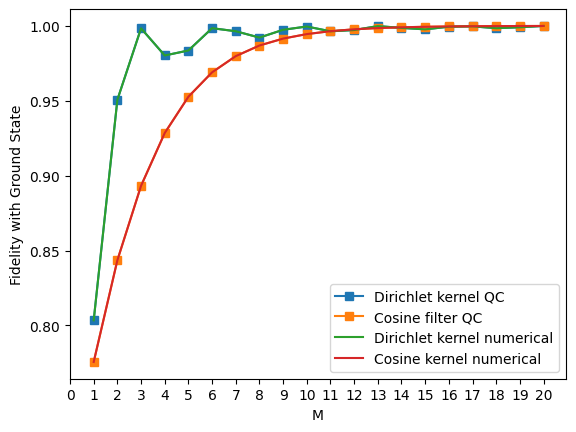

In [191]:

n = 4
dim = 2 ** n

def get_ground_state(H):
    eigvals, eigvecs = np.linalg.eigh(H)
    return eigvecs[:, np.argmin(eigvals)]

def shift_and_normalize_H(H):
    eigvals = np.linalg.eigvalsh(H)
    λ_min, λ_max = np.min(eigvals), np.max(eigvals)
    H_norm = (H - λ_min * np.eye(len(H))) / (λ_max - λ_min) * np.pi /2
    λ0 = np.min(np.linalg.eigvalsh(H_norm))
    H_shifted = H_norm - λ0 * np.eye(len(H))
    return H_shifted

def shift_and_normalize_H1(H):
    eigvals = np.linalg.eigvalsh(H)
    λ_min, λ_max = np.min(eigvals), np.max(eigvals)
    H_norm = (H - λ_min * np.eye(len(H))) / (λ_max - λ_min) * np.pi
    λ0 = np.min(np.linalg.eigvalsh(H_norm))
    H_shifted = H_norm - λ0 * np.eye(len(H))
    return H_shifted

def generate_random_state_with_overlap(gs, overlap):

    gs = gs / np.linalg.norm(gs)

    dim = len(gs)

    v = np.random.randn(dim) + 1j * np.random.randn(dim)

    proj = np.vdot(gs, v) * gs
    v_perp = v - proj

    if np.linalg.norm(v_perp) < 1e-12:
        return generate_random_state_with_overlap(gs, overlap)

    v_perp = v_perp / np.linalg.norm(v_perp)

    psi = np.sqrt(overlap) * gs + np.sqrt(1 - overlap) * v_perp
    psi = psi / np.linalg.norm(psi)

    return psi

def kron_n(op_list):
    result = np.array([[1]])
    for op in op_list:
        result = np.kron(result, op)
    return result

# TFIM Hamiltonian
def tfim_model(n):
    dim = 2 ** n
    H = np.zeros((dim, dim), dtype=np.complex128)
    Z = np.array([[1, 0], [0, -1]])
    X = np.array([[0, 1], [1, 0]])
    I = np.eye(2)
    for i in range(n):
        Zi = [I] * n
        Zi[i] = Z
        Zi[(i + 1) % n] = Z
        H -= kron_n(Zi)
        Xi = [I] * n
        Xi[i] = X
        H -= kron_n(Xi)
    return H



# 归一化并 shift
H = tfim_model(n)
H_shifted = shift_and_normalize_H(H)
ground_state = get_ground_state(H_shifted)
init_state = np.ones(dim) / np.sqrt(dim)
#init_state = generate_random_state_with_overlap(ground_state, 1/n)


H_shifted1 = shift_and_normalize_H1(H)
def dirichlet_block_encoding(max_N):
    k_vals_full = np.arange(-max_N, max_N + 1)
    alpha_k = np.array([1/(2* max_N + 1) for k in k_vals_full])

    pad_len = 2 ** int(np.ceil(np.log2(len(alpha_k))))
    alpha_padded = np.zeros(pad_len)
    alpha_padded[:len(alpha_k)] = alpha_k
    weights = np.sqrt(alpha_padded / np.sum(alpha_padded))
    #weights = alpha_padded
    #print('weights:', weights)
    n_anc = int(np.log2(pad_len))
    ancilla_wires = list(range(n_anc))
    system_wires = list(range(n_anc, n_anc + n))
    U_list = [expm(-1.0j * k * H_shifted1) for k in k_vals_full]
    U_list += [np.eye(dim)] * (pad_len - len(U_list))
    U_ops = [qml.QubitUnitary(U, wires=range(n_anc, n_anc + n)) for U in U_list]
    dev = qml.device("default.qubit", wires=n + n_anc)

    @qml.qnode(dev)
    def block_encoding():
        # for i in system_wires:
        #     qml.Hadamard(i)
        qml.StatePrep(init_state, wires=range(n_anc, n+n_anc))
        # for i in range(n_anc, n+n_anc, 2):
        #     qml.X(i)
        qml.StatePrep(weights, wires=range(n_anc))
        qml.Select(U_ops, control=range(n_anc))
        qml.adjoint(qml.StatePrep)(weights, wires=range(n_anc))
        return qml.state()

    # U_be = qml.matrix(block_encoding, wire_order=list(range(n_anc)) + list(range(n_anc, n_anc + n)))()
    # A_block = U_be[:dim, :dim]
    # be_state = A_block @ init_state
    full_state = block_encoding()
    reshaped = full_state.reshape((2 ** n_anc, 2 ** n))
    system_state = reshaped[0, :]
    be_state = system_state

    success_prob = np.sum(np.abs(be_state) ** 2)
    be_state /= np.linalg.norm(be_state)
    fidelity = np.abs(np.vdot(be_state, ground_state)) ** 2
    return fidelity, success_prob


def fidelity_block_encoding(m):
    k_vals_full = np.arange(-m, m + 1)
    alpha_k_full = 2 ** (-2 * m) * np.array([math.comb(2 * m, m + k) for k in k_vals_full])
    keep = [i for i in range(len(alpha_k_full)) if alpha_k_full[i] > 1e-4]
    alpha_k = alpha_k_full[keep]
    k_vals = k_vals_full[keep]
    alpha_k /= np.sum(alpha_k)
    pad_len = 2 ** int(np.ceil(np.log2(len(alpha_k))))
    alpha_padded = np.zeros(pad_len)
    alpha_padded[:len(alpha_k)] = alpha_k
    weights = np.sqrt(alpha_padded / np.sum(alpha_padded))
    n_anc = int(np.log2(pad_len))
    ancilla_wires = list(range(n_anc))
    system_wires = list(range(n_anc, n_anc + n))
    U_list = [expm(2j * k * H_shifted) for k in k_vals]
    U_list += [np.eye(dim)] * (pad_len - len(U_list))
    U_ops = [qml.QubitUnitary(U, wires=range(n_anc, n_anc + n)) for U in U_list]
    dev = qml.device("default.qubit", wires=n + n_anc)

    @qml.qnode(dev)
    def block_encoding():
        # for i in system_wires:
        #     qml.Hadamard(i)
        qml.StatePrep(init_state, wires=range(n_anc, n+n_anc))
        # for i in range(n_anc, n+n_anc, 2):
        #     qml.X(i)
        qml.StatePrep(weights, wires=range(n_anc))
        qml.Select(U_ops, control=range(n_anc))
        qml.adjoint(qml.StatePrep)(weights, wires=range(n_anc))
        return qml.state()

    # U_be = qml.matrix(block_encoding, wire_order=list(range(n_anc)) + list(range(n_anc, n_anc + n)))()
    # A_block = U_be[:dim, :dim]
    # be_state = A_block @ init_state
    full_state = block_encoding()
    reshaped = full_state.reshape((2 ** n_anc, 2 ** n))
    system_state = reshaped[0, :]
    be_state = system_state

    success_prob = np.sum(np.abs(be_state) ** 2)
    be_state /= np.linalg.norm(be_state)
    fidelity = np.abs(np.vdot(be_state, ground_state)) ** 2
    return fidelity, success_prob

def cosine_filter_matrix(H, m):
    U = expm(1j * H)
    U_dag = expm(-1j * H)
    cosH = 0.5 * (U + U_dag)
    return np.linalg.matrix_power(cosH, 2*m)

def custom_filter_matrix(H, N):
    return 1/(2*N+1) * sum(expm(-1j * H * i) for i in range(-N, N + 1)) #/ N  # corrected j = N+1 to 2N

def evaluate_fidelity(filter_matrix, init_state, H_shifted):
    psi = filter_matrix @ init_state
    psi /= np.linalg.norm(psi)
    return np.abs(np.vdot(psi, ground_state)) ** 2
    #return np.linalg.norm(psi-ground_state)**2
    #return float(np.real_if_close(np.vdot(psi, H_shifted@psi)))



# 扫描 m
max_N = 20
m_vals = list(range(1, max_N + 1))
fidelity_cosine, success_cosine = zip(*[fidelity_block_encoding(m) for m in list(range(1, max_N+1))])#list(range(1, max_N//2 + 1))])

N_list = list(range(1, max_N + 1))
fidelity_be, success_be = zip(*[dirichlet_block_encoding(N) for N in N_list])


# Fidelity for custom filter as N varies
fidelity_list = []
for N_iter in range(1, max_N + 1):
    H_shifted = shift_and_normalize_H1(H)
    fH = custom_filter_matrix(H_shifted, N_iter)
    fidelity_custom = evaluate_fidelity(fH, init_state, H)
    fidelity_list.append(fidelity_custom)

fidelity_cos_list = []
for m_vals in range(1,max_N+1):
    H_shifted = shift_and_normalize_H(H)
    cos_filter = cosine_filter_matrix(H_shifted, m_vals)
    fidelity_cos = evaluate_fidelity(cos_filter, init_state, H)
    fidelity_cos_list.append(fidelity_cos)


plt.plot(N_list, fidelity_be, marker='s', label='Dirichlet kernel QC')
#plt.plot(list(range(1, max_N + 1, 2)), fidelity_cosine, marker='s', label='Cosine filter')
plt.plot(list(range(1, max_N + 1)), fidelity_cosine, marker='s', label='Cosine filter QC')

plt.plot(range(1, max_N + 1), fidelity_list, label="Dirichlet kernel numerical")
#plt.axhline(y=fidelity_cos, color='r', linestyle='--', label="cos^{2m}(H) Fidelity")
plt.plot(list(range(1, max_N+1)), fidelity_cos_list, label='Cosine kernel numerical')

plt.xlabel("M")
plt.xticks(list(range(0, max_N + 1)))
plt.ylabel("Fidelity with Ground State")
#plt.title("Fidelity vs. m")
plt.legend()
#plt.grid(True)
#plt.savefig("cosine compare with dirichlet n6.png")
plt.show()

In [192]:
print('overlap is', abs(np.vdot(init_state, ground_state)**2))

overlap is 0.6650290888674117


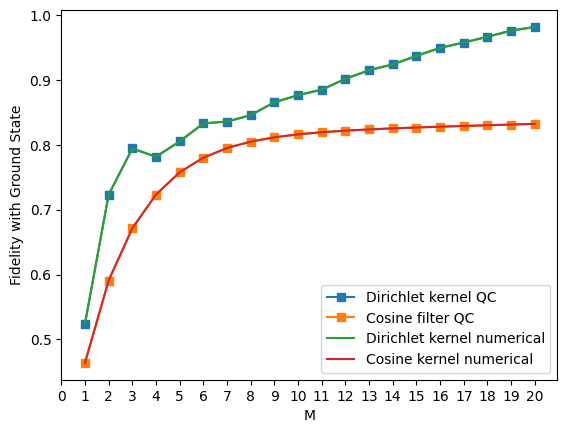

In [188]:

n = 4
dim = 2 ** n

def get_ground_state(H):
    eigvals, eigvecs = np.linalg.eigh(H)
    return eigvecs[:, np.argmin(eigvals)]

def shift_and_normalize_H(H):
    eigvals = np.linalg.eigvalsh(H)
    λ_min, λ_max = np.min(eigvals), np.max(eigvals)
    H_norm = (H - λ_min * np.eye(len(H))) / (λ_max - λ_min) * np.pi /2
    λ0 = np.min(np.linalg.eigvalsh(H_norm))
    H_shifted = H_norm - λ0 * np.eye(len(H))
    return H_shifted

def shift_and_normalize_H1(H):
    eigvals = np.linalg.eigvalsh(H)
    λ_min, λ_max = np.min(eigvals), np.max(eigvals)
    H_norm = (H - λ_min * np.eye(len(H))) / (λ_max - λ_min) * np.pi
    λ0 = np.min(np.linalg.eigvalsh(H_norm))
    H_shifted = H_norm - λ0 * np.eye(len(H))
    return H_shifted

def generate_random_state_with_overlap(gs, overlap):

    gs = gs / np.linalg.norm(gs)

    dim = len(gs)

    v = np.random.randn(dim) + 1j * np.random.randn(dim)

    proj = np.vdot(gs, v) * gs
    v_perp = v - proj

    if np.linalg.norm(v_perp) < 1e-12:
        return generate_random_state_with_overlap(gs, overlap)

    v_perp = v_perp / np.linalg.norm(v_perp)

    psi = np.sqrt(overlap) * gs + np.sqrt(1 - overlap) * v_perp
    psi = psi / np.linalg.norm(psi)

    return psi

def kron_n(op_list):
    result = np.array([[1]])
    for op in op_list:
        result = np.kron(result, op)
    return result

# TFIM Hamiltonian
def tfim_model(n):
    dim = 2 ** n
    H = np.zeros((dim, dim), dtype=np.complex128)
    Z = np.array([[1, 0], [0, -1]])
    X = np.array([[0, 1], [1, 0]])
    I = np.eye(2)
    for i in range(n):
        Zi = [I] * n
        Zi[i] = Z
        Zi[(i + 1) % n] = Z
        H -= kron_n(Zi)
        Xi = [I] * n
        Xi[i] = X
        H -= kron_n(Xi)
    return H



# 归一化并 shift
H = tfim_model(n)
H_shifted = shift_and_normalize_H(H)
ground_state = get_ground_state(H_shifted)
#init_state = np.ones(dim) / np.sqrt(dim)
init_state = generate_random_state_with_overlap(ground_state, 1/n)


H_shifted1 = shift_and_normalize_H1(H)
def dirichlet_block_encoding(max_N):
    k_vals_full = np.arange(-max_N, max_N + 1)
    alpha_k = np.array([1/(2* max_N + 1) for k in k_vals_full])

    pad_len = 2 ** int(np.ceil(np.log2(len(alpha_k))))
    alpha_padded = np.zeros(pad_len)
    alpha_padded[:len(alpha_k)] = alpha_k
    weights = np.sqrt(alpha_padded / np.sum(alpha_padded))
    #weights = alpha_padded
    #print('weights:', weights)
    n_anc = int(np.log2(pad_len))
    ancilla_wires = list(range(n_anc))
    system_wires = list(range(n_anc, n_anc + n))
    U_list = [expm(-1.0j * k * H_shifted1) for k in k_vals_full]
    U_list += [np.eye(dim)] * (pad_len - len(U_list))
    U_ops = [qml.QubitUnitary(U, wires=range(n_anc, n_anc + n)) for U in U_list]
    dev = qml.device("default.qubit", wires=n + n_anc)

    @qml.qnode(dev)
    def block_encoding():
        # for i in system_wires:
        #     qml.Hadamard(i)
        qml.StatePrep(init_state, wires=range(n_anc, n+n_anc))
        # for i in range(n_anc, n+n_anc, 2):
        #     qml.X(i)
        qml.StatePrep(weights, wires=range(n_anc))
        qml.Select(U_ops, control=range(n_anc))
        qml.adjoint(qml.StatePrep)(weights, wires=range(n_anc))
        return qml.state()

    # U_be = qml.matrix(block_encoding, wire_order=list(range(n_anc)) + list(range(n_anc, n_anc + n)))()
    # A_block = U_be[:dim, :dim]
    # be_state = A_block @ init_state
    full_state = block_encoding()
    reshaped = full_state.reshape((2 ** n_anc, 2 ** n))
    system_state = reshaped[0, :]
    be_state = system_state

    success_prob = np.sum(np.abs(be_state) ** 2)
    be_state /= np.linalg.norm(be_state)
    fidelity = np.abs(np.vdot(be_state, ground_state)) ** 2
    return fidelity, success_prob


def fidelity_block_encoding(m):
    k_vals_full = np.arange(-m, m + 1)
    alpha_k_full = 2 ** (-2 * m) * np.array([math.comb(2 * m, m + k) for k in k_vals_full])
    keep = [i for i in range(len(alpha_k_full)) if alpha_k_full[i] > 1e-4]
    alpha_k = alpha_k_full[keep]
    k_vals = k_vals_full[keep]
    alpha_k /= np.sum(alpha_k)
    pad_len = 2 ** int(np.ceil(np.log2(len(alpha_k))))
    alpha_padded = np.zeros(pad_len)
    alpha_padded[:len(alpha_k)] = alpha_k
    weights = np.sqrt(alpha_padded / np.sum(alpha_padded))
    n_anc = int(np.log2(pad_len))
    ancilla_wires = list(range(n_anc))
    system_wires = list(range(n_anc, n_anc + n))
    U_list = [expm(2j * k * H_shifted) for k in k_vals]
    U_list += [np.eye(dim)] * (pad_len - len(U_list))
    U_ops = [qml.QubitUnitary(U, wires=range(n_anc, n_anc + n)) for U in U_list]
    dev = qml.device("default.qubit", wires=n + n_anc)

    @qml.qnode(dev)
    def block_encoding():
        # for i in system_wires:
        #     qml.Hadamard(i)
        qml.StatePrep(init_state, wires=range(n_anc, n+n_anc))
        # for i in range(n_anc, n+n_anc, 2):
        #     qml.X(i)
        qml.StatePrep(weights, wires=range(n_anc))
        qml.Select(U_ops, control=range(n_anc))
        qml.adjoint(qml.StatePrep)(weights, wires=range(n_anc))
        return qml.state()

    # U_be = qml.matrix(block_encoding, wire_order=list(range(n_anc)) + list(range(n_anc, n_anc + n)))()
    # A_block = U_be[:dim, :dim]
    # be_state = A_block @ init_state
    full_state = block_encoding()
    reshaped = full_state.reshape((2 ** n_anc, 2 ** n))
    system_state = reshaped[0, :]
    be_state = system_state

    success_prob = np.sum(np.abs(be_state) ** 2)
    be_state /= np.linalg.norm(be_state)
    fidelity = np.abs(np.vdot(be_state, ground_state)) ** 2
    return fidelity, success_prob

def cosine_filter_matrix(H, m):
    U = expm(1j * H)
    U_dag = expm(-1j * H)
    cosH = 0.5 * (U + U_dag)
    return np.linalg.matrix_power(cosH, 2*m)

def custom_filter_matrix(H, N):
    return 1/(2*N+1) * sum(expm(-1j * H * i) for i in range(-N, N + 1)) #/ N  # corrected j = N+1 to 2N

def evaluate_fidelity(filter_matrix, init_state, H_shifted):
    psi = filter_matrix @ init_state
    psi /= np.linalg.norm(psi)
    return np.abs(np.vdot(psi, ground_state)) ** 2
    #return np.linalg.norm(psi-ground_state)**2
    #return float(np.real_if_close(np.vdot(psi, H_shifted@psi)))



# 扫描 m
max_N = 20
m_vals = list(range(1, max_N + 1))
fidelity_cosine, success_cosine = zip(*[fidelity_block_encoding(m) for m in list(range(1, max_N+1))])#list(range(1, max_N//2 + 1))])

N_list = list(range(1, max_N + 1))
fidelity_be, success_be = zip(*[dirichlet_block_encoding(N) for N in N_list])


# Fidelity for custom filter as N varies
fidelity_list = []
for N_iter in range(1, max_N + 1):
    H_shifted = shift_and_normalize_H1(H)
    fH = custom_filter_matrix(H_shifted, N_iter)
    fidelity_custom = evaluate_fidelity(fH, init_state, H)
    fidelity_list.append(fidelity_custom)

fidelity_cos_list = []
for m_vals in range(1,max_N+1):
    H_shifted = shift_and_normalize_H(H)
    cos_filter = cosine_filter_matrix(H_shifted, m_vals)
    fidelity_cos = evaluate_fidelity(cos_filter, init_state, H)
    fidelity_cos_list.append(fidelity_cos)


plt.plot(N_list, fidelity_be, marker='s', label='Dirichlet kernel QC')
#plt.plot(list(range(1, max_N + 1, 2)), fidelity_cosine, marker='s', label='Cosine filter')
plt.plot(list(range(1, max_N + 1)), fidelity_cosine, marker='s', label='Cosine filter QC')

plt.plot(range(1, max_N + 1), fidelity_list, label="Dirichlet kernel numerical")
#plt.axhline(y=fidelity_cos, color='r', linestyle='--', label="cos^{2m}(H) Fidelity")
plt.plot(list(range(1, max_N+1)), fidelity_cos_list, label='Cosine kernel numerical')

plt.xlabel("M")
plt.xticks(list(range(0, max_N + 1)))
plt.ylabel("Fidelity with Ground State")
#plt.title("Fidelity vs. m")
plt.legend()
#plt.grid(True)
#plt.savefig("cosine compare with dirichlet n6.png")
plt.show()

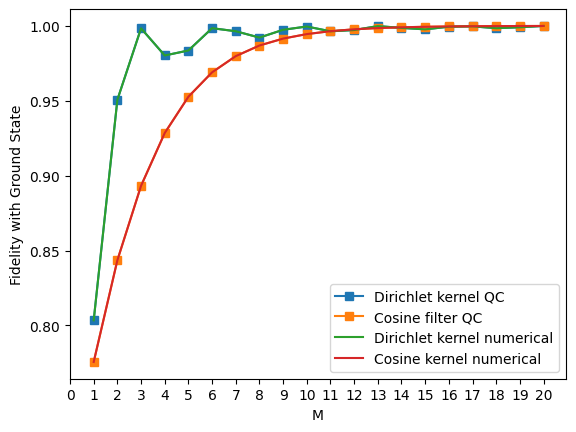

In [22]:
#

n = 4
dim = 2 ** n

def get_ground_state(H):
    eigvals, eigvecs = np.linalg.eigh(H)
    return eigvecs[:, np.argmin(eigvals)]

def shift_and_normalize_H(H):
    eigvals = np.linalg.eigvalsh(H)
    λ_min, λ_max = np.min(eigvals), np.max(eigvals)
    H_norm = (H - λ_min * np.eye(len(H))) / (λ_max - λ_min) * np.pi /2
    λ0 = np.min(np.linalg.eigvalsh(H_norm))
    H_shifted = H_norm - λ0 * np.eye(len(H))
    return H_shifted

def shift_and_normalize_H1(H):
    eigvals = np.linalg.eigvalsh(H)
    λ_min, λ_max = np.min(eigvals), np.max(eigvals)
    H_norm = (H - λ_min * np.eye(len(H))) / (λ_max - λ_min) * np.pi
    λ0 = np.min(np.linalg.eigvalsh(H_norm))
    H_shifted = H_norm - λ0 * np.eye(len(H))
    return H_shifted

def generate_random_state_with_overlap(gs, overlap):

    gs = gs / np.linalg.norm(gs)

    dim = len(gs)

    v = np.random.randn(dim) + 1j * np.random.randn(dim)

    proj = np.vdot(gs, v) * gs
    v_perp = v - proj

    if np.linalg.norm(v_perp) < 1e-12:
        return generate_random_state_with_overlap(gs, overlap)

    v_perp = v_perp / np.linalg.norm(v_perp)

    psi = np.sqrt(overlap) * gs + np.sqrt(1 - overlap) * v_perp
    psi = psi / np.linalg.norm(psi)

    return psi

def kron_n(op_list):
    result = np.array([[1]])
    for op in op_list:
        result = np.kron(result, op)
    return result

# TFIM Hamiltonian
def tfim_model(n):
    dim = 2 ** n
    H = np.zeros((dim, dim), dtype=np.complex128)
    Z = np.array([[1, 0], [0, -1]])
    X = np.array([[0, 1], [1, 0]])
    I = np.eye(2)
    for i in range(n):
        Zi = [I] * n
        Zi[i] = Z
        Zi[(i + 1) % n] = Z
        H -= kron_n(Zi)
        Xi = [I] * n
        Xi[i] = X
        H -= kron_n(Xi)
    return H



# 归一化并 shift
H = tfim_model(n)
#H = qml.matrix(get_hamiltonian_pl(4, 1))
H_shifted = shift_and_normalize_H(H)
ground_state = get_ground_state(H_shifted)
init_state = np.ones(dim) / np.sqrt(dim)
#init_state = generate_random_state_with_overlap(ground_state, 1/n)


H_shifted1 = shift_and_normalize_H1(H)
def dirichlet_block_encoding(max_N):
    k_vals_full = np.arange(-max_N, max_N + 1)
    alpha_k = np.array([1/(2* max_N + 1) for k in k_vals_full])

    pad_len = 2 ** int(np.ceil(np.log2(len(alpha_k))))
    alpha_padded = np.zeros(pad_len)
    alpha_padded[:len(alpha_k)] = alpha_k
    weights = np.sqrt(alpha_padded / np.sum(alpha_padded))
    #weights = alpha_padded
    #print('weights:', weights)
    n_anc = int(np.log2(pad_len))
    ancilla_wires = list(range(n_anc))
    system_wires = list(range(n_anc, n_anc + n))
    U_list = [expm(-1.0j * k * H_shifted1) for k in k_vals_full]
    U_list += [np.eye(dim)] * (pad_len - len(U_list))
    U_ops = [qml.QubitUnitary(U, wires=range(n_anc, n_anc + n)) for U in U_list]
    dev = qml.device("default.qubit", wires=n + n_anc)

    @qml.qnode(dev)
    def block_encoding():
        # for i in system_wires:
        #     qml.Hadamard(i)
        qml.StatePrep(init_state, wires=range(n_anc, n+n_anc))
        # for i in range(n_anc, n+n_anc, 2):
        #     qml.X(i)
        qml.StatePrep(weights, wires=range(n_anc))
        qml.Select(U_ops, control=range(n_anc))
        qml.adjoint(qml.StatePrep)(weights, wires=range(n_anc))
        return qml.state()

    # U_be = qml.matrix(block_encoding, wire_order=list(range(n_anc)) + list(range(n_anc, n_anc + n)))()
    # A_block = U_be[:dim, :dim]
    # be_state = A_block @ init_state
    full_state = block_encoding()
    reshaped = full_state.reshape((2 ** n_anc, 2 ** n))
    system_state = reshaped[0, :]
    be_state = system_state

    success_prob = np.sum(np.abs(be_state) ** 2)
    be_state /= np.linalg.norm(be_state)
    fidelity = np.abs(np.vdot(be_state, ground_state)) ** 2
    return fidelity, success_prob


def fidelity_block_encoding(m):
    k_vals_full = np.arange(-m, m + 1)
    alpha_k_full = 2 ** (-2 * m) * np.array([math.comb(2 * m, m + k) for k in k_vals_full])
    keep = [i for i in range(len(alpha_k_full)) if alpha_k_full[i] > 1e-4]
    alpha_k = alpha_k_full[keep]
    k_vals = k_vals_full[keep]
    alpha_k /= np.sum(alpha_k)
    pad_len = 2 ** int(np.ceil(np.log2(len(alpha_k))))
    alpha_padded = np.zeros(pad_len)
    alpha_padded[:len(alpha_k)] = alpha_k
    weights = np.sqrt(alpha_padded / np.sum(alpha_padded))
    n_anc = int(np.log2(pad_len))
    ancilla_wires = list(range(n_anc))
    system_wires = list(range(n_anc, n_anc + n))
    U_list = [expm(2j * k * H_shifted) for k in k_vals]
    U_list += [np.eye(dim)] * (pad_len - len(U_list))
    U_ops = [qml.QubitUnitary(U, wires=range(n_anc, n_anc + n)) for U in U_list]
    dev = qml.device("default.qubit", wires=n + n_anc)

    @qml.qnode(dev)
    def block_encoding():
        # for i in system_wires:
        #     qml.Hadamard(i)
        qml.StatePrep(init_state, wires=range(n_anc, n+n_anc))
        # for i in range(n_anc, n+n_anc, 2):
        #     qml.X(i)
        qml.StatePrep(weights, wires=range(n_anc))
        qml.Select(U_ops, control=range(n_anc))
        qml.adjoint(qml.StatePrep)(weights, wires=range(n_anc))
        return qml.state()

    # U_be = qml.matrix(block_encoding, wire_order=list(range(n_anc)) + list(range(n_anc, n_anc + n)))()
    # A_block = U_be[:dim, :dim]
    # be_state = A_block @ init_state
    full_state = block_encoding()
    reshaped = full_state.reshape((2 ** n_anc, 2 ** n))
    system_state = reshaped[0, :]
    be_state = system_state

    success_prob = np.sum(np.abs(be_state) ** 2)
    be_state /= np.linalg.norm(be_state)
    fidelity = np.abs(np.vdot(be_state, ground_state)) ** 2
    return fidelity, success_prob

def cosine_filter_matrix(H, m):
    U = expm(1j * H)
    U_dag = expm(-1j * H)
    cosH = 0.5 * (U + U_dag)
    return np.linalg.matrix_power(cosH, 2*m)

def custom_filter_matrix(H, N):
    return 1/(2*N+1) * sum(expm(-1j * H * i) for i in range(-N, N + 1)) #/ N  # corrected j = N+1 to 2N

def evaluate_fidelity(filter_matrix, init_state, H_shifted):
    psi = filter_matrix @ init_state
    psi /= np.linalg.norm(psi)
    return np.abs(np.vdot(psi, ground_state)) ** 2
    #return np.linalg.norm(psi-ground_state)**2
    #return float(np.real_if_close(np.vdot(psi, H_shifted@psi)))



# 扫描 m
max_N = 20
m_vals = list(range(1, max_N + 1))
fidelity_cosine, success_cosine = zip(*[fidelity_block_encoding(m) for m in list(range(1, max_N+1))])#list(range(1, max_N//2 + 1))])

N_list = list(range(1, max_N + 1))
fidelity_be, success_be = zip(*[dirichlet_block_encoding(N) for N in N_list])


# Fidelity for custom filter as N varies
fidelity_list = []
for N_iter in range(1, max_N + 1):
    H_shifted = shift_and_normalize_H1(H)
    fH = custom_filter_matrix(H_shifted, N_iter)
    fidelity_custom = evaluate_fidelity(fH, init_state, H)
    fidelity_list.append(fidelity_custom)

fidelity_cos_list = []
for m_vals in range(1,max_N+1):
    H_shifted = shift_and_normalize_H(H)
    cos_filter = cosine_filter_matrix(H_shifted, m_vals)
    fidelity_cos = evaluate_fidelity(cos_filter, init_state, H)
    fidelity_cos_list.append(fidelity_cos)


plt.plot(N_list, fidelity_be, marker='s', label='Dirichlet kernel QC')
#plt.plot(list(range(1, max_N + 1, 2)), fidelity_cosine, marker='s', label='Cosine filter')
plt.plot(list(range(1, max_N + 1)), fidelity_cosine, marker='s', label='Cosine filter QC')

plt.plot(range(1, max_N + 1), fidelity_list, label="Dirichlet kernel numerical")
#plt.axhline(y=fidelity_cos, color='r', linestyle='--', label="cos^{2m}(H) Fidelity")
plt.plot(list(range(1, max_N+1)), fidelity_cos_list, label='Cosine kernel numerical')

plt.xlabel("M")
plt.xticks(list(range(0, max_N + 1)))
plt.ylabel("Fidelity with Ground State")
#plt.title("Fidelity vs. m")
plt.legend()
#plt.grid(True)
#plt.savefig("cosine compare with dirichlet n6.png")
plt.show()

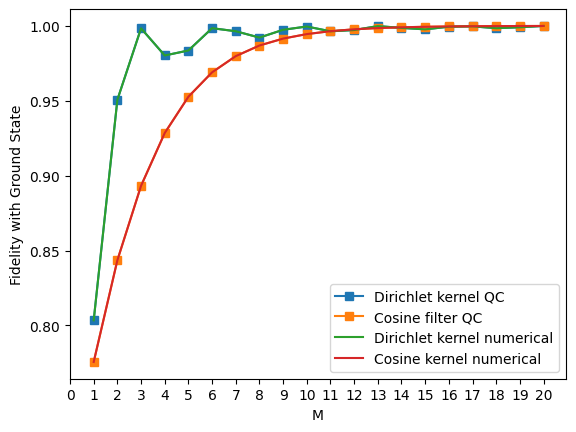

In [23]:
#

n = 4
dim = 2 ** n

def get_ground_state(H):
    eigvals, eigvecs = np.linalg.eigh(H)
    return eigvecs[:, np.argmin(eigvals)]

def shift_and_normalize_H(H):
    eigvals = np.linalg.eigvalsh(H)
    λ_min, λ_max = np.min(eigvals), np.max(eigvals)
    H_norm = (H - λ_min * np.eye(len(H))) / (λ_max - λ_min) * np.pi /2
    λ0 = np.min(np.linalg.eigvalsh(H_norm))
    H_shifted = H_norm - λ0 * np.eye(len(H))
    return H_shifted

def shift_and_normalize_H1(H):
    eigvals = np.linalg.eigvalsh(H)
    λ_min, λ_max = np.min(eigvals), np.max(eigvals)
    H_norm = (H - λ_min * np.eye(len(H))) / (λ_max - λ_min) * np.pi
    λ0 = np.min(np.linalg.eigvalsh(H_norm))
    H_shifted = H_norm - λ0 * np.eye(len(H))
    return H_shifted

def generate_random_state_with_overlap(gs, overlap):

    gs = gs / np.linalg.norm(gs)

    dim = len(gs)

    v = np.random.randn(dim) + 1j * np.random.randn(dim)

    proj = np.vdot(gs, v) * gs
    v_perp = v - proj

    if np.linalg.norm(v_perp) < 1e-12:
        return generate_random_state_with_overlap(gs, overlap)

    v_perp = v_perp / np.linalg.norm(v_perp)

    psi = np.sqrt(overlap) * gs + np.sqrt(1 - overlap) * v_perp
    psi = psi / np.linalg.norm(psi)

    return psi

def kron_n(op_list):
    result = np.array([[1]])
    for op in op_list:
        result = np.kron(result, op)
    return result

# TFIM Hamiltonian
def tfim_model(n):
    dim = 2 ** n
    H = np.zeros((dim, dim), dtype=np.complex128)
    Z = np.array([[1, 0], [0, -1]])
    X = np.array([[0, 1], [1, 0]])
    I = np.eye(2)
    for i in range(n):
        Zi = [I] * n
        Zi[i] = Z
        Zi[(i + 1) % n] = Z
        H -= kron_n(Zi)
        Xi = [I] * n
        Xi[i] = X
        H -= kron_n(Xi)
    return H



# 归一化并 shift
#H = tfim_model(n)
H = qml.matrix(get_hamiltonian_pl(4, -1))
H_shifted = shift_and_normalize_H(H)
ground_state = get_ground_state(H_shifted)
init_state = np.ones(dim) / np.sqrt(dim)
#init_state = generate_random_state_with_overlap(ground_state, 1/n)


H_shifted1 = shift_and_normalize_H1(H)
def dirichlet_block_encoding(max_N):
    k_vals_full = np.arange(-max_N, max_N + 1)
    alpha_k = np.array([1/(2* max_N + 1) for k in k_vals_full])

    pad_len = 2 ** int(np.ceil(np.log2(len(alpha_k))))
    alpha_padded = np.zeros(pad_len)
    alpha_padded[:len(alpha_k)] = alpha_k
    weights = np.sqrt(alpha_padded / np.sum(alpha_padded))
    #weights = alpha_padded
    #print('weights:', weights)
    n_anc = int(np.log2(pad_len))
    ancilla_wires = list(range(n_anc))
    system_wires = list(range(n_anc, n_anc + n))
    U_list = [expm(-1.0j * k * H_shifted1) for k in k_vals_full]
    U_list += [np.eye(dim)] * (pad_len - len(U_list))
    U_ops = [qml.QubitUnitary(U, wires=range(n_anc, n_anc + n)) for U in U_list]
    dev = qml.device("default.qubit", wires=n + n_anc)

    @qml.qnode(dev)
    def block_encoding():
        # for i in system_wires:
        #     qml.Hadamard(i)
        qml.StatePrep(init_state, wires=range(n_anc, n+n_anc))
        # for i in range(n_anc, n+n_anc, 2):
        #     qml.X(i)
        qml.StatePrep(weights, wires=range(n_anc))
        qml.Select(U_ops, control=range(n_anc))
        qml.adjoint(qml.StatePrep)(weights, wires=range(n_anc))
        return qml.state()

    # U_be = qml.matrix(block_encoding, wire_order=list(range(n_anc)) + list(range(n_anc, n_anc + n)))()
    # A_block = U_be[:dim, :dim]
    # be_state = A_block @ init_state
    full_state = block_encoding()
    reshaped = full_state.reshape((2 ** n_anc, 2 ** n))
    system_state = reshaped[0, :]
    be_state = system_state

    success_prob = np.sum(np.abs(be_state) ** 2)
    be_state /= np.linalg.norm(be_state)
    fidelity = np.abs(np.vdot(be_state, ground_state)) ** 2
    return fidelity, success_prob


def fidelity_block_encoding(m):
    k_vals_full = np.arange(-m, m + 1)
    alpha_k_full = 2 ** (-2 * m) * np.array([math.comb(2 * m, m + k) for k in k_vals_full])
    keep = [i for i in range(len(alpha_k_full)) if alpha_k_full[i] > 1e-4]
    alpha_k = alpha_k_full[keep]
    k_vals = k_vals_full[keep]
    alpha_k /= np.sum(alpha_k)
    pad_len = 2 ** int(np.ceil(np.log2(len(alpha_k))))
    alpha_padded = np.zeros(pad_len)
    alpha_padded[:len(alpha_k)] = alpha_k
    weights = np.sqrt(alpha_padded / np.sum(alpha_padded))
    n_anc = int(np.log2(pad_len))
    ancilla_wires = list(range(n_anc))
    system_wires = list(range(n_anc, n_anc + n))
    U_list = [expm(2j * k * H_shifted) for k in k_vals]
    U_list += [np.eye(dim)] * (pad_len - len(U_list))
    U_ops = [qml.QubitUnitary(U, wires=range(n_anc, n_anc + n)) for U in U_list]
    dev = qml.device("default.qubit", wires=n + n_anc)

    @qml.qnode(dev)
    def block_encoding():
        # for i in system_wires:
        #     qml.Hadamard(i)
        qml.StatePrep(init_state, wires=range(n_anc, n+n_anc))
        # for i in range(n_anc, n+n_anc, 2):
        #     qml.X(i)
        qml.StatePrep(weights, wires=range(n_anc))
        qml.Select(U_ops, control=range(n_anc))
        qml.adjoint(qml.StatePrep)(weights, wires=range(n_anc))
        return qml.state()

    # U_be = qml.matrix(block_encoding, wire_order=list(range(n_anc)) + list(range(n_anc, n_anc + n)))()
    # A_block = U_be[:dim, :dim]
    # be_state = A_block @ init_state
    full_state = block_encoding()
    reshaped = full_state.reshape((2 ** n_anc, 2 ** n))
    system_state = reshaped[0, :]
    be_state = system_state

    success_prob = np.sum(np.abs(be_state) ** 2)
    be_state /= np.linalg.norm(be_state)
    fidelity = np.abs(np.vdot(be_state, ground_state)) ** 2
    return fidelity, success_prob

def cosine_filter_matrix(H, m):
    U = expm(1j * H)
    U_dag = expm(-1j * H)
    cosH = 0.5 * (U + U_dag)
    return np.linalg.matrix_power(cosH, 2*m)

def custom_filter_matrix(H, N):
    return 1/(2*N+1) * sum(expm(-1j * H * i) for i in range(-N, N + 1)) #/ N  # corrected j = N+1 to 2N

def evaluate_fidelity(filter_matrix, init_state, H_shifted):
    psi = filter_matrix @ init_state
    psi /= np.linalg.norm(psi)
    return np.abs(np.vdot(psi, ground_state)) ** 2
    #return np.linalg.norm(psi-ground_state)**2
    #return float(np.real_if_close(np.vdot(psi, H_shifted@psi)))



# 扫描 m
max_N = 20
m_vals = list(range(1, max_N + 1))
fidelity_cosine, success_cosine = zip(*[fidelity_block_encoding(m) for m in list(range(1, max_N+1))])#list(range(1, max_N//2 + 1))])

N_list = list(range(1, max_N + 1))
fidelity_be, success_be = zip(*[dirichlet_block_encoding(N) for N in N_list])


# Fidelity for custom filter as N varies
fidelity_list = []
for N_iter in range(1, max_N + 1):
    H_shifted = shift_and_normalize_H1(H)
    fH = custom_filter_matrix(H_shifted, N_iter)
    fidelity_custom = evaluate_fidelity(fH, init_state, H)
    fidelity_list.append(fidelity_custom)

fidelity_cos_list = []
for m_vals in range(1,max_N+1):
    H_shifted = shift_and_normalize_H(H)
    cos_filter = cosine_filter_matrix(H_shifted, m_vals)
    fidelity_cos = evaluate_fidelity(cos_filter, init_state, H)
    fidelity_cos_list.append(fidelity_cos)


plt.plot(N_list, fidelity_be, marker='s', label='Dirichlet kernel QC')
#plt.plot(list(range(1, max_N + 1, 2)), fidelity_cosine, marker='s', label='Cosine filter')
plt.plot(list(range(1, max_N + 1)), fidelity_cosine, marker='s', label='Cosine filter QC')

plt.plot(range(1, max_N + 1), fidelity_list, label="Dirichlet kernel numerical")
#plt.axhline(y=fidelity_cos, color='r', linestyle='--', label="cos^{2m}(H) Fidelity")
plt.plot(list(range(1, max_N+1)), fidelity_cos_list, label='Cosine kernel numerical')

plt.xlabel("M")
plt.xticks(list(range(0, max_N + 1)))
plt.ylabel("Fidelity with Ground State")
#plt.title("Fidelity vs. m")
plt.legend()
#plt.grid(True)
#plt.savefig("cosine compare with dirichlet n6.png")
plt.show()

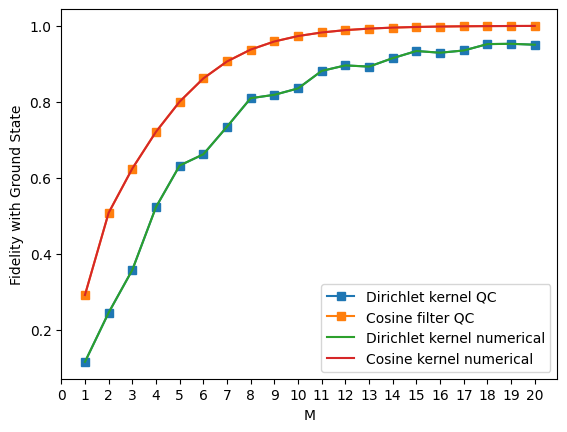

In [24]:
#

n = 4
dim = 2 ** n

def get_ground_state(H):
    eigvals, eigvecs = np.linalg.eigh(H)
    return eigvecs[:, np.argmin(eigvals)]

def shift_and_normalize_H(H):
    eigvals = np.linalg.eigvalsh(H)
    λ_min, λ_max = np.min(eigvals), np.max(eigvals)
    H_norm = (H - λ_min * np.eye(len(H))) / (λ_max - λ_min) * np.pi /2
    λ0 = np.min(np.linalg.eigvalsh(H_norm))
    H_shifted = H_norm - λ0 * np.eye(len(H))
    return H_shifted

def shift_and_normalize_H1(H):
    eigvals = np.linalg.eigvalsh(H)
    λ_min, λ_max = np.min(eigvals), np.max(eigvals)
    H_norm = (H - λ_min * np.eye(len(H))) / (λ_max - λ_min) * np.pi
    λ0 = np.min(np.linalg.eigvalsh(H_norm))
    H_shifted = H_norm - λ0 * np.eye(len(H))
    return H_shifted

def generate_random_state_with_overlap(gs, overlap):

    gs = gs / np.linalg.norm(gs)

    dim = len(gs)

    v = np.random.randn(dim) + 1j * np.random.randn(dim)

    proj = np.vdot(gs, v) * gs
    v_perp = v - proj

    if np.linalg.norm(v_perp) < 1e-12:
        return generate_random_state_with_overlap(gs, overlap)

    v_perp = v_perp / np.linalg.norm(v_perp)

    psi = np.sqrt(overlap) * gs + np.sqrt(1 - overlap) * v_perp
    psi = psi / np.linalg.norm(psi)

    return psi

def kron_n(op_list):
    result = np.array([[1]])
    for op in op_list:
        result = np.kron(result, op)
    return result

# TFIM Hamiltonian
def tfim_model(n):
    dim = 2 ** n
    H = np.zeros((dim, dim), dtype=np.complex128)
    Z = np.array([[1, 0], [0, -1]])
    X = np.array([[0, 1], [1, 0]])
    I = np.eye(2)
    for i in range(n):
        Zi = [I] * n
        Zi[i] = Z
        Zi[(i + 1) % n] = Z
        H -= kron_n(Zi)
        Xi = [I] * n
        Xi[i] = X
        H -= kron_n(Xi)
    return H



# 归一化并 shift
#H = tfim_model(n)
H = qml.matrix(get_hamiltonian_pl(4, 1))
H_shifted = shift_and_normalize_H(H)
ground_state = get_ground_state(H_shifted)
init_state = np.ones(dim) / np.sqrt(dim)
#init_state = generate_random_state_with_overlap(ground_state, 1/n)


H_shifted1 = shift_and_normalize_H1(H)
def dirichlet_block_encoding(max_N):
    k_vals_full = np.arange(-max_N, max_N + 1)
    alpha_k = np.array([1/(2* max_N + 1) for k in k_vals_full])

    pad_len = 2 ** int(np.ceil(np.log2(len(alpha_k))))
    alpha_padded = np.zeros(pad_len)
    alpha_padded[:len(alpha_k)] = alpha_k
    weights = np.sqrt(alpha_padded / np.sum(alpha_padded))
    #weights = alpha_padded
    #print('weights:', weights)
    n_anc = int(np.log2(pad_len))
    ancilla_wires = list(range(n_anc))
    system_wires = list(range(n_anc, n_anc + n))
    U_list = [expm(-1.0j * k * H_shifted1) for k in k_vals_full]
    U_list += [np.eye(dim)] * (pad_len - len(U_list))
    U_ops = [qml.QubitUnitary(U, wires=range(n_anc, n_anc + n)) for U in U_list]
    dev = qml.device("default.qubit", wires=n + n_anc)

    @qml.qnode(dev)
    def block_encoding():
        # for i in system_wires:
        #     qml.Hadamard(i)
        qml.StatePrep(init_state, wires=range(n_anc, n+n_anc))
        # for i in range(n_anc, n+n_anc, 2):
        #     qml.X(i)
        qml.StatePrep(weights, wires=range(n_anc))
        qml.Select(U_ops, control=range(n_anc))
        qml.adjoint(qml.StatePrep)(weights, wires=range(n_anc))
        return qml.state()

    # U_be = qml.matrix(block_encoding, wire_order=list(range(n_anc)) + list(range(n_anc, n_anc + n)))()
    # A_block = U_be[:dim, :dim]
    # be_state = A_block @ init_state
    full_state = block_encoding()
    reshaped = full_state.reshape((2 ** n_anc, 2 ** n))
    system_state = reshaped[0, :]
    be_state = system_state

    success_prob = np.sum(np.abs(be_state) ** 2)
    be_state /= np.linalg.norm(be_state)
    fidelity = np.abs(np.vdot(be_state, ground_state)) ** 2
    return fidelity, success_prob


def fidelity_block_encoding(m):
    k_vals_full = np.arange(-m, m + 1)
    alpha_k_full = 2 ** (-2 * m) * np.array([math.comb(2 * m, m + k) for k in k_vals_full])
    keep = [i for i in range(len(alpha_k_full)) if alpha_k_full[i] > 1e-4]
    alpha_k = alpha_k_full[keep]
    k_vals = k_vals_full[keep]
    alpha_k /= np.sum(alpha_k)
    pad_len = 2 ** int(np.ceil(np.log2(len(alpha_k))))
    alpha_padded = np.zeros(pad_len)
    alpha_padded[:len(alpha_k)] = alpha_k
    weights = np.sqrt(alpha_padded / np.sum(alpha_padded))
    n_anc = int(np.log2(pad_len))
    ancilla_wires = list(range(n_anc))
    system_wires = list(range(n_anc, n_anc + n))
    U_list = [expm(2j * k * H_shifted) for k in k_vals]
    U_list += [np.eye(dim)] * (pad_len - len(U_list))
    U_ops = [qml.QubitUnitary(U, wires=range(n_anc, n_anc + n)) for U in U_list]
    dev = qml.device("default.qubit", wires=n + n_anc)

    @qml.qnode(dev)
    def block_encoding():
        # for i in system_wires:
        #     qml.Hadamard(i)
        qml.StatePrep(init_state, wires=range(n_anc, n+n_anc))
        # for i in range(n_anc, n+n_anc, 2):
        #     qml.X(i)
        qml.StatePrep(weights, wires=range(n_anc))
        qml.Select(U_ops, control=range(n_anc))
        qml.adjoint(qml.StatePrep)(weights, wires=range(n_anc))
        return qml.state()

    # U_be = qml.matrix(block_encoding, wire_order=list(range(n_anc)) + list(range(n_anc, n_anc + n)))()
    # A_block = U_be[:dim, :dim]
    # be_state = A_block @ init_state
    full_state = block_encoding()
    reshaped = full_state.reshape((2 ** n_anc, 2 ** n))
    system_state = reshaped[0, :]
    be_state = system_state

    success_prob = np.sum(np.abs(be_state) ** 2)
    be_state /= np.linalg.norm(be_state)
    fidelity = np.abs(np.vdot(be_state, ground_state)) ** 2
    return fidelity, success_prob

def cosine_filter_matrix(H, m):
    U = expm(1j * H)
    U_dag = expm(-1j * H)
    cosH = 0.5 * (U + U_dag)
    return np.linalg.matrix_power(cosH, 2*m)

def custom_filter_matrix(H, N):
    return 1/(2*N+1) * sum(expm(-1j * H * i) for i in range(-N, N + 1)) #/ N  # corrected j = N+1 to 2N

def evaluate_fidelity(filter_matrix, init_state, H_shifted):
    psi = filter_matrix @ init_state
    psi /= np.linalg.norm(psi)
    return np.abs(np.vdot(psi, ground_state)) ** 2
    #return np.linalg.norm(psi-ground_state)**2
    #return float(np.real_if_close(np.vdot(psi, H_shifted@psi)))



# 扫描 m
max_N = 20
m_vals = list(range(1, max_N + 1))
fidelity_cosine, success_cosine = zip(*[fidelity_block_encoding(m) for m in list(range(1, max_N+1))])#list(range(1, max_N//2 + 1))])

N_list = list(range(1, max_N + 1))
fidelity_be, success_be = zip(*[dirichlet_block_encoding(N) for N in N_list])


# Fidelity for custom filter as N varies
fidelity_list = []
for N_iter in range(1, max_N + 1):
    H_shifted = shift_and_normalize_H1(H)
    fH = custom_filter_matrix(H_shifted, N_iter)
    fidelity_custom = evaluate_fidelity(fH, init_state, H)
    fidelity_list.append(fidelity_custom)

fidelity_cos_list = []
for m_vals in range(1,max_N+1):
    H_shifted = shift_and_normalize_H(H)
    cos_filter = cosine_filter_matrix(H_shifted, m_vals)
    fidelity_cos = evaluate_fidelity(cos_filter, init_state, H)
    fidelity_cos_list.append(fidelity_cos)


plt.plot(N_list, fidelity_be, marker='s', label='Dirichlet kernel QC')
#plt.plot(list(range(1, max_N + 1, 2)), fidelity_cosine, marker='s', label='Cosine filter')
plt.plot(list(range(1, max_N + 1)), fidelity_cosine, marker='s', label='Cosine filter QC')

plt.plot(range(1, max_N + 1), fidelity_list, label="Dirichlet kernel numerical")
#plt.axhline(y=fidelity_cos, color='r', linestyle='--', label="cos^{2m}(H) Fidelity")
plt.plot(list(range(1, max_N+1)), fidelity_cos_list, label='Cosine kernel numerical')

plt.xlabel("M")
plt.xticks(list(range(0, max_N + 1)))
plt.ylabel("Fidelity with Ground State")
#plt.title("Fidelity vs. m")
plt.legend()
#plt.grid(True)
#plt.savefig("cosine compare with dirichlet n6.png")
plt.show()

## test J

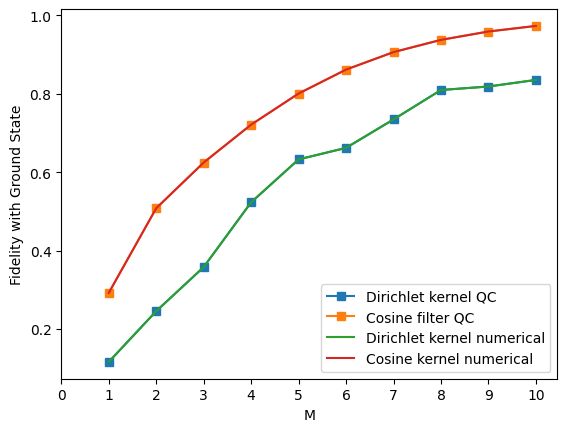

In [34]:
#

n = 4
dim = 2 ** n

def get_ground_state(H):
    eigvals, eigvecs = np.linalg.eigh(H)
    return eigvecs[:, np.argmin(eigvals)]

def shift_and_normalize_H(H):
    eigvals = np.linalg.eigvalsh(H)
    λ_min, λ_max = np.min(eigvals), np.max(eigvals)
    H_norm = (H - λ_min * np.eye(len(H))) / (λ_max - λ_min) * np.pi /2
    λ0 = np.min(np.linalg.eigvalsh(H_norm))
    H_shifted = H_norm - λ0 * np.eye(len(H))
    return H_shifted

def shift_and_normalize_H1(H):
    eigvals = np.linalg.eigvalsh(H)
    λ_min, λ_max = np.min(eigvals), np.max(eigvals)
    H_norm = (H - λ_min * np.eye(len(H))) / (λ_max - λ_min) * np.pi
    λ0 = np.min(np.linalg.eigvalsh(H_norm))
    H_shifted = H_norm - λ0 * np.eye(len(H))
    return H_shifted

def generate_random_state_with_overlap(gs, overlap):

    gs = gs / np.linalg.norm(gs)

    dim = len(gs)

    v = np.random.randn(dim) + 1j * np.random.randn(dim)

    proj = np.vdot(gs, v) * gs
    v_perp = v - proj

    if np.linalg.norm(v_perp) < 1e-12:
        return generate_random_state_with_overlap(gs, overlap)

    v_perp = v_perp / np.linalg.norm(v_perp)

    psi = np.sqrt(overlap) * gs + np.sqrt(1 - overlap) * v_perp
    psi = psi / np.linalg.norm(psi)

    return psi

def kron_n(op_list):
    result = np.array([[1]])
    for op in op_list:
        result = np.kron(result, op)
    return result

# TFIM Hamiltonian
def tfim_model(n):
    dim = 2 ** n
    H = np.zeros((dim, dim), dtype=np.complex128)
    Z = np.array([[1, 0], [0, -1]])
    X = np.array([[0, 1], [1, 0]])
    I = np.eye(2)
    for i in range(n):
        Zi = [I] * n
        Zi[i] = Z
        Zi[(i + 1) % n] = Z
        H -= kron_n(Zi)
        Xi = [I] * n
        Xi[i] = X
        H -= kron_n(Xi)
    return H



# 归一化并 shift
#H = tfim_model(n)
H = qml.matrix(get_hamiltonian_pl(4, 1/np.sqrt(2)))
H_shifted = shift_and_normalize_H(H)
ground_state = get_ground_state(H_shifted)
init_state = np.ones(dim) / np.sqrt(dim)
#init_state = generate_random_state_with_overlap(ground_state, 1/n)


H_shifted1 = shift_and_normalize_H1(H)
def dirichlet_block_encoding(max_N):
    k_vals_full = np.arange(-max_N, max_N + 1)
    alpha_k = np.array([1/(2* max_N + 1) for k in k_vals_full])

    pad_len = 2 ** int(np.ceil(np.log2(len(alpha_k))))
    alpha_padded = np.zeros(pad_len)
    alpha_padded[:len(alpha_k)] = alpha_k
    weights = np.sqrt(alpha_padded / np.sum(alpha_padded))
    #weights = alpha_padded
    #print('weights:', weights)
    n_anc = int(np.log2(pad_len))
    ancilla_wires = list(range(n_anc))
    system_wires = list(range(n_anc, n_anc + n))
    U_list = [expm(-1.0j * k * H_shifted1) for k in k_vals_full]
    U_list += [np.eye(dim)] * (pad_len - len(U_list))
    U_ops = [qml.QubitUnitary(U, wires=range(n_anc, n_anc + n)) for U in U_list]
    dev = qml.device("default.qubit", wires=n + n_anc)

    @qml.qnode(dev)
    def block_encoding():
        # for i in system_wires:
        #     qml.Hadamard(i)
        qml.StatePrep(init_state, wires=range(n_anc, n+n_anc))
        # for i in range(n_anc, n+n_anc, 2):
        #     qml.X(i)
        qml.StatePrep(weights, wires=range(n_anc))
        qml.Select(U_ops, control=range(n_anc))
        qml.adjoint(qml.StatePrep)(weights, wires=range(n_anc))
        return qml.state()

    # U_be = qml.matrix(block_encoding, wire_order=list(range(n_anc)) + list(range(n_anc, n_anc + n)))()
    # A_block = U_be[:dim, :dim]
    # be_state = A_block @ init_state
    full_state = block_encoding()
    reshaped = full_state.reshape((2 ** n_anc, 2 ** n))
    system_state = reshaped[0, :]
    be_state = system_state

    success_prob = np.sum(np.abs(be_state) ** 2)
    be_state /= np.linalg.norm(be_state)
    fidelity = np.abs(np.vdot(be_state, ground_state)) ** 2
    return fidelity, success_prob


def fidelity_block_encoding(m):
    k_vals_full = np.arange(-m, m + 1)
    alpha_k_full = 2 ** (-2 * m) * np.array([math.comb(2 * m, m + k) for k in k_vals_full])
    keep = [i for i in range(len(alpha_k_full)) if alpha_k_full[i] > 1e-4]
    alpha_k = alpha_k_full[keep]
    k_vals = k_vals_full[keep]
    alpha_k /= np.sum(alpha_k)
    pad_len = 2 ** int(np.ceil(np.log2(len(alpha_k))))
    alpha_padded = np.zeros(pad_len)
    alpha_padded[:len(alpha_k)] = alpha_k
    weights = np.sqrt(alpha_padded / np.sum(alpha_padded))
    n_anc = int(np.log2(pad_len))
    ancilla_wires = list(range(n_anc))
    system_wires = list(range(n_anc, n_anc + n))
    U_list = [expm(2j * k * H_shifted) for k in k_vals]
    U_list += [np.eye(dim)] * (pad_len - len(U_list))
    U_ops = [qml.QubitUnitary(U, wires=range(n_anc, n_anc + n)) for U in U_list]
    dev = qml.device("default.qubit", wires=n + n_anc)

    @qml.qnode(dev)
    def block_encoding():
        # for i in system_wires:
        #     qml.Hadamard(i)
        qml.StatePrep(init_state, wires=range(n_anc, n+n_anc))
        # for i in range(n_anc, n+n_anc, 2):
        #     qml.X(i)
        qml.StatePrep(weights, wires=range(n_anc))
        qml.Select(U_ops, control=range(n_anc))
        qml.adjoint(qml.StatePrep)(weights, wires=range(n_anc))
        return qml.state()

    # U_be = qml.matrix(block_encoding, wire_order=list(range(n_anc)) + list(range(n_anc, n_anc + n)))()
    # A_block = U_be[:dim, :dim]
    # be_state = A_block @ init_state
    full_state = block_encoding()
    reshaped = full_state.reshape((2 ** n_anc, 2 ** n))
    system_state = reshaped[0, :]
    be_state = system_state

    success_prob = np.sum(np.abs(be_state) ** 2)
    be_state /= np.linalg.norm(be_state)
    fidelity = np.abs(np.vdot(be_state, ground_state)) ** 2
    return fidelity, success_prob

def cosine_filter_matrix(H, m):
    U = expm(1j * H)
    U_dag = expm(-1j * H)
    cosH = 0.5 * (U + U_dag)
    return np.linalg.matrix_power(cosH, 2*m)

def custom_filter_matrix(H, N):
    return 1/(2*N+1) * sum(expm(-1j * H * i) for i in range(-N, N + 1)) #/ N  # corrected j = N+1 to 2N

def evaluate_fidelity(filter_matrix, init_state, H_shifted):
    psi = filter_matrix @ init_state
    psi /= np.linalg.norm(psi)
    return np.abs(np.vdot(psi, ground_state)) ** 2
    #return np.linalg.norm(psi-ground_state)**2
    #return float(np.real_if_close(np.vdot(psi, H_shifted@psi)))



# 扫描 m
max_N = 10
m_vals = list(range(1, max_N + 1))
fidelity_cosine, success_cosine = zip(*[fidelity_block_encoding(m) for m in list(range(1, max_N+1))])#list(range(1, max_N//2 + 1))])

N_list = list(range(1, max_N + 1))
fidelity_be, success_be = zip(*[dirichlet_block_encoding(N) for N in N_list])


# Fidelity for custom filter as N varies
fidelity_list = []
for N_iter in range(1, max_N + 1):
    H_shifted = shift_and_normalize_H1(H)
    fH = custom_filter_matrix(H_shifted, N_iter)
    fidelity_custom = evaluate_fidelity(fH, init_state, H)
    fidelity_list.append(fidelity_custom)

fidelity_cos_list = []
for m_vals in range(1,max_N+1):
    H_shifted = shift_and_normalize_H(H)
    cos_filter = cosine_filter_matrix(H_shifted, m_vals)
    fidelity_cos = evaluate_fidelity(cos_filter, init_state, H)
    fidelity_cos_list.append(fidelity_cos)


plt.plot(N_list, fidelity_be, marker='s', label='Dirichlet kernel QC')
#plt.plot(list(range(1, max_N + 1, 2)), fidelity_cosine, marker='s', label='Cosine filter')
plt.plot(list(range(1, max_N + 1)), fidelity_cosine, marker='s', label='Cosine filter QC')

plt.plot(range(1, max_N + 1), fidelity_list, label="Dirichlet kernel numerical")
#plt.axhline(y=fidelity_cos, color='r', linestyle='--', label="cos^{2m}(H) Fidelity")
plt.plot(list(range(1, max_N+1)), fidelity_cos_list, label='Cosine kernel numerical')

plt.xlabel("M")
plt.xticks(list(range(0, max_N + 1)))
plt.ylabel("Fidelity with Ground State")
#plt.title("Fidelity vs. m")
plt.legend()
#plt.grid(True)
#plt.savefig("cosine compare with dirichlet n6.png")
plt.show()

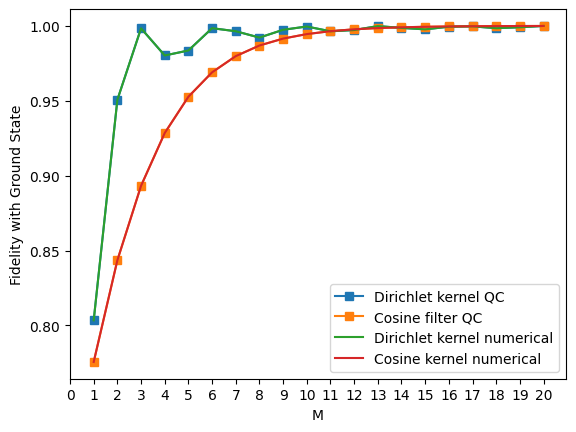

In [35]:
#

n = 4
dim = 2 ** n

def get_ground_state(H):
    eigvals, eigvecs = np.linalg.eigh(H)
    return eigvecs[:, np.argmin(eigvals)]

def shift_and_normalize_H(H):
    eigvals = np.linalg.eigvalsh(H)
    λ_min, λ_max = np.min(eigvals), np.max(eigvals)
    H_norm = (H - λ_min * np.eye(len(H))) / (λ_max - λ_min) * np.pi /2
    λ0 = np.min(np.linalg.eigvalsh(H_norm))
    H_shifted = H_norm - λ0 * np.eye(len(H))
    return H_shifted

def shift_and_normalize_H1(H):
    eigvals = np.linalg.eigvalsh(H)
    λ_min, λ_max = np.min(eigvals), np.max(eigvals)
    H_norm = (H - λ_min * np.eye(len(H))) / (λ_max - λ_min) * np.pi
    λ0 = np.min(np.linalg.eigvalsh(H_norm))
    H_shifted = H_norm - λ0 * np.eye(len(H))
    return H_shifted

def generate_random_state_with_overlap(gs, overlap):

    gs = gs / np.linalg.norm(gs)

    dim = len(gs)

    v = np.random.randn(dim) + 1j * np.random.randn(dim)

    proj = np.vdot(gs, v) * gs
    v_perp = v - proj

    if np.linalg.norm(v_perp) < 1e-12:
        return generate_random_state_with_overlap(gs, overlap)

    v_perp = v_perp / np.linalg.norm(v_perp)

    psi = np.sqrt(overlap) * gs + np.sqrt(1 - overlap) * v_perp
    psi = psi / np.linalg.norm(psi)

    return psi

def kron_n(op_list):
    result = np.array([[1]])
    for op in op_list:
        result = np.kron(result, op)
    return result

# TFIM Hamiltonian
def tfim_model(n):
    dim = 2 ** n
    H = np.zeros((dim, dim), dtype=np.complex128)
    Z = np.array([[1, 0], [0, -1]])
    X = np.array([[0, 1], [1, 0]])
    I = np.eye(2)
    for i in range(n):
        Zi = [I] * n
        Zi[i] = Z
        Zi[(i + 1) % n] = Z
        H -= kron_n(Zi)
        Xi = [I] * n
        Xi[i] = X
        H -= kron_n(Xi)
    return H



# 归一化并 shift
#H = tfim_model(n)
H = qml.matrix(get_hamiltonian_pl(4, -1/np.sqrt(2)))
H_shifted = shift_and_normalize_H(H)
ground_state = get_ground_state(H_shifted)
init_state = np.ones(dim) / np.sqrt(dim)
#init_state = generate_random_state_with_overlap(ground_state, 1/n)


H_shifted1 = shift_and_normalize_H1(H)
def dirichlet_block_encoding(max_N):
    k_vals_full = np.arange(-max_N, max_N + 1)
    alpha_k = np.array([1/(2* max_N + 1) for k in k_vals_full])

    pad_len = 2 ** int(np.ceil(np.log2(len(alpha_k))))
    alpha_padded = np.zeros(pad_len)
    alpha_padded[:len(alpha_k)] = alpha_k
    weights = np.sqrt(alpha_padded / np.sum(alpha_padded))
    #weights = alpha_padded
    #print('weights:', weights)
    n_anc = int(np.log2(pad_len))
    ancilla_wires = list(range(n_anc))
    system_wires = list(range(n_anc, n_anc + n))
    U_list = [expm(-1.0j * k * H_shifted1) for k in k_vals_full]
    U_list += [np.eye(dim)] * (pad_len - len(U_list))
    U_ops = [qml.QubitUnitary(U, wires=range(n_anc, n_anc + n)) for U in U_list]
    dev = qml.device("default.qubit", wires=n + n_anc)

    @qml.qnode(dev)
    def block_encoding():
        # for i in system_wires:
        #     qml.Hadamard(i)
        qml.StatePrep(init_state, wires=range(n_anc, n+n_anc))
        # for i in range(n_anc, n+n_anc, 2):
        #     qml.X(i)
        qml.StatePrep(weights, wires=range(n_anc))
        qml.Select(U_ops, control=range(n_anc))
        qml.adjoint(qml.StatePrep)(weights, wires=range(n_anc))
        return qml.state()

    # U_be = qml.matrix(block_encoding, wire_order=list(range(n_anc)) + list(range(n_anc, n_anc + n)))()
    # A_block = U_be[:dim, :dim]
    # be_state = A_block @ init_state
    full_state = block_encoding()
    reshaped = full_state.reshape((2 ** n_anc, 2 ** n))
    system_state = reshaped[0, :]
    be_state = system_state

    success_prob = np.sum(np.abs(be_state) ** 2)
    be_state /= np.linalg.norm(be_state)
    fidelity = np.abs(np.vdot(be_state, ground_state)) ** 2
    return fidelity, success_prob


def fidelity_block_encoding(m):
    k_vals_full = np.arange(-m, m + 1)
    alpha_k_full = 2 ** (-2 * m) * np.array([math.comb(2 * m, m + k) for k in k_vals_full])
    keep = [i for i in range(len(alpha_k_full)) if alpha_k_full[i] > 1e-4]
    alpha_k = alpha_k_full[keep]
    k_vals = k_vals_full[keep]
    alpha_k /= np.sum(alpha_k)
    pad_len = 2 ** int(np.ceil(np.log2(len(alpha_k))))
    alpha_padded = np.zeros(pad_len)
    alpha_padded[:len(alpha_k)] = alpha_k
    weights = np.sqrt(alpha_padded / np.sum(alpha_padded))
    n_anc = int(np.log2(pad_len))
    ancilla_wires = list(range(n_anc))
    system_wires = list(range(n_anc, n_anc + n))
    U_list = [expm(2j * k * H_shifted) for k in k_vals]
    U_list += [np.eye(dim)] * (pad_len - len(U_list))
    U_ops = [qml.QubitUnitary(U, wires=range(n_anc, n_anc + n)) for U in U_list]
    dev = qml.device("default.qubit", wires=n + n_anc)

    @qml.qnode(dev)
    def block_encoding():
        # for i in system_wires:
        #     qml.Hadamard(i)
        qml.StatePrep(init_state, wires=range(n_anc, n+n_anc))
        # for i in range(n_anc, n+n_anc, 2):
        #     qml.X(i)
        qml.StatePrep(weights, wires=range(n_anc))
        qml.Select(U_ops, control=range(n_anc))
        qml.adjoint(qml.StatePrep)(weights, wires=range(n_anc))
        return qml.state()

    # U_be = qml.matrix(block_encoding, wire_order=list(range(n_anc)) + list(range(n_anc, n_anc + n)))()
    # A_block = U_be[:dim, :dim]
    # be_state = A_block @ init_state
    full_state = block_encoding()
    reshaped = full_state.reshape((2 ** n_anc, 2 ** n))
    system_state = reshaped[0, :]
    be_state = system_state

    success_prob = np.sum(np.abs(be_state) ** 2)
    be_state /= np.linalg.norm(be_state)
    fidelity = np.abs(np.vdot(be_state, ground_state)) ** 2
    return fidelity, success_prob

def cosine_filter_matrix(H, m):
    U = expm(1j * H)
    U_dag = expm(-1j * H)
    cosH = 0.5 * (U + U_dag)
    return np.linalg.matrix_power(cosH, 2*m)

def custom_filter_matrix(H, N):
    return 1/(2*N+1) * sum(expm(-1j * H * i) for i in range(-N, N + 1)) #/ N  # corrected j = N+1 to 2N

def evaluate_fidelity(filter_matrix, init_state, H_shifted):
    psi = filter_matrix @ init_state
    psi /= np.linalg.norm(psi)
    return np.abs(np.vdot(psi, ground_state)) ** 2
    #return np.linalg.norm(psi-ground_state)**2
    #return float(np.real_if_close(np.vdot(psi, H_shifted@psi)))



# 扫描 m
max_N = 20
m_vals = list(range(1, max_N + 1))
fidelity_cosine, success_cosine = zip(*[fidelity_block_encoding(m) for m in list(range(1, max_N+1))])#list(range(1, max_N//2 + 1))])

N_list = list(range(1, max_N + 1))
fidelity_be, success_be = zip(*[dirichlet_block_encoding(N) for N in N_list])


# Fidelity for custom filter as N varies
fidelity_list = []
for N_iter in range(1, max_N + 1):
    H_shifted = shift_and_normalize_H1(H)
    fH = custom_filter_matrix(H_shifted, N_iter)
    fidelity_custom = evaluate_fidelity(fH, init_state, H)
    fidelity_list.append(fidelity_custom)

fidelity_cos_list = []
for m_vals in range(1,max_N+1):
    H_shifted = shift_and_normalize_H(H)
    cos_filter = cosine_filter_matrix(H_shifted, m_vals)
    fidelity_cos = evaluate_fidelity(cos_filter, init_state, H)
    fidelity_cos_list.append(fidelity_cos)


plt.plot(N_list, fidelity_be, marker='s', label='Dirichlet kernel QC')
#plt.plot(list(range(1, max_N + 1, 2)), fidelity_cosine, marker='s', label='Cosine filter')
plt.plot(list(range(1, max_N + 1)), fidelity_cosine, marker='s', label='Cosine filter QC')

plt.plot(range(1, max_N + 1), fidelity_list, label="Dirichlet kernel numerical")
#plt.axhline(y=fidelity_cos, color='r', linestyle='--', label="cos^{2m}(H) Fidelity")
plt.plot(list(range(1, max_N+1)), fidelity_cos_list, label='Cosine kernel numerical')

plt.xlabel("M")
plt.xticks(list(range(0, max_N + 1)))
plt.ylabel("Fidelity with Ground State")
#plt.title("Fidelity vs. m")
plt.legend()
#plt.grid(True)
#plt.savefig("cosine compare with dirichlet n6.png")
plt.show()

In [37]:
test_a = qml.matrix(get_hamiltonian_pl(4,1))
vals, vecs = np.linalg.eigh(test_a)
gs = vecs[:, np.argmin(vals)]
test_b = np.zeros(2**4)
test_b[0] = 1
np.abs(np.vdot(gs, test_b))**2
print('eigenvalues', np.linalg.eigh(qml.matrix(get_hamiltonian_pl(4, 1)))[0])
print('overlap init and gs', np.abs(np.vdot(gs, test_b))**2)

eigenvalues [-5.22625186e+00 -4.82842712e+00 -2.16478440e+00 -2.00000000e+00
 -2.00000000e+00 -8.28427125e-01 -8.65402876e-17 -6.95180626e-17
  3.08155502e-16  5.76486708e-16  8.28427125e-01  2.00000000e+00
  2.00000000e+00  2.16478440e+00  4.82842712e+00  5.22625186e+00]
overlap init and gs 0.005873803214612145


In [38]:
test_a = qml.matrix(get_hamiltonian_pl(4, -1))
vals, vecs = np.linalg.eigh(test_a)
gs = vecs[:, np.argmin(vals)]
test_b = np.zeros(2**4)
test_b[0] = 1
np.abs(np.vdot(gs, test_b))**2
print('eigenvalues', np.linalg.eigh(qml.matrix(get_hamiltonian_pl(4, -1)))[0])
print('overlap init and gs', np.abs(np.vdot(gs, test_b))**2)

eigenvalues [-5.22625186e+00 -4.82842712e+00 -2.16478440e+00 -2.00000000e+00
 -2.00000000e+00 -8.28427125e-01 -6.54625130e-16 -1.60651714e-16
 -2.06940704e-17  7.24948612e-16  8.28427125e-01  2.00000000e+00
  2.00000000e+00  2.16478440e+00  4.82842712e+00  5.22625186e+00]
overlap init and gs 0.33251454443369927


In [39]:
test_a = qml.matrix(get_hamiltonian_pl(4, 1/np.sqrt(2)))
vals, vecs = np.linalg.eigh(test_a)
gs = vecs[:, np.argmin(vals)]
test_b = np.zeros(2**4)
test_b[0] = 1
np.abs(np.vdot(gs, test_b))**2
print('eigenvalues', np.linalg.eigh(qml.matrix(get_hamiltonian_pl(4, 1/np.sqrt(2))))[0])
print('overlap init and gs', np.abs(np.vdot(gs, test_b))**2)


eigenvalues [-3.69551813e+00 -3.41421356e+00 -1.53073373e+00 -1.41421356e+00
 -1.41421356e+00 -5.85786438e-01 -4.45520538e-16 -1.82326957e-16
 -1.90729890e-17  3.34670258e-16  5.85786438e-01  1.41421356e+00
  1.41421356e+00  1.53073373e+00  3.41421356e+00  3.69551813e+00]
overlap init and gs 0.005873803214612133


In [40]:
test_a = qml.matrix(get_hamiltonian_pl(4, -1/np.sqrt(2)))
vals, vecs = np.linalg.eigh(test_a)
gs = vecs[:, np.argmin(vals)]
test_b = np.zeros(2**4)
test_b[0] = 1
np.abs(np.vdot(gs, test_b))**2
print('eigenvalues', np.linalg.eigh(qml.matrix(get_hamiltonian_pl(4, -1/np.sqrt(2))))[0])
print('overlap init and gs', np.abs(np.vdot(gs, test_b))**2)

eigenvalues [-3.69551813e+00 -3.41421356e+00 -1.53073373e+00 -1.41421356e+00
 -1.41421356e+00 -5.85786438e-01 -2.63193868e-16 -1.05198818e-16
  1.39869949e-16  7.83634249e-16  5.85786438e-01  1.41421356e+00
  1.41421356e+00  1.53073373e+00  3.41421356e+00  3.69551813e+00]
overlap init and gs 0.3325145444337072


In [32]:
#print(qml.matrix(get_hamiltonian_pl(2, 1)))
test_a = qml.matrix(get_hamiltonian_pl(2, 1))
for row in test_a:
    print(row)


[2.+0.j 1.+0.j 1.+0.j 0.+0.j]
[ 1.+0.j -2.+0.j  0.+0.j  1.+0.j]
[ 1.+0.j  0.+0.j -2.+0.j  1.+0.j]
[0.+0.j 1.+0.j 1.+0.j 2.+0.j]


In [263]:
print('eigenvalues', np.linalg.eigh(tfim_model(4))[0])
print('eigenvectors', np.linalg.eigh(tfim_model(4))[1][0])

eigenvalues [-5.22625186e+00 -4.82842712e+00 -2.16478440e+00 -2.00000000e+00
 -2.00000000e+00 -8.28427125e-01 -6.54625130e-16 -1.60651714e-16
 -2.06940704e-17  7.24948612e-16  8.28427125e-01  2.00000000e+00
  2.00000000e+00  2.16478440e+00  4.82842712e+00  5.22625186e+00]
eigenvectors [-5.76640741e-01+0.j  6.53281482e-01-0.j -3.85299025e-01+0.j
 -1.16529718e-16+0.j  1.06078411e-15+0.j  1.10345202e-16+0.j
  4.71327967e-17-0.j -2.07967497e-17+0.j -1.27610516e-16+0.j
 -1.42867976e-16+0.j -2.70598050e-01+0.j  9.88883887e-17+0.j
 -1.01379502e-16+0.j -1.14700975e-01+0.j -4.19696722e-17+0.j
  7.66407412e-02+0.j]


In [260]:
np.linalg.norm(qml.matrix(get_hamiltonian_pl(4, 1))-tfim_model(4))

np.float64(22.627416997969522)

In [190]:
print('overlap is', abs(np.vdot(init_state, ground_state)**2))

overlap is 0.2499999999999999


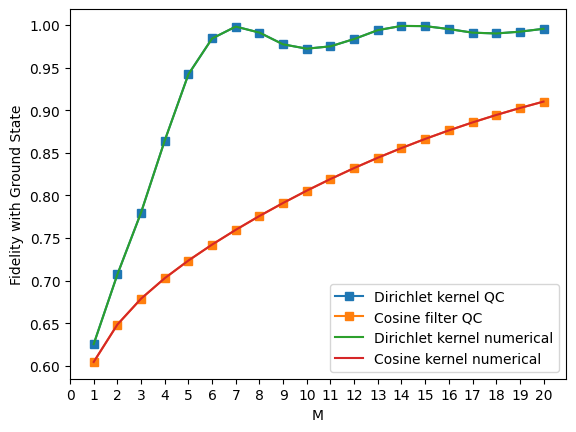

In [193]:

n = 6
dim = 2 ** n

def get_ground_state(H):
    eigvals, eigvecs = np.linalg.eigh(H)
    return eigvecs[:, np.argmin(eigvals)]

def shift_and_normalize_H(H):
    eigvals = np.linalg.eigvalsh(H)
    λ_min, λ_max = np.min(eigvals), np.max(eigvals)
    H_norm = (H - λ_min * np.eye(len(H))) / (λ_max - λ_min) * np.pi /2
    λ0 = np.min(np.linalg.eigvalsh(H_norm))
    H_shifted = H_norm - λ0 * np.eye(len(H))
    return H_shifted

def shift_and_normalize_H1(H):
    eigvals = np.linalg.eigvalsh(H)
    λ_min, λ_max = np.min(eigvals), np.max(eigvals)
    H_norm = (H - λ_min * np.eye(len(H))) / (λ_max - λ_min) * np.pi
    λ0 = np.min(np.linalg.eigvalsh(H_norm))
    H_shifted = H_norm - λ0 * np.eye(len(H))
    return H_shifted

def generate_random_state_with_overlap(gs, overlap):

    gs = gs / np.linalg.norm(gs)

    dim = len(gs)

    v = np.random.randn(dim) + 1j * np.random.randn(dim)

    proj = np.vdot(gs, v) * gs
    v_perp = v - proj

    if np.linalg.norm(v_perp) < 1e-12:
        return generate_random_state_with_overlap(gs, overlap)

    v_perp = v_perp / np.linalg.norm(v_perp)

    psi = np.sqrt(overlap) * gs + np.sqrt(1 - overlap) * v_perp
    psi = psi / np.linalg.norm(psi)

    return psi

def kron_n(op_list):
    result = np.array([[1]])
    for op in op_list:
        result = np.kron(result, op)
    return result

# TFIM Hamiltonian
def tfim_model(n):
    dim = 2 ** n
    H = np.zeros((dim, dim), dtype=np.complex128)
    Z = np.array([[1, 0], [0, -1]])
    X = np.array([[0, 1], [1, 0]])
    I = np.eye(2)
    for i in range(n):
        Zi = [I] * n
        Zi[i] = Z
        Zi[(i + 1) % n] = Z
        H -= kron_n(Zi)
        Xi = [I] * n
        Xi[i] = X
        H -= kron_n(Xi)
    return H



# 归一化并 shift
H = tfim_model(n)
H_shifted = shift_and_normalize_H(H)
ground_state = get_ground_state(H_shifted)
init_state = np.ones(dim) / np.sqrt(dim)
#init_state = generate_random_state_with_overlap(ground_state, 1/n)


H_shifted1 = shift_and_normalize_H1(H)
def dirichlet_block_encoding(max_N):
    k_vals_full = np.arange(-max_N, max_N + 1)
    alpha_k = np.array([1/(2* max_N + 1) for k in k_vals_full])

    pad_len = 2 ** int(np.ceil(np.log2(len(alpha_k))))
    alpha_padded = np.zeros(pad_len)
    alpha_padded[:len(alpha_k)] = alpha_k
    weights = np.sqrt(alpha_padded / np.sum(alpha_padded))
    #weights = alpha_padded
    #print('weights:', weights)
    n_anc = int(np.log2(pad_len))
    ancilla_wires = list(range(n_anc))
    system_wires = list(range(n_anc, n_anc + n))
    U_list = [expm(-1.0j * k * H_shifted1) for k in k_vals_full]
    U_list += [np.eye(dim)] * (pad_len - len(U_list))
    U_ops = [qml.QubitUnitary(U, wires=range(n_anc, n_anc + n)) for U in U_list]
    dev = qml.device("default.qubit", wires=n + n_anc)

    @qml.qnode(dev)
    def block_encoding():
        # for i in system_wires:
        #     qml.Hadamard(i)
        qml.StatePrep(init_state, wires=range(n_anc, n+n_anc))
        # for i in range(n_anc, n+n_anc, 2):
        #     qml.X(i)
        qml.StatePrep(weights, wires=range(n_anc))
        qml.Select(U_ops, control=range(n_anc))
        qml.adjoint(qml.StatePrep)(weights, wires=range(n_anc))
        return qml.state()

    # U_be = qml.matrix(block_encoding, wire_order=list(range(n_anc)) + list(range(n_anc, n_anc + n)))()
    # A_block = U_be[:dim, :dim]
    # be_state = A_block @ init_state
    full_state = block_encoding()
    reshaped = full_state.reshape((2 ** n_anc, 2 ** n))
    system_state = reshaped[0, :]
    be_state = system_state

    success_prob = np.sum(np.abs(be_state) ** 2)
    be_state /= np.linalg.norm(be_state)
    fidelity = np.abs(np.vdot(be_state, ground_state)) ** 2
    return fidelity, success_prob


def fidelity_block_encoding(m):
    k_vals_full = np.arange(-m, m + 1)
    alpha_k_full = 2 ** (-2 * m) * np.array([math.comb(2 * m, m + k) for k in k_vals_full])
    keep = [i for i in range(len(alpha_k_full)) if alpha_k_full[i] > 1e-4]
    alpha_k = alpha_k_full[keep]
    k_vals = k_vals_full[keep]
    alpha_k /= np.sum(alpha_k)
    pad_len = 2 ** int(np.ceil(np.log2(len(alpha_k))))
    alpha_padded = np.zeros(pad_len)
    alpha_padded[:len(alpha_k)] = alpha_k
    weights = np.sqrt(alpha_padded / np.sum(alpha_padded))
    n_anc = int(np.log2(pad_len))
    ancilla_wires = list(range(n_anc))
    system_wires = list(range(n_anc, n_anc + n))
    U_list = [expm(2j * k * H_shifted) for k in k_vals]
    U_list += [np.eye(dim)] * (pad_len - len(U_list))
    U_ops = [qml.QubitUnitary(U, wires=range(n_anc, n_anc + n)) for U in U_list]
    dev = qml.device("default.qubit", wires=n + n_anc)

    @qml.qnode(dev)
    def block_encoding():
        # for i in system_wires:
        #     qml.Hadamard(i)
        qml.StatePrep(init_state, wires=range(n_anc, n+n_anc))
        # for i in range(n_anc, n+n_anc, 2):
        #     qml.X(i)
        qml.StatePrep(weights, wires=range(n_anc))
        qml.Select(U_ops, control=range(n_anc))
        qml.adjoint(qml.StatePrep)(weights, wires=range(n_anc))
        return qml.state()

    # U_be = qml.matrix(block_encoding, wire_order=list(range(n_anc)) + list(range(n_anc, n_anc + n)))()
    # A_block = U_be[:dim, :dim]
    # be_state = A_block @ init_state
    full_state = block_encoding()
    reshaped = full_state.reshape((2 ** n_anc, 2 ** n))
    system_state = reshaped[0, :]
    be_state = system_state

    success_prob = np.sum(np.abs(be_state) ** 2)
    be_state /= np.linalg.norm(be_state)
    fidelity = np.abs(np.vdot(be_state, ground_state)) ** 2
    return fidelity, success_prob

def cosine_filter_matrix(H, m):
    U = expm(1j * H)
    U_dag = expm(-1j * H)
    cosH = 0.5 * (U + U_dag)
    return np.linalg.matrix_power(cosH, 2*m)

def custom_filter_matrix(H, N):
    return 1/(2*N+1) * sum(expm(-1j * H * i) for i in range(-N, N + 1)) #/ N  # corrected j = N+1 to 2N

def evaluate_fidelity(filter_matrix, init_state, H_shifted):
    psi = filter_matrix @ init_state
    psi /= np.linalg.norm(psi)
    return np.abs(np.vdot(psi, ground_state)) ** 2
    #return np.linalg.norm(psi-ground_state)**2
    #return float(np.real_if_close(np.vdot(psi, H_shifted@psi)))



# 扫描 m
max_N = 20
m_vals = list(range(1, max_N + 1))
fidelity_cosine, success_cosine = zip(*[fidelity_block_encoding(m) for m in list(range(1, max_N+1))])#list(range(1, max_N//2 + 1))])

N_list = list(range(1, max_N + 1))
fidelity_be, success_be = zip(*[dirichlet_block_encoding(N) for N in N_list])


# Fidelity for custom filter as N varies
fidelity_list = []
for N_iter in range(1, max_N + 1):
    H_shifted = shift_and_normalize_H1(H)
    fH = custom_filter_matrix(H_shifted, N_iter)
    fidelity_custom = evaluate_fidelity(fH, init_state, H)
    fidelity_list.append(fidelity_custom)

fidelity_cos_list = []
for m_vals in range(1,max_N+1):
    H_shifted = shift_and_normalize_H(H)
    cos_filter = cosine_filter_matrix(H_shifted, m_vals)
    fidelity_cos = evaluate_fidelity(cos_filter, init_state, H)
    fidelity_cos_list.append(fidelity_cos)


plt.plot(N_list, fidelity_be, marker='s', label='Dirichlet kernel QC')
#plt.plot(list(range(1, max_N + 1, 2)), fidelity_cosine, marker='s', label='Cosine filter')
plt.plot(list(range(1, max_N + 1)), fidelity_cosine, marker='s', label='Cosine filter QC')

plt.plot(range(1, max_N + 1), fidelity_list, label="Dirichlet kernel numerical")
#plt.axhline(y=fidelity_cos, color='r', linestyle='--', label="cos^{2m}(H) Fidelity")
plt.plot(list(range(1, max_N+1)), fidelity_cos_list, label='Cosine kernel numerical')

plt.xlabel("M")
plt.xticks(list(range(0, max_N + 1)))
plt.ylabel("Fidelity with Ground State")
#plt.title("Fidelity vs. m")
plt.legend()
#plt.grid(True)
#plt.savefig("cosine compare with dirichlet n6.png")
plt.show()

In [194]:
print('overlap is', abs(np.vdot(init_state, ground_state)**2))

overlap is 0.5280817189574003


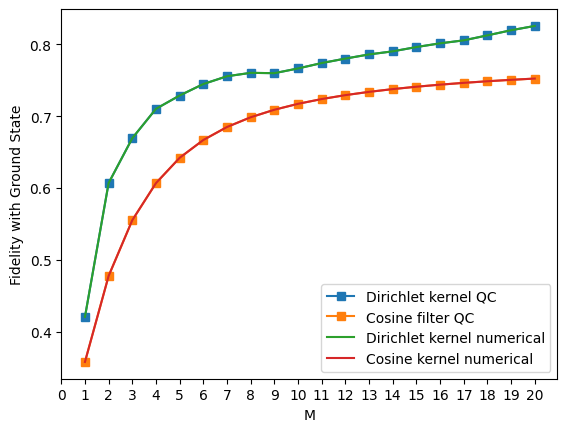

In [195]:

n = 6
dim = 2 ** n

def get_ground_state(H):
    eigvals, eigvecs = np.linalg.eigh(H)
    return eigvecs[:, np.argmin(eigvals)]

def shift_and_normalize_H(H):
    eigvals = np.linalg.eigvalsh(H)
    λ_min, λ_max = np.min(eigvals), np.max(eigvals)
    H_norm = (H - λ_min * np.eye(len(H))) / (λ_max - λ_min) * np.pi /2
    λ0 = np.min(np.linalg.eigvalsh(H_norm))
    H_shifted = H_norm - λ0 * np.eye(len(H))
    return H_shifted

def shift_and_normalize_H1(H):
    eigvals = np.linalg.eigvalsh(H)
    λ_min, λ_max = np.min(eigvals), np.max(eigvals)
    H_norm = (H - λ_min * np.eye(len(H))) / (λ_max - λ_min) * np.pi
    λ0 = np.min(np.linalg.eigvalsh(H_norm))
    H_shifted = H_norm - λ0 * np.eye(len(H))
    return H_shifted

def generate_random_state_with_overlap(gs, overlap):

    gs = gs / np.linalg.norm(gs)

    dim = len(gs)

    v = np.random.randn(dim) + 1j * np.random.randn(dim)

    proj = np.vdot(gs, v) * gs
    v_perp = v - proj

    if np.linalg.norm(v_perp) < 1e-12:
        return generate_random_state_with_overlap(gs, overlap)

    v_perp = v_perp / np.linalg.norm(v_perp)

    psi = np.sqrt(overlap) * gs + np.sqrt(1 - overlap) * v_perp
    psi = psi / np.linalg.norm(psi)

    return psi

def kron_n(op_list):
    result = np.array([[1]])
    for op in op_list:
        result = np.kron(result, op)
    return result

# TFIM Hamiltonian
def tfim_model(n):
    dim = 2 ** n
    H = np.zeros((dim, dim), dtype=np.complex128)
    Z = np.array([[1, 0], [0, -1]])
    X = np.array([[0, 1], [1, 0]])
    I = np.eye(2)
    for i in range(n):
        Zi = [I] * n
        Zi[i] = Z
        Zi[(i + 1) % n] = Z
        H -= kron_n(Zi)
        Xi = [I] * n
        Xi[i] = X
        H -= kron_n(Xi)
    return H



# 归一化并 shift
H = tfim_model(n)
H_shifted = shift_and_normalize_H(H)
ground_state = get_ground_state(H_shifted)
#init_state = np.ones(dim) / np.sqrt(dim)
init_state = generate_random_state_with_overlap(ground_state, 1/n)


H_shifted1 = shift_and_normalize_H1(H)
def dirichlet_block_encoding(max_N):
    k_vals_full = np.arange(-max_N, max_N + 1)
    alpha_k = np.array([1/(2* max_N + 1) for k in k_vals_full])

    pad_len = 2 ** int(np.ceil(np.log2(len(alpha_k))))
    alpha_padded = np.zeros(pad_len)
    alpha_padded[:len(alpha_k)] = alpha_k
    weights = np.sqrt(alpha_padded / np.sum(alpha_padded))
    #weights = alpha_padded
    #print('weights:', weights)
    n_anc = int(np.log2(pad_len))
    ancilla_wires = list(range(n_anc))
    system_wires = list(range(n_anc, n_anc + n))
    U_list = [expm(-1.0j * k * H_shifted1) for k in k_vals_full]
    U_list += [np.eye(dim)] * (pad_len - len(U_list))
    U_ops = [qml.QubitUnitary(U, wires=range(n_anc, n_anc + n)) for U in U_list]
    dev = qml.device("default.qubit", wires=n + n_anc)

    @qml.qnode(dev)
    def block_encoding():
        # for i in system_wires:
        #     qml.Hadamard(i)
        qml.StatePrep(init_state, wires=range(n_anc, n+n_anc))
        # for i in range(n_anc, n+n_anc, 2):
        #     qml.X(i)
        qml.StatePrep(weights, wires=range(n_anc))
        qml.Select(U_ops, control=range(n_anc))
        qml.adjoint(qml.StatePrep)(weights, wires=range(n_anc))
        return qml.state()

    # U_be = qml.matrix(block_encoding, wire_order=list(range(n_anc)) + list(range(n_anc, n_anc + n)))()
    # A_block = U_be[:dim, :dim]
    # be_state = A_block @ init_state
    full_state = block_encoding()
    reshaped = full_state.reshape((2 ** n_anc, 2 ** n))
    system_state = reshaped[0, :]
    be_state = system_state

    success_prob = np.sum(np.abs(be_state) ** 2)
    be_state /= np.linalg.norm(be_state)
    fidelity = np.abs(np.vdot(be_state, ground_state)) ** 2
    return fidelity, success_prob


def fidelity_block_encoding(m):
    k_vals_full = np.arange(-m, m + 1)
    alpha_k_full = 2 ** (-2 * m) * np.array([math.comb(2 * m, m + k) for k in k_vals_full])
    keep = [i for i in range(len(alpha_k_full)) if alpha_k_full[i] > 1e-4]
    alpha_k = alpha_k_full[keep]
    k_vals = k_vals_full[keep]
    alpha_k /= np.sum(alpha_k)
    pad_len = 2 ** int(np.ceil(np.log2(len(alpha_k))))
    alpha_padded = np.zeros(pad_len)
    alpha_padded[:len(alpha_k)] = alpha_k
    weights = np.sqrt(alpha_padded / np.sum(alpha_padded))
    n_anc = int(np.log2(pad_len))
    ancilla_wires = list(range(n_anc))
    system_wires = list(range(n_anc, n_anc + n))
    U_list = [expm(2j * k * H_shifted) for k in k_vals]
    U_list += [np.eye(dim)] * (pad_len - len(U_list))
    U_ops = [qml.QubitUnitary(U, wires=range(n_anc, n_anc + n)) for U in U_list]
    dev = qml.device("default.qubit", wires=n + n_anc)

    @qml.qnode(dev)
    def block_encoding():
        # for i in system_wires:
        #     qml.Hadamard(i)
        qml.StatePrep(init_state, wires=range(n_anc, n+n_anc))
        # for i in range(n_anc, n+n_anc, 2):
        #     qml.X(i)
        qml.StatePrep(weights, wires=range(n_anc))
        qml.Select(U_ops, control=range(n_anc))
        qml.adjoint(qml.StatePrep)(weights, wires=range(n_anc))
        return qml.state()

    # U_be = qml.matrix(block_encoding, wire_order=list(range(n_anc)) + list(range(n_anc, n_anc + n)))()
    # A_block = U_be[:dim, :dim]
    # be_state = A_block @ init_state
    full_state = block_encoding()
    reshaped = full_state.reshape((2 ** n_anc, 2 ** n))
    system_state = reshaped[0, :]
    be_state = system_state

    success_prob = np.sum(np.abs(be_state) ** 2)
    be_state /= np.linalg.norm(be_state)
    fidelity = np.abs(np.vdot(be_state, ground_state)) ** 2
    return fidelity, success_prob

def cosine_filter_matrix(H, m):
    U = expm(1j * H)
    U_dag = expm(-1j * H)
    cosH = 0.5 * (U + U_dag)
    return np.linalg.matrix_power(cosH, 2*m)

def custom_filter_matrix(H, N):
    return 1/(2*N+1) * sum(expm(-1j * H * i) for i in range(-N, N + 1)) #/ N  # corrected j = N+1 to 2N

def evaluate_fidelity(filter_matrix, init_state, H_shifted):
    psi = filter_matrix @ init_state
    psi /= np.linalg.norm(psi)
    return np.abs(np.vdot(psi, ground_state)) ** 2
    #return np.linalg.norm(psi-ground_state)**2
    #return float(np.real_if_close(np.vdot(psi, H_shifted@psi)))



# 扫描 m
max_N = 20
m_vals = list(range(1, max_N + 1))
fidelity_cosine, success_cosine = zip(*[fidelity_block_encoding(m) for m in list(range(1, max_N+1))])#list(range(1, max_N//2 + 1))])

N_list = list(range(1, max_N + 1))
fidelity_be, success_be = zip(*[dirichlet_block_encoding(N) for N in N_list])


# Fidelity for custom filter as N varies
fidelity_list = []
for N_iter in range(1, max_N + 1):
    H_shifted = shift_and_normalize_H1(H)
    fH = custom_filter_matrix(H_shifted, N_iter)
    fidelity_custom = evaluate_fidelity(fH, init_state, H)
    fidelity_list.append(fidelity_custom)

fidelity_cos_list = []
for m_vals in range(1,max_N+1):
    H_shifted = shift_and_normalize_H(H)
    cos_filter = cosine_filter_matrix(H_shifted, m_vals)
    fidelity_cos = evaluate_fidelity(cos_filter, init_state, H)
    fidelity_cos_list.append(fidelity_cos)


plt.plot(N_list, fidelity_be, marker='s', label='Dirichlet kernel QC')
#plt.plot(list(range(1, max_N + 1, 2)), fidelity_cosine, marker='s', label='Cosine filter')
plt.plot(list(range(1, max_N + 1)), fidelity_cosine, marker='s', label='Cosine filter QC')

plt.plot(range(1, max_N + 1), fidelity_list, label="Dirichlet kernel numerical")
#plt.axhline(y=fidelity_cos, color='r', linestyle='--', label="cos^{2m}(H) Fidelity")
plt.plot(list(range(1, max_N+1)), fidelity_cos_list, label='Cosine kernel numerical')

plt.xlabel("M")
plt.xticks(list(range(0, max_N + 1)))
plt.ylabel("Fidelity with Ground State")
#plt.title("Fidelity vs. m")
plt.legend()
#plt.grid(True)
#plt.savefig("cosine compare with dirichlet n6.png")
plt.show()

In [196]:
print('overlap is', abs(np.vdot(init_state, ground_state)**2))

overlap is 0.16666666666666657


In [197]:
abs(1+1j)

1.4142135623730951

In [198]:
print(eigvals2)

[-7.72740661e+00 -7.46410162e+00 -5.65685425e+00 -5.46410162e+00
 -5.46410162e+00 -4.00000000e+00 -4.00000000e+00 -3.86370331e+00
 -3.86370331e+00 -3.86370331e+00 -3.86370331e+00 -3.46410162e+00
 -3.46410162e+00 -2.82842712e+00 -2.82842712e+00 -2.82842712e+00
 -2.82842712e+00 -2.07055236e+00 -2.00000000e+00 -2.00000000e+00
 -2.00000000e+00 -2.00000000e+00 -1.46410162e+00 -1.46410162e+00
 -1.03527618e+00 -1.03527618e+00 -1.03527618e+00 -1.03527618e+00
 -5.35898385e-01 -5.29608444e-16 -1.70027218e-16 -8.32667329e-17
  4.38796948e-16  1.13079625e-15  1.68266521e-15  5.35898385e-01
  1.03527618e+00  1.03527618e+00  1.03527618e+00  1.03527618e+00
  1.46410162e+00  1.46410162e+00  2.00000000e+00  2.00000000e+00
  2.00000000e+00  2.00000000e+00  2.07055236e+00  2.82842712e+00
  2.82842712e+00  2.82842712e+00  2.82842712e+00  3.46410162e+00
  3.46410162e+00  3.86370331e+00  3.86370331e+00  3.86370331e+00
  3.86370331e+00  4.00000000e+00  4.00000000e+00  5.46410162e+00
  5.46410162e+00  5.65685

[-6.46410162 -3.82842712 -3.82842712 -3.82842712 -1.         -1.
 -1.          0.46410162  1.82842712  1.82842712  1.82842712  3.
  3.          3.          3.          3.        ]


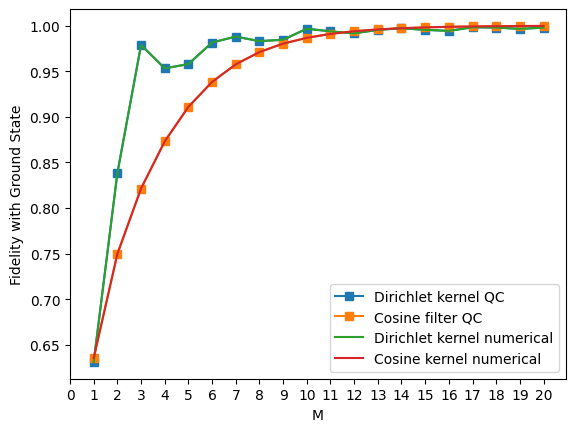

In [200]:
import pennylane as qml
from pennylane import numpy as np

def heisenberg_hamiltonian(n_qubits, Jx=1.0, Jy=1.0, Jz=1.0, h=0.0, periodic=False):
    """返回 n_qubits 自旋-1/2 Heisenberg 模型的 qml.Hamiltonian.

    H = Σ_{<i,j>} (Jx X_i X_j + Jy Y_i Y_j + Jz Z_i Z_j) + h Σ_i Z_i

    参数
    ----
    n_qubits : int
        比特数
    Jx, Jy, Jz : float
        XYZ 各向异性耦合系数
    h : float
        沿 z 方向的外场强度
    periodic : bool
        True 表示周期边界（i 和 i+1 按 mod n 连接），
        False 表示开边界（只连 0-1, 1-2, ..., n-2 - n-1）
    """
    coeffs = []
    ops = []

    # 相邻对 (i, j)
    if periodic:
        neighbors = [(i, (i + 1) % n_qubits) for i in range(n_qubits)]
    else:
        neighbors = [(i, i + 1) for i in range(n_qubits - 1)]

    # 相互作用项
    for i, j in neighbors:
        if Jx != 0.0:
            coeffs.append(Jx)
            ops.append(qml.PauliX(i) @ qml.PauliX(j))

        if Jy != 0.0:
            coeffs.append(Jy)
            ops.append(qml.PauliY(i) @ qml.PauliY(j))

        if Jz != 0.0:
            coeffs.append(Jz)
            ops.append(qml.PauliZ(i) @ qml.PauliZ(j))

    # 外场项 h Σ Z_i
    if h != 0.0:
        for i in range(n_qubits):
            coeffs.append(h)
            ops.append(qml.PauliZ(i))

    H = qml.Hamiltonian(coeffs, ops)
    return H

# ====== 具体：4 qubits 海森堡链的例子 ======
n_qubits = 4
H_heis = heisenberg_hamiltonian(
    n_qubits=4,
    Jx=1.0, Jy=1.0, Jz=1.0,  # 各向同性 Heisenberg XXX+YYY+ZZZ
    h=0.0,                   # 无外场
    periodic=False           # 开边界：0-1, 1-2, 2-3
)

matrix_temp = qml.matrix(H_heis)
eigvals, eigvecs = np.linalg.eigh(matrix_temp)
print(eigvals)

n = 4
dim = 2 ** n

def get_ground_state(H):
    eigvals, eigvecs = np.linalg.eigh(H)
    return eigvecs[:, np.argmin(eigvals)]

def shift_and_normalize_H(H):
    eigvals = np.linalg.eigvalsh(H)
    λ_min, λ_max = np.min(eigvals), np.max(eigvals)
    H_norm = (H - λ_min * np.eye(len(H))) / (λ_max - λ_min) * np.pi /2
    λ0 = np.min(np.linalg.eigvalsh(H_norm))
    H_shifted = H_norm - λ0 * np.eye(len(H))
    return H_shifted

def shift_and_normalize_H1(H):
    eigvals = np.linalg.eigvalsh(H)
    λ_min, λ_max = np.min(eigvals), np.max(eigvals)
    H_norm = (H - λ_min * np.eye(len(H))) / (λ_max - λ_min) * np.pi
    λ0 = np.min(np.linalg.eigvalsh(H_norm))
    H_shifted = H_norm - λ0 * np.eye(len(H))
    return H_shifted

def generate_random_state_with_overlap(gs, overlap):

    gs = gs / np.linalg.norm(gs)

    dim = len(gs)

    v = np.random.randn(dim) + 1j * np.random.randn(dim)

    proj = np.vdot(gs, v) * gs
    v_perp = v - proj

    if np.linalg.norm(v_perp) < 1e-12:
        return generate_random_state_with_overlap(gs, overlap)

    v_perp = v_perp / np.linalg.norm(v_perp)

    psi = np.sqrt(overlap) * gs + np.sqrt(1 - overlap) * v_perp
    psi = psi / np.linalg.norm(psi)

    return psi

def kron_n(op_list):
    result = np.array([[1]])
    for op in op_list:
        result = np.kron(result, op)
    return result

# TFIM Hamiltonian
def tfim_model(n):
    dim = 2 ** n
    H = np.zeros((dim, dim), dtype=np.complex128)
    Z = np.array([[1, 0], [0, -1]])
    X = np.array([[0, 1], [1, 0]])
    I = np.eye(2)
    for i in range(n):
        Zi = [I] * n
        Zi[i] = Z
        Zi[(i + 1) % n] = Z
        H -= kron_n(Zi)
        Xi = [I] * n
        Xi[i] = X
        H -= kron_n(Xi)
    return H



# 归一化并 shift
H = matrix_temp
H_shifted = shift_and_normalize_H(H)
ground_state = get_ground_state(H_shifted)
#init_state = np.ones(dim) / np.sqrt(dim)
init_state = generate_random_state_with_overlap(ground_state, 1/n)


H_shifted1 = shift_and_normalize_H1(H)
def dirichlet_block_encoding(max_N):
    k_vals_full = np.arange(-max_N, max_N + 1)
    alpha_k = np.array([1/(2* max_N + 1) for k in k_vals_full])

    pad_len = 2 ** int(np.ceil(np.log2(len(alpha_k))))
    alpha_padded = np.zeros(pad_len)
    alpha_padded[:len(alpha_k)] = alpha_k
    weights = np.sqrt(alpha_padded / np.sum(alpha_padded))
    #weights = alpha_padded
    #print('weights:', weights)
    n_anc = int(np.log2(pad_len))
    ancilla_wires = list(range(n_anc))
    system_wires = list(range(n_anc, n_anc + n))
    U_list = [expm(-1.0j * k * H_shifted1) for k in k_vals_full]
    U_list += [np.eye(dim)] * (pad_len - len(U_list))
    U_ops = [qml.QubitUnitary(U, wires=range(n_anc, n_anc + n)) for U in U_list]
    dev = qml.device("default.qubit", wires=n + n_anc)

    @qml.qnode(dev)
    def block_encoding():
        # for i in system_wires:
        #     qml.Hadamard(i)
        qml.StatePrep(init_state, wires=range(n_anc, n+n_anc))
        # for i in range(n_anc, n+n_anc, 2):
        #     qml.X(i)
        qml.StatePrep(weights, wires=range(n_anc))
        qml.Select(U_ops, control=range(n_anc))
        qml.adjoint(qml.StatePrep)(weights, wires=range(n_anc))
        return qml.state()

    # U_be = qml.matrix(block_encoding, wire_order=list(range(n_anc)) + list(range(n_anc, n_anc + n)))()
    # A_block = U_be[:dim, :dim]
    # be_state = A_block @ init_state
    full_state = block_encoding()
    reshaped = full_state.reshape((2 ** n_anc, 2 ** n))
    system_state = reshaped[0, :]
    be_state = system_state

    success_prob = np.sum(np.abs(be_state) ** 2)
    be_state /= np.linalg.norm(be_state)
    fidelity = np.abs(np.vdot(be_state, ground_state)) ** 2
    return fidelity, success_prob


def fidelity_block_encoding(m):
    k_vals_full = np.arange(-m, m + 1)
    alpha_k_full = 2 ** (-2 * m) * np.array([math.comb(2 * m, m + k) for k in k_vals_full])
    keep = [i for i in range(len(alpha_k_full)) if alpha_k_full[i] > 1e-4]
    alpha_k = alpha_k_full[keep]
    k_vals = k_vals_full[keep]
    alpha_k /= np.sum(alpha_k)
    pad_len = 2 ** int(np.ceil(np.log2(len(alpha_k))))
    alpha_padded = np.zeros(pad_len)
    alpha_padded[:len(alpha_k)] = alpha_k
    weights = np.sqrt(alpha_padded / np.sum(alpha_padded))
    n_anc = int(np.log2(pad_len))
    ancilla_wires = list(range(n_anc))
    system_wires = list(range(n_anc, n_anc + n))
    U_list = [expm(2j * k * H_shifted) for k in k_vals]
    U_list += [np.eye(dim)] * (pad_len - len(U_list))
    U_ops = [qml.QubitUnitary(U, wires=range(n_anc, n_anc + n)) for U in U_list]
    dev = qml.device("default.qubit", wires=n + n_anc)

    @qml.qnode(dev)
    def block_encoding():
        # for i in system_wires:
        #     qml.Hadamard(i)
        qml.StatePrep(init_state, wires=range(n_anc, n+n_anc))
        # for i in range(n_anc, n+n_anc, 2):
        #     qml.X(i)
        qml.StatePrep(weights, wires=range(n_anc))
        qml.Select(U_ops, control=range(n_anc))
        qml.adjoint(qml.StatePrep)(weights, wires=range(n_anc))
        return qml.state()

    # U_be = qml.matrix(block_encoding, wire_order=list(range(n_anc)) + list(range(n_anc, n_anc + n)))()
    # A_block = U_be[:dim, :dim]
    # be_state = A_block @ init_state
    full_state = block_encoding()
    reshaped = full_state.reshape((2 ** n_anc, 2 ** n))
    system_state = reshaped[0, :]
    be_state = system_state

    success_prob = np.sum(np.abs(be_state) ** 2)
    be_state /= np.linalg.norm(be_state)
    fidelity = np.abs(np.vdot(be_state, ground_state)) ** 2
    return fidelity, success_prob

def cosine_filter_matrix(H, m):
    U = expm(1j * H)
    U_dag = expm(-1j * H)
    cosH = 0.5 * (U + U_dag)
    return np.linalg.matrix_power(cosH, 2*m)

def custom_filter_matrix(H, N):
    return 1/(2*N+1) * sum(expm(-1j * H * i) for i in range(-N, N + 1)) #/ N  # corrected j = N+1 to 2N

def evaluate_fidelity(filter_matrix, init_state, H_shifted):
    psi = filter_matrix @ init_state
    psi /= np.linalg.norm(psi)
    return np.abs(np.vdot(psi, ground_state)) ** 2
    #return np.linalg.norm(psi-ground_state)**2
    #return float(np.real_if_close(np.vdot(psi, H_shifted@psi)))



# 扫描 m
max_N = 20
m_vals = list(range(1, max_N + 1))
fidelity_cosine, success_cosine = zip(*[fidelity_block_encoding(m) for m in list(range(1, max_N+1))])#list(range(1, max_N//2 + 1))])

N_list = list(range(1, max_N + 1))
fidelity_be, success_be = zip(*[dirichlet_block_encoding(N) for N in N_list])


# Fidelity for custom filter as N varies
fidelity_list = []
for N_iter in range(1, max_N + 1):
    H_shifted = shift_and_normalize_H1(H)
    fH = custom_filter_matrix(H_shifted, N_iter)
    fidelity_custom = evaluate_fidelity(fH, init_state, H)
    fidelity_list.append(fidelity_custom)

fidelity_cos_list = []
for m_vals in range(1,max_N+1):
    H_shifted = shift_and_normalize_H(H)
    cos_filter = cosine_filter_matrix(H_shifted, m_vals)
    fidelity_cos = evaluate_fidelity(cos_filter, init_state, H)
    fidelity_cos_list.append(fidelity_cos)


plt.plot(N_list, fidelity_be, marker='s', label='Dirichlet kernel QC')
#plt.plot(list(range(1, max_N + 1, 2)), fidelity_cosine, marker='s', label='Cosine filter')
plt.plot(list(range(1, max_N + 1)), fidelity_cosine, marker='s', label='Cosine filter QC')

plt.plot(range(1, max_N + 1), fidelity_list, label="Dirichlet kernel numerical")
#plt.axhline(y=fidelity_cos, color='r', linestyle='--', label="cos^{2m}(H) Fidelity")
plt.plot(list(range(1, max_N+1)), fidelity_cos_list, label='Cosine kernel numerical')

plt.xlabel("M")
plt.xticks(list(range(0, max_N + 1)))
plt.ylabel("Fidelity with Ground State")
#plt.title("Fidelity vs. m")
plt.legend()
#plt.grid(True)
#plt.savefig("cosine compare with dirichlet n6.png")
plt.show()

[-6.46410162 -3.82842712 -3.82842712 -3.82842712 -1.         -1.
 -1.          0.46410162  1.82842712  1.82842712  1.82842712  3.
  3.          3.          3.          3.        ]


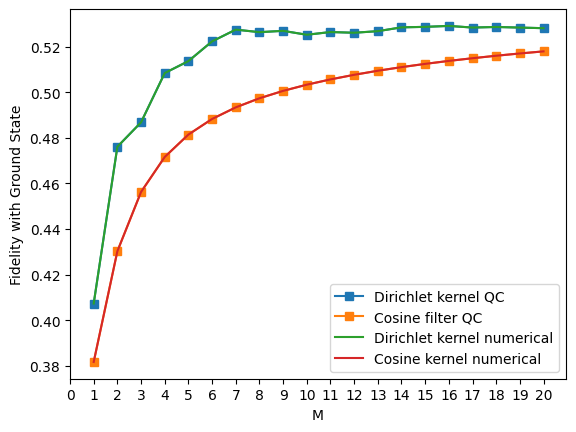

In [201]:
import pennylane as qml
from pennylane import numpy as np

def heisenberg_hamiltonian(n_qubits, Jx=1.0, Jy=1.0, Jz=1.0, h=0.0, periodic=False):
    """返回 n_qubits 自旋-1/2 Heisenberg 模型的 qml.Hamiltonian.

    H = Σ_{<i,j>} (Jx X_i X_j + Jy Y_i Y_j + Jz Z_i Z_j) + h Σ_i Z_i

    参数
    ----
    n_qubits : int
        比特数
    Jx, Jy, Jz : float
        XYZ 各向异性耦合系数
    h : float
        沿 z 方向的外场强度
    periodic : bool
        True 表示周期边界（i 和 i+1 按 mod n 连接），
        False 表示开边界（只连 0-1, 1-2, ..., n-2 - n-1）
    """
    coeffs = []
    ops = []

    # 相邻对 (i, j)
    if periodic:
        neighbors = [(i, (i + 1) % n_qubits) for i in range(n_qubits)]
    else:
        neighbors = [(i, i + 1) for i in range(n_qubits - 1)]

    # 相互作用项
    for i, j in neighbors:
        if Jx != 0.0:
            coeffs.append(Jx)
            ops.append(qml.PauliX(i) @ qml.PauliX(j))

        if Jy != 0.0:
            coeffs.append(Jy)
            ops.append(qml.PauliY(i) @ qml.PauliY(j))

        if Jz != 0.0:
            coeffs.append(Jz)
            ops.append(qml.PauliZ(i) @ qml.PauliZ(j))

    # 外场项 h Σ Z_i
    if h != 0.0:
        for i in range(n_qubits):
            coeffs.append(h)
            ops.append(qml.PauliZ(i))

    H = qml.Hamiltonian(coeffs, ops)
    return H

# ====== 具体：4 qubits 海森堡链的例子 ======
n_qubits = 4
H_heis = heisenberg_hamiltonian(
    n_qubits=4,
    Jx=1.0, Jy=1.0, Jz=1.0,  # 各向同性 Heisenberg XXX+YYY+ZZZ
    h=0.0,                   # 无外场
    periodic=False           # 开边界：0-1, 1-2, 2-3
)

matrix_temp = qml.matrix(H_heis)
eigvals, eigvecs = np.linalg.eigh(matrix_temp)
print(eigvals)

n = 4
dim = 2 ** n

def get_ground_state(H):
    eigvals, eigvecs = np.linalg.eigh(H)
    return eigvecs[:, np.argmin(eigvals)]

def shift_and_normalize_H(H):
    eigvals = np.linalg.eigvalsh(H)
    λ_min, λ_max = np.min(eigvals), np.max(eigvals)
    H_norm = (H - λ_min * np.eye(len(H))) / (λ_max - λ_min) * np.pi /2
    λ0 = np.min(np.linalg.eigvalsh(H_norm))
    H_shifted = H_norm - λ0 * np.eye(len(H))
    return H_shifted

def shift_and_normalize_H1(H):
    eigvals = np.linalg.eigvalsh(H)
    λ_min, λ_max = np.min(eigvals), np.max(eigvals)
    H_norm = (H - λ_min * np.eye(len(H))) / (λ_max - λ_min) * np.pi
    λ0 = np.min(np.linalg.eigvalsh(H_norm))
    H_shifted = H_norm - λ0 * np.eye(len(H))
    return H_shifted

def generate_random_state_with_overlap(gs, overlap):

    gs = gs / np.linalg.norm(gs)

    dim = len(gs)

    v = np.random.randn(dim) + 1j * np.random.randn(dim)

    proj = np.vdot(gs, v) * gs
    v_perp = v - proj

    if np.linalg.norm(v_perp) < 1e-12:
        return generate_random_state_with_overlap(gs, overlap)

    v_perp = v_perp / np.linalg.norm(v_perp)

    psi = np.sqrt(overlap) * gs + np.sqrt(1 - overlap) * v_perp
    psi = psi / np.linalg.norm(psi)

    return psi

def kron_n(op_list):
    result = np.array([[1]])
    for op in op_list:
        result = np.kron(result, op)
    return result

# TFIM Hamiltonian
def tfim_model(n):
    dim = 2 ** n
    H = np.zeros((dim, dim), dtype=np.complex128)
    Z = np.array([[1, 0], [0, -1]])
    X = np.array([[0, 1], [1, 0]])
    I = np.eye(2)
    for i in range(n):
        Zi = [I] * n
        Zi[i] = Z
        Zi[(i + 1) % n] = Z
        H -= kron_n(Zi)
        Xi = [I] * n
        Xi[i] = X
        H -= kron_n(Xi)
    return H



# 归一化并 shift
H = -matrix_temp
H_shifted = shift_and_normalize_H(H)
ground_state = get_ground_state(H_shifted)
#init_state = np.ones(dim) / np.sqrt(dim)
init_state = generate_random_state_with_overlap(ground_state, 1/n)


H_shifted1 = shift_and_normalize_H1(H)
def dirichlet_block_encoding(max_N):
    k_vals_full = np.arange(-max_N, max_N + 1)
    alpha_k = np.array([1/(2* max_N + 1) for k in k_vals_full])

    pad_len = 2 ** int(np.ceil(np.log2(len(alpha_k))))
    alpha_padded = np.zeros(pad_len)
    alpha_padded[:len(alpha_k)] = alpha_k
    weights = np.sqrt(alpha_padded / np.sum(alpha_padded))
    #weights = alpha_padded
    #print('weights:', weights)
    n_anc = int(np.log2(pad_len))
    ancilla_wires = list(range(n_anc))
    system_wires = list(range(n_anc, n_anc + n))
    U_list = [expm(-1.0j * k * H_shifted1) for k in k_vals_full]
    U_list += [np.eye(dim)] * (pad_len - len(U_list))
    U_ops = [qml.QubitUnitary(U, wires=range(n_anc, n_anc + n)) for U in U_list]
    dev = qml.device("default.qubit", wires=n + n_anc)

    @qml.qnode(dev)
    def block_encoding():
        # for i in system_wires:
        #     qml.Hadamard(i)
        qml.StatePrep(init_state, wires=range(n_anc, n+n_anc))
        # for i in range(n_anc, n+n_anc, 2):
        #     qml.X(i)
        qml.StatePrep(weights, wires=range(n_anc))
        qml.Select(U_ops, control=range(n_anc))
        qml.adjoint(qml.StatePrep)(weights, wires=range(n_anc))
        return qml.state()

    # U_be = qml.matrix(block_encoding, wire_order=list(range(n_anc)) + list(range(n_anc, n_anc + n)))()
    # A_block = U_be[:dim, :dim]
    # be_state = A_block @ init_state
    full_state = block_encoding()
    reshaped = full_state.reshape((2 ** n_anc, 2 ** n))
    system_state = reshaped[0, :]
    be_state = system_state

    success_prob = np.sum(np.abs(be_state) ** 2)
    be_state /= np.linalg.norm(be_state)
    fidelity = np.abs(np.vdot(be_state, ground_state)) ** 2
    return fidelity, success_prob


def fidelity_block_encoding(m):
    k_vals_full = np.arange(-m, m + 1)
    alpha_k_full = 2 ** (-2 * m) * np.array([math.comb(2 * m, m + k) for k in k_vals_full])
    keep = [i for i in range(len(alpha_k_full)) if alpha_k_full[i] > 1e-4]
    alpha_k = alpha_k_full[keep]
    k_vals = k_vals_full[keep]
    alpha_k /= np.sum(alpha_k)
    pad_len = 2 ** int(np.ceil(np.log2(len(alpha_k))))
    alpha_padded = np.zeros(pad_len)
    alpha_padded[:len(alpha_k)] = alpha_k
    weights = np.sqrt(alpha_padded / np.sum(alpha_padded))
    n_anc = int(np.log2(pad_len))
    ancilla_wires = list(range(n_anc))
    system_wires = list(range(n_anc, n_anc + n))
    U_list = [expm(2j * k * H_shifted) for k in k_vals]
    U_list += [np.eye(dim)] * (pad_len - len(U_list))
    U_ops = [qml.QubitUnitary(U, wires=range(n_anc, n_anc + n)) for U in U_list]
    dev = qml.device("default.qubit", wires=n + n_anc)

    @qml.qnode(dev)
    def block_encoding():
        # for i in system_wires:
        #     qml.Hadamard(i)
        qml.StatePrep(init_state, wires=range(n_anc, n+n_anc))
        # for i in range(n_anc, n+n_anc, 2):
        #     qml.X(i)
        qml.StatePrep(weights, wires=range(n_anc))
        qml.Select(U_ops, control=range(n_anc))
        qml.adjoint(qml.StatePrep)(weights, wires=range(n_anc))
        return qml.state()

    # U_be = qml.matrix(block_encoding, wire_order=list(range(n_anc)) + list(range(n_anc, n_anc + n)))()
    # A_block = U_be[:dim, :dim]
    # be_state = A_block @ init_state
    full_state = block_encoding()
    reshaped = full_state.reshape((2 ** n_anc, 2 ** n))
    system_state = reshaped[0, :]
    be_state = system_state

    success_prob = np.sum(np.abs(be_state) ** 2)
    be_state /= np.linalg.norm(be_state)
    fidelity = np.abs(np.vdot(be_state, ground_state)) ** 2
    return fidelity, success_prob

def cosine_filter_matrix(H, m):
    U = expm(1j * H)
    U_dag = expm(-1j * H)
    cosH = 0.5 * (U + U_dag)
    return np.linalg.matrix_power(cosH, 2*m)

def custom_filter_matrix(H, N):
    return 1/(2*N+1) * sum(expm(-1j * H * i) for i in range(-N, N + 1)) #/ N  # corrected j = N+1 to 2N

def evaluate_fidelity(filter_matrix, init_state, H_shifted):
    psi = filter_matrix @ init_state
    psi /= np.linalg.norm(psi)
    return np.abs(np.vdot(psi, ground_state)) ** 2
    #return np.linalg.norm(psi-ground_state)**2
    #return float(np.real_if_close(np.vdot(psi, H_shifted@psi)))



# 扫描 m
max_N = 20
m_vals = list(range(1, max_N + 1))
fidelity_cosine, success_cosine = zip(*[fidelity_block_encoding(m) for m in list(range(1, max_N+1))])#list(range(1, max_N//2 + 1))])

N_list = list(range(1, max_N + 1))
fidelity_be, success_be = zip(*[dirichlet_block_encoding(N) for N in N_list])


# Fidelity for custom filter as N varies
fidelity_list = []
for N_iter in range(1, max_N + 1):
    H_shifted = shift_and_normalize_H1(H)
    fH = custom_filter_matrix(H_shifted, N_iter)
    fidelity_custom = evaluate_fidelity(fH, init_state, H)
    fidelity_list.append(fidelity_custom)

fidelity_cos_list = []
for m_vals in range(1,max_N+1):
    H_shifted = shift_and_normalize_H(H)
    cos_filter = cosine_filter_matrix(H_shifted, m_vals)
    fidelity_cos = evaluate_fidelity(cos_filter, init_state, H)
    fidelity_cos_list.append(fidelity_cos)


plt.plot(N_list, fidelity_be, marker='s', label='Dirichlet kernel QC')
#plt.plot(list(range(1, max_N + 1, 2)), fidelity_cosine, marker='s', label='Cosine filter')
plt.plot(list(range(1, max_N + 1)), fidelity_cosine, marker='s', label='Cosine filter QC')

plt.plot(range(1, max_N + 1), fidelity_list, label="Dirichlet kernel numerical")
#plt.axhline(y=fidelity_cos, color='r', linestyle='--', label="cos^{2m}(H) Fidelity")
plt.plot(list(range(1, max_N+1)), fidelity_cos_list, label='Cosine kernel numerical')

plt.xlabel("M")
plt.xticks(list(range(0, max_N + 1)))
plt.ylabel("Fidelity with Ground State")
#plt.title("Fidelity vs. m")
plt.legend()
#plt.grid(True)
#plt.savefig("cosine compare with dirichlet n6.png")
plt.show()

[-6.46410162 -3.82842712 -3.82842712 -3.82842712 -1.         -1.
 -1.          0.46410162  1.82842712  1.82842712  1.82842712  3.
  3.          3.          3.          3.        ]


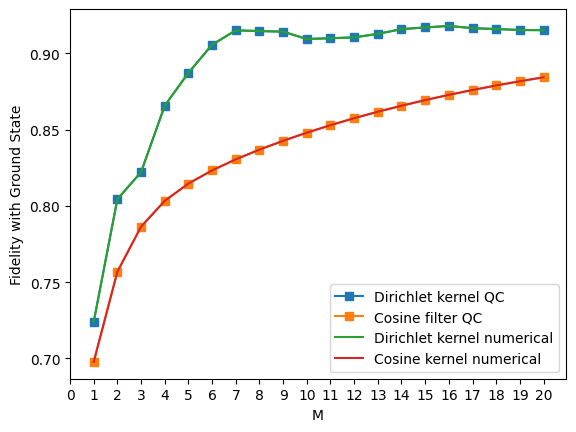

In [202]:
import pennylane as qml
from pennylane import numpy as np

def heisenberg_hamiltonian(n_qubits, Jx=1.0, Jy=1.0, Jz=1.0, h=0.0, periodic=False):
    """返回 n_qubits 自旋-1/2 Heisenberg 模型的 qml.Hamiltonian.

    H = Σ_{<i,j>} (Jx X_i X_j + Jy Y_i Y_j + Jz Z_i Z_j) + h Σ_i Z_i

    参数
    ----
    n_qubits : int
        比特数
    Jx, Jy, Jz : float
        XYZ 各向异性耦合系数
    h : float
        沿 z 方向的外场强度
    periodic : bool
        True 表示周期边界（i 和 i+1 按 mod n 连接），
        False 表示开边界（只连 0-1, 1-2, ..., n-2 - n-1）
    """
    coeffs = []
    ops = []

    # 相邻对 (i, j)
    if periodic:
        neighbors = [(i, (i + 1) % n_qubits) for i in range(n_qubits)]
    else:
        neighbors = [(i, i + 1) for i in range(n_qubits - 1)]

    # 相互作用项
    for i, j in neighbors:
        if Jx != 0.0:
            coeffs.append(Jx)
            ops.append(qml.PauliX(i) @ qml.PauliX(j))

        if Jy != 0.0:
            coeffs.append(Jy)
            ops.append(qml.PauliY(i) @ qml.PauliY(j))

        if Jz != 0.0:
            coeffs.append(Jz)
            ops.append(qml.PauliZ(i) @ qml.PauliZ(j))

    # 外场项 h Σ Z_i
    if h != 0.0:
        for i in range(n_qubits):
            coeffs.append(h)
            ops.append(qml.PauliZ(i))

    H = qml.Hamiltonian(coeffs, ops)
    return H

# ====== 具体：4 qubits 海森堡链的例子 ======
n_qubits = 4
H_heis = heisenberg_hamiltonian(
    n_qubits=4,
    Jx=1.0, Jy=1.0, Jz=1.0,  # 各向同性 Heisenberg XXX+YYY+ZZZ
    h=0.0,                   # 无外场
    periodic=False           # 开边界：0-1, 1-2, 2-3
)

matrix_temp = qml.matrix(H_heis)
eigvals, eigvecs = np.linalg.eigh(-matrix_temp)
print(eigvals)

n = 4
dim = 2 ** n

def get_ground_state(H):
    eigvals, eigvecs = np.linalg.eigh(H)
    return eigvecs[:, np.argmin(eigvals)]

def shift_and_normalize_H(H):
    eigvals = np.linalg.eigvalsh(H)
    λ_min, λ_max = np.min(eigvals), np.max(eigvals)
    H_norm = (H - λ_min * np.eye(len(H))) / (λ_max - λ_min) * np.pi /2
    λ0 = np.min(np.linalg.eigvalsh(H_norm))
    H_shifted = H_norm - λ0 * np.eye(len(H))
    return H_shifted

def shift_and_normalize_H1(H):
    eigvals = np.linalg.eigvalsh(H)
    λ_min, λ_max = np.min(eigvals), np.max(eigvals)
    H_norm = (H - λ_min * np.eye(len(H))) / (λ_max - λ_min) * np.pi
    λ0 = np.min(np.linalg.eigvalsh(H_norm))
    H_shifted = H_norm - λ0 * np.eye(len(H))
    return H_shifted

def generate_random_state_with_overlap(gs, overlap):

    gs = gs / np.linalg.norm(gs)

    dim = len(gs)

    v = np.random.randn(dim) + 1j * np.random.randn(dim)

    proj = np.vdot(gs, v) * gs
    v_perp = v - proj

    if np.linalg.norm(v_perp) < 1e-12:
        return generate_random_state_with_overlap(gs, overlap)

    v_perp = v_perp / np.linalg.norm(v_perp)

    psi = np.sqrt(overlap) * gs + np.sqrt(1 - overlap) * v_perp
    psi = psi / np.linalg.norm(psi)

    return psi

def kron_n(op_list):
    result = np.array([[1]])
    for op in op_list:
        result = np.kron(result, op)
    return result

# TFIM Hamiltonian
def tfim_model(n):
    dim = 2 ** n
    H = np.zeros((dim, dim), dtype=np.complex128)
    Z = np.array([[1, 0], [0, -1]])
    X = np.array([[0, 1], [1, 0]])
    I = np.eye(2)
    for i in range(n):
        Zi = [I] * n
        Zi[i] = Z
        Zi[(i + 1) % n] = Z
        H -= kron_n(Zi)
        Xi = [I] * n
        Xi[i] = X
        H -= kron_n(Xi)
    return H



# 归一化并 shift
H = -matrix_temp
H_shifted = shift_and_normalize_H(H)
ground_state = get_ground_state(H_shifted)
#init_state = np.ones(dim) / np.sqrt(dim)
init_state = generate_random_state_with_overlap(ground_state, 2/n)


H_shifted1 = shift_and_normalize_H1(H)
def dirichlet_block_encoding(max_N):
    k_vals_full = np.arange(-max_N, max_N + 1)
    alpha_k = np.array([1/(2* max_N + 1) for k in k_vals_full])

    pad_len = 2 ** int(np.ceil(np.log2(len(alpha_k))))
    alpha_padded = np.zeros(pad_len)
    alpha_padded[:len(alpha_k)] = alpha_k
    weights = np.sqrt(alpha_padded / np.sum(alpha_padded))
    #weights = alpha_padded
    #print('weights:', weights)
    n_anc = int(np.log2(pad_len))
    ancilla_wires = list(range(n_anc))
    system_wires = list(range(n_anc, n_anc + n))
    U_list = [expm(-1.0j * k * H_shifted1) for k in k_vals_full]
    U_list += [np.eye(dim)] * (pad_len - len(U_list))
    U_ops = [qml.QubitUnitary(U, wires=range(n_anc, n_anc + n)) for U in U_list]
    dev = qml.device("default.qubit", wires=n + n_anc)

    @qml.qnode(dev)
    def block_encoding():
        # for i in system_wires:
        #     qml.Hadamard(i)
        qml.StatePrep(init_state, wires=range(n_anc, n+n_anc))
        # for i in range(n_anc, n+n_anc, 2):
        #     qml.X(i)
        qml.StatePrep(weights, wires=range(n_anc))
        qml.Select(U_ops, control=range(n_anc))
        qml.adjoint(qml.StatePrep)(weights, wires=range(n_anc))
        return qml.state()

    # U_be = qml.matrix(block_encoding, wire_order=list(range(n_anc)) + list(range(n_anc, n_anc + n)))()
    # A_block = U_be[:dim, :dim]
    # be_state = A_block @ init_state
    full_state = block_encoding()
    reshaped = full_state.reshape((2 ** n_anc, 2 ** n))
    system_state = reshaped[0, :]
    be_state = system_state

    success_prob = np.sum(np.abs(be_state) ** 2)
    be_state /= np.linalg.norm(be_state)
    fidelity = np.abs(np.vdot(be_state, ground_state)) ** 2
    return fidelity, success_prob


def fidelity_block_encoding(m):
    k_vals_full = np.arange(-m, m + 1)
    alpha_k_full = 2 ** (-2 * m) * np.array([math.comb(2 * m, m + k) for k in k_vals_full])
    keep = [i for i in range(len(alpha_k_full)) if alpha_k_full[i] > 1e-4]
    alpha_k = alpha_k_full[keep]
    k_vals = k_vals_full[keep]
    alpha_k /= np.sum(alpha_k)
    pad_len = 2 ** int(np.ceil(np.log2(len(alpha_k))))
    alpha_padded = np.zeros(pad_len)
    alpha_padded[:len(alpha_k)] = alpha_k
    weights = np.sqrt(alpha_padded / np.sum(alpha_padded))
    n_anc = int(np.log2(pad_len))
    ancilla_wires = list(range(n_anc))
    system_wires = list(range(n_anc, n_anc + n))
    U_list = [expm(2j * k * H_shifted) for k in k_vals]
    U_list += [np.eye(dim)] * (pad_len - len(U_list))
    U_ops = [qml.QubitUnitary(U, wires=range(n_anc, n_anc + n)) for U in U_list]
    dev = qml.device("default.qubit", wires=n + n_anc)

    @qml.qnode(dev)
    def block_encoding():
        # for i in system_wires:
        #     qml.Hadamard(i)
        qml.StatePrep(init_state, wires=range(n_anc, n+n_anc))
        # for i in range(n_anc, n+n_anc, 2):
        #     qml.X(i)
        qml.StatePrep(weights, wires=range(n_anc))
        qml.Select(U_ops, control=range(n_anc))
        qml.adjoint(qml.StatePrep)(weights, wires=range(n_anc))
        return qml.state()

    # U_be = qml.matrix(block_encoding, wire_order=list(range(n_anc)) + list(range(n_anc, n_anc + n)))()
    # A_block = U_be[:dim, :dim]
    # be_state = A_block @ init_state
    full_state = block_encoding()
    reshaped = full_state.reshape((2 ** n_anc, 2 ** n))
    system_state = reshaped[0, :]
    be_state = system_state

    success_prob = np.sum(np.abs(be_state) ** 2)
    be_state /= np.linalg.norm(be_state)
    fidelity = np.abs(np.vdot(be_state, ground_state)) ** 2
    return fidelity, success_prob

def cosine_filter_matrix(H, m):
    U = expm(1j * H)
    U_dag = expm(-1j * H)
    cosH = 0.5 * (U + U_dag)
    return np.linalg.matrix_power(cosH, 2*m)

def custom_filter_matrix(H, N):
    return 1/(2*N+1) * sum(expm(-1j * H * i) for i in range(-N, N + 1)) #/ N  # corrected j = N+1 to 2N

def evaluate_fidelity(filter_matrix, init_state, H_shifted):
    psi = filter_matrix @ init_state
    psi /= np.linalg.norm(psi)
    return np.abs(np.vdot(psi, ground_state)) ** 2
    #return np.linalg.norm(psi-ground_state)**2
    #return float(np.real_if_close(np.vdot(psi, H_shifted@psi)))



# 扫描 m
max_N = 20
m_vals = list(range(1, max_N + 1))
fidelity_cosine, success_cosine = zip(*[fidelity_block_encoding(m) for m in list(range(1, max_N+1))])#list(range(1, max_N//2 + 1))])

N_list = list(range(1, max_N + 1))
fidelity_be, success_be = zip(*[dirichlet_block_encoding(N) for N in N_list])


# Fidelity for custom filter as N varies
fidelity_list = []
for N_iter in range(1, max_N + 1):
    H_shifted = shift_and_normalize_H1(H)
    fH = custom_filter_matrix(H_shifted, N_iter)
    fidelity_custom = evaluate_fidelity(fH, init_state, H)
    fidelity_list.append(fidelity_custom)

fidelity_cos_list = []
for m_vals in range(1,max_N+1):
    H_shifted = shift_and_normalize_H(H)
    cos_filter = cosine_filter_matrix(H_shifted, m_vals)
    fidelity_cos = evaluate_fidelity(cos_filter, init_state, H)
    fidelity_cos_list.append(fidelity_cos)


plt.plot(N_list, fidelity_be, marker='s', label='Dirichlet kernel QC')
#plt.plot(list(range(1, max_N + 1, 2)), fidelity_cosine, marker='s', label='Cosine filter')
plt.plot(list(range(1, max_N + 1)), fidelity_cosine, marker='s', label='Cosine filter QC')

plt.plot(range(1, max_N + 1), fidelity_list, label="Dirichlet kernel numerical")
#plt.axhline(y=fidelity_cos, color='r', linestyle='--', label="cos^{2m}(H) Fidelity")
plt.plot(list(range(1, max_N+1)), fidelity_cos_list, label='Cosine kernel numerical')

plt.xlabel("M")
plt.xticks(list(range(0, max_N + 1)))
plt.ylabel("Fidelity with Ground State")
#plt.title("Fidelity vs. m")
plt.legend()
#plt.grid(True)
#plt.savefig("cosine compare with dirichlet n6.png")
plt.show()

## Test

In [21]:
N2 = 4
k_vals_full = np.arange(-N2, N2+1)
np.array([1 for k in k_vals_full])

array([1, 1, 1, 1, 1, 1, 1, 1, 1])

In [22]:
np.ones(2*N2+1)

array([1., 1., 1., 1., 1., 1., 1., 1., 1.])